How to handle normalizations:

- Normalize everything to the onbeam data.

- Weight the offbeam data: (onbeam_livetime)/(offbeam_livetime)

- Weight the MC: (onbeam_POT)/(MC_Pot)

Data to compare the MC to: (onbeam - offbeam)
uncertainty for data: consider the weight of the offbeam.

This subtracts off cosmic-triggered data. Good b/c our MC only has neutrino events (with cosmics overlayed, but in the same reconstructed event).


In [1]:
1+1
# 3/1/24: From Nate, where he's getting the updated data that has the new flux weights incorporated: 
#/icarus/data/users/gputnam/DMCP2023G/mc-F-spectra/wdetsyst

2

In [2]:
import uproot
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np 
import matplotlib as mpl
import pickle
import h5py
import math

from util import *
import var
import cut
import data
import hist

import importlib

import pid
from pyanalib import panda_helpers
import os
import multiprocessing

#from unc_funcs import *
from unc_samples import *
from unc_MCdata_overhead import *

import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

import subprocess


Middle Ind. Opaque
Middle Ind. Transparent
Front Ind. Gain Low
Front Ind. Gain High
Noise 1.2x
Space Charge 2x
Ind0 Nom
onbeamR1_pot:  4.651603646822754e+19
onbeamR2_pot:  1.9447555727369336e+20
Combined onbeam POT:  2.409915937419209e+20
<KeysViewHDF5 ['evt', 'hdr', 'mcnu']>
mc_incoh_pot:  8.0673304e+20
<KeysViewHDF5 ['evt', 'hdr', 'mch', 'mcnu']>
mccoh_hdr_pot:  5.5160685e+21


/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/unc_funcs.py:616: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ppdf = scalar_mom - scalar_mom.dot(BEAMDIR)[:,np.newaxis]*np.repeat([BEAMDIR], repeats=scalar_mom.shape[0], axis=0)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/unc_funcs.py:616: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ppdf = scalar_mom - scalar_mom.dot(BEAMDIR)[:,np.newaxis]*np.repeat([BEAMDIR], repeats=scalar_mom.shape[0], axis=0)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/di

/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/unc_funcs.py:616: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ppdf = scalar_mom - scalar_mom.dot(BEAMDIR)[:,np.newaxis]*np.repeat([BEAMDIR], repeats=scalar_mom.shape[0], axis=0)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/unc_funcs.py:616: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ppdf = scalar_mom - scalar_mom.dot(BEAMDIR)[:,np.newaxis]*np.repeat([BEAMDIR], repeats=scalar_mom.shape[0], axis=0)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/di

In [3]:
from pyanalib import variable, histogram
from pyanalib.dataset import Dataset

importlib.reload(var)
importlib.reload(cut)
importlib.reload(data)
importlib.reload(hist)
importlib.reload(panda_helpers)
importlib.reload(variable)

<module 'pyanalib.variable' from '/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/pyanalib/variable.py'>

In [4]:
mpl.rc('font', size=14)

dosave = False
savedir = "/exp/icarus/data/users/jdyer/muon_datamc/lightened/"
savedir = "/exp/icarus/data/users/jdyer/muon_datamc/lightened_wConcreteFix/"
print(savedir)

/exp/icarus/data/users/jdyer/muon_datamc/lightened_wConcreteFix/


### Notes on Very Far Sideband definition: 

In November 2023, I defined a Very Far Sideband as a region with large opening angles ((1.25,2) radians) and NuMI angle > 0.15 radians (=8.6*).

Two things: 

1) I need to make sure my sideband definition is a subset of what Gray was approved to use in their far sideband definition, which is events with NuMI angles > 15*

2) For consistency with Gray, and also b/c its easier to conceptualize, use degrees instead:
- 1.25 rad = 71.6* --> Use 70* instead
- 2 rad = 114.6* --> Use 115* instead

In [7]:
nmu = var.DF.iscc & ((var.DF.pdg == 14) | (var.DF.pdg == -14))
npi = var.DF.npi
ns = var.DF.nsm + var.DF.nsp

is_coh_like = (nmu + npi + ns >= 2) & (var.DF.max_proton_ke < 0.05)


In [6]:
~is_coh_like


In [9]:
import gc
gc.collect() # What is this, and why is it different every time?


187

In [8]:
# onbeamR1 livetime:  9882862.456666667
# onbeamR2 livetime:  42174524.55000002

# offbeamR1 livetime:  5028250.154999999
# offbeamR2 livetime:  50284602.855000004

# ~~~~~~~~~~~

# mccoh POT:  5.926336e+21
#

# onbeamR1 POT:  5.128076572325904e+19
# onbeamR2 POT:  2.122704992632837e+20

# ~~~~~~~~~~~

#systFile:  /icarus/data/users/gputnam/DMCP2023G/mc/dfs-wstubs/coh-like-evt-ind1bin0.df
#mc_incoh livetime:  0.0
#mc_incoh POT:  5.933752e+21

#systFile:  /icarus/data/users/gputnam/DMCP2023G/mc/dfs-wstubs/coh-like-evt-ind1bin14.df
#mc_incoh livetime:  0.0
#mc_incoh POT:  5.932365e+21

#systFile:  /icarus/data/users/gputnam/DMCP2023G/mc/dfs-wstubs/coh-like-evt-ind0gainlo.df
#mc_incoh livetime:  0.0
#mc_incoh POT:  5.9276587e+21

#systFile:  /icarus/data/users/gputnam/DMCP2023G/mc/dfs-wstubs/coh-like-evt-ind0gainhi.df
#mc_incoh livetime:  0.0
#mc_incoh POT:  5.930137e+21

#systFile:  /icarus/data/users/gputnam/DMCP2023G/mc/dfs-wstubs/coh-like-evt-noisehi.df
#mc_incoh livetime:  0.0
#mc_incoh POT:  5.931287e+21

# Lighten datasets.
## Only Need to run once to save. Usually, can skip this section and instead go to "Start Here" section

## Input Files and functions

'mcfile' here --> 'nu_file' in unc_samples.py

'mccohfile' here --> 'cohlike_nu_file' in unc_samples.py

'mccoh_syst_files' --> 'cohlike_nu_detVar_files' in unc_samples.py

'syst_labels' --> detVar_labels in unc_samples.py 

###'lighten_dataset()' --> 'add_to_evtdf()' and 'veryFarSB()'

'lighten_dataset()' --> 'add_calculated_evtdf_cols()' and 'veryFarSB()' and (satisfies current FV def) and (require exiting)

mc_filedir and data_filedir --> savedir_sb

all_mc_filedir --> savedir_all_mc

## MC Coh
Keys I do: evt, hdr, mch, mcnu

This sample contains coh-LIKE events. Really, it is any event with a muon or a pion in the final state. This means that the interaction isn't neccessarily a coherent interaction, but it just looks like one. 

Note: It is possible that there is pileup in the neutrino interactions. If it happens that two neutrino interactions overlap in a single reconstructed slice, then even if the "bonus" one is not coh-like, it would be included in this sample as well. Having two neutrino interactions overlap like this is extremely unlikely, so this probably never happens.

## MC Incoh
Keys I do: evt, hdr

## Data
Keys I do: evt, hdr

### Onbeam

In [15]:
#test
f = h5py.File(onbeamfile_Run1, 'r')
print(f.keys(), '\n')
print(savedir)

<KeysViewHDF5 ['evt', 'hdr', 'mch', 'mcnu', 'mcnuwgt']> 

/exp/icarus/data/users/jdyer/muon_datamc/lightened_wConcreteFix/


### Offbeam

# Start Here

Note: The Sideband I had defined prior to January 11, which I made the lightened dataframes with, included too-small of NuMI angles to be in compliance with what Gray got approved. 
So, I need to make sure I mask those out here too, until I've rerun the "lighten" stuff with the updated sideband.

In [10]:
# fraction of all MC events that are from cohlike file:

# NOTE: what I calculate below is the fraction for the whole sample. But where I actually use this rescaling, which is in 
#       treatment of the detector systematics specta, I want to calculate and apply this fraction bin by bin. 
#       So, don't actually use this thing below in practice.

frac_cohlike = (mccoh_evt.shape[0]*GOAL_POT/mccoh_hdr_pot) / ( (mc_incoh_evt.shape[0]*GOAL_POT/mc_incoh_pot) +  (mccoh_evt.shape[0]*GOAL_POT/mccoh_hdr_pot) )
print(frac_cohlike)


0.09525864714449198


In [11]:
# MCCOH SYST POTs
 
for h in syst_hdrs:
    print(np.sum(h.pot * h.first_in_subrun))
    # Note: this DOES match what the mc_dataset() function spat out above.

4.821847e+21
5.5285587e+21
4.1396564e+21
3.5396618e+21
5.3094546e+21
5.1986385e+21
5.3344124e+21


In [9]:
# LEAVING OFF HERE 5PM TUESDAY 10/1/24.

# Concatenate Data for Runs 1 and 2:

# Note: There are rows in R1 and R2 that have the same indices, 
#       so those sets of indices will be duplicated in the concatenated version, but both rows will still be saved.
#       Just something to be aware of / remember in case it causes issues or confusion downstream.

onbeam_evt = pd.concat([onbeamR1_evt,onbeamR2_evt])
onbeam_hdr = pd.concat([onbeamR1_hdr,onbeamR2_hdr])
#print(onbeam.shape)
#print(onbeamR1_evt.shape)
#print(onbeamR2_evt.shape)
offbeam_evt = pd.concat([offbeamR1_evt,offbeamR2_evt])
offbeam_hdr = pd.concat([offbeamR1_hdr,offbeamR1_hdr])

#for ind in onbeamR1_evt.index:
#    if ind in onbeamR2_evt.index:
#        print('This set of indices will be duplicated in concatenated version: ', ind)
#onbeam.loc[[(63,0,0)]]


In [13]:
for col in onbeam_evt.columns:
    if col not in mc_incoh_evt.columns:
        print('This one is not in the mc_incoh_evt dataframe: ', col)


In [14]:
mccoh_evt.wgt.cv # reasons these aren't exactly 1: 
                    # 1) ppfx correction (correction to flux) 
                    # 2) coh pions get reweighted by Mun's tune.
                    # 3) Concrete fix gets put into here too.

__ntuple  entry  rec.slc..index
15        16     0                 0.728721
          37     1                 0.787024
8         30     17                1.000000
6         25     25                0.790041
          29     5                 1.000000
                                     ...   
9278      8      8                 0.790041
          26     9                 0.596473
9276      21     16                0.540548
9277      10     20                1.000000
          33     21                1.000000
Name: cv, Length: 24382, dtype: float64

In [15]:
print(mc_incoh_evt.shape)
print( mc_incoh_evt[is_coh_like_JD(mc_incoh_evt)].shape )


(33868, 772)
<class 'pandas.core.series.Series'>
(0, 772)


In [10]:
%%time

evtdfs = [
    mc_incoh_evt,
    mccoh_evt,
    onbeam_evt,
    offbeam_evt
]

new_evtdfs = []
for df in evtdfs:
    new_df = df[satisfies_new_FV(df)]
    new_evtdfs.append(add_calculated_evtdf_cols(new_df))
evtdfs = new_evtdfs

hdrs = [
    mc_incoh_hdr,
    mccoh_hdr,
    onbeam_hdr,
    offbeam_hdr
]

#pots = [np.sum(hdr.pot * hdr.first_in_subrun) for hdr in hdrs]
#labels = []

#for i, df in enumerate(evtdfs):
#    df["scale"] = GOAL_POT / pots[i]
#    #df["sample"] = labels[i]

evtdf = pd.concat(evtdfs, keys=np.arange(len(evtdfs)), names=['sample'])#, join='inner') 
    # setting join=inner keeps only the columns shared by all dfs being concatenated.
    #     This means it excludes all the systematics stuff calculated for MC. 
    #     But I can always refer back to that stuff in the MC's standalone dataframes. Okay.
print(evtdf.shape)
evtdf = evtdf[satisfies_new_FV(evtdf)]
print(evtdf.shape)
#evtdf["phi_NuMI_mcs"] = phi_NuMI(evtdf.trunk.trk, evtdf.branch.trk, BEAMDIR, 'mcs')[1]

/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/unc_funcs.py:616: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ppdf = scalar_mom - scalar_mom.dot(BEAMDIR)[:,np.newaxis]*np.repeat([BEAMDIR], repeats=scalar_mom.shape[0], axis=0)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-tools/nb/unc_funcs.py:616: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ppdf = scalar_mom - scalar_mom.dot(BEAMDIR)[:,np.newaxis]*np.repeat([BEAMDIR], repeats=scalar_mom.shape[0], axis=0)
/exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/di

(74925, 785)
(74925, 785)
CPU times: user 40.5 s, sys: 49.5 s, total: 1min 30s
Wall time: 8.39 s


In [11]:
cat_colors = soladero_lime

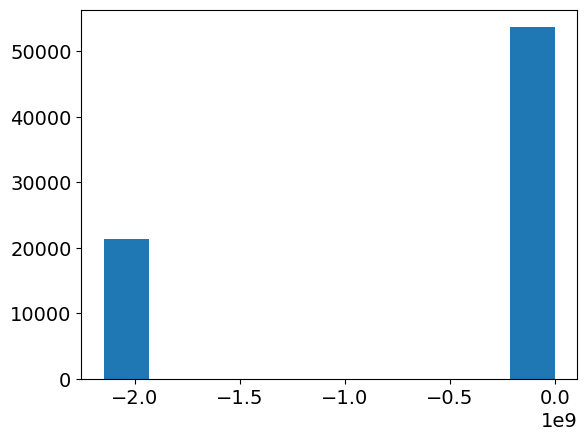

(7,)
[-2147483648          -1           0           1           2           3
           4]


In [15]:
#for c in evtdf.columns: print(c)

plt.hist(evtdf.trunk.trk.truth.p.interaction_id)
plt.show()

print(np.unique(np.array(evtdf.trunk.trk.truth.p.interaction_id)).shape)
print(np.unique(np.array(evtdf.trunk.trk.truth.p.interaction_id)))

In [12]:
# I need my own version of the "make categories" function, but for the different samples here.

# broad categories:
    # mc_incoh
    # mccoh
    # onbeam
    # offbeam
    
# detailed_nu option will further classify the MC samples by types of neutrino interactions.
    
# (figure out systs later.)

# Question: Are there cosmics in these MC and data samples? Yes definitily to data... how do I handle this?


def make_categories(df, detailed_mc='final_state'):
# Use this function to categorize the MC samples (signal and bg) that are used in designing the event selection.
# options for 'detailed_mc' are: 'int_type', 'final_state', 'none'

    #print(detailed_mc, ': \n')
    
    #mc_incoh = (df.loc[[0]]) # Doesn't work bc this needs to be a mask, not a datafram
    mc_incoh = (df.mc_incoh == True)
    mc_incoh.name = 'MC Incoh'
    mc_incoh.color = 'C0' #'#0F923D' # teal: '#6FE3DF'
    
    #mccoh = (df.loc[[1]])
    mccoh = (df.mccoh == True)
    mccoh.name = 'MC coh'
    mccoh.color = 'C1' #"#6F6FE3"
    
    #onbeam = (df.loc[[2]])
    onbeam = (df.onbeam == True)
    onbeam.name = 'Onbeam Data'
    onbeam.color = 'black' #"#E6378F"
    
    #offbeam = (df.loc[[3]])
    offbeam = (df.offbeam == True)
    offbeam.name = 'Offbeam Data'
    offbeam.color = "#EC1C0E"
    
    if detailed_mc == 'int_type':
        
        nu_NC = (df.mc & (df.slc.truth.iscc == 0) & (df.slc.tmatch.idx >= 0))
        nu_NC.name = "$\\nu$ NC"
        nu_NC.color = cat_colors[0] #"#caa834" #"#EAC387"
        
        numu_CC_QE_MEC = (df.mc & (df.slc.truth.pdg == 14) | (df.slc.truth.pdg == -14)) & (df.slc.truth.iscc==1) & ((df.slc.truth.genie_mode == 0) | (df.slc.truth.genie_mode == 10)) # CC QE+MEC
        numu_CC_QE_MEC.name = "$\\nu_\\mu$ CC QE+MEC"
        numu_CC_QE_MEC.color = cat_colors[1] 
        
        numu_CC_RES = (df.mc & (df.slc.truth.pdg == 14) | (df.slc.truth.pdg == -14)) & (df.slc.truth.iscc==1) & (df.slc.truth.genie_mode == 1) # CC RES
        numu_CC_RES.name = "$\\nu_\\mu$ CC RES"
        numu_CC_RES.color = cat_colors[2]
        
        numu_CC_DIS = (df.mc & (df.slc.truth.pdg == 14) | (df.slc.truth.pdg == -14)) & (df.slc.truth.iscc==1) & (df.slc.truth.genie_mode == 2) # CC DIS
        numu_CC_DIS.name = "$\\nu_\\mu$ CC DIS"
        numu_CC_DIS.color = cat_colors[3] 
        
        numu_CC_COH = (df.mc & (df.slc.truth.pdg == 14) | (df.slc.truth.pdg == -14)) & (df.slc.truth.iscc==1) & (df.slc.truth.genie_mode == 3) # CC COH
        numu_CC_COH.name = "$\\nu_\\mu$ CC COH"
        numu_CC_COH.color = cat_colors[4]
        
        nu_other = df.mc & (df.slc.tmatch.idx >= 0) & ~nu_NC & ~numu_CC_QE_MEC & ~numu_CC_RES & ~numu_CC_DIS & ~numu_CC_COH
        nu_other.name = "$\\nu$ Other"
        nu_other.color = cat_colors[5] 
        
        cosmic = df.mc & (df.slc.tmatch.idx < 0)
        cosmic.name = "Cosmic"
        cosmic.color =  cat_colors[6] 
        
        categories = [cosmic] + [nu_other] + [nu_NC] + [numu_CC_QE_MEC] + [numu_CC_RES] + [numu_CC_DIS] + [numu_CC_COH] + [onbeam] + [offbeam]
        return categories
    
    if detailed_mc == 'final_state':
        numu_cc_coh = df.mc & (df.slc.truth.genie_mode == 3) & (np.abs(df.slc.truth.pdg) == 14) & (df.slc.truth.iscc.astype('bool'))
        numu_cc_coh.name = '$\\nu_\\mu$ CC COH'
        numu_cc_coh.color = '#FADD28' #oranges[0]
        
        numu_cc_npizp = (df.mc & 
                         (df.slc.truth.genie_mode != 3) & (np.abs(df.slc.truth.pdg) == 14) & 
                         (df.slc.truth.iscc.astype('bool')) & (df.slc.truth.npi >= 1) & (df.slc.truth.npi0==0) &
                         (df.slc.truth.max_proton_ke < 0.02) )
        numu_cc_npizp.name = "$\\nu_\\mu$ CC n$\\pi$0p"
        numu_cc_npizp.color = oranges[1]
        
        numu_cc_npinp = (df.mc & 
                         (df.slc.truth.genie_mode != 3) & (np.abs(df.slc.truth.pdg) == 14) & 
                         (df.slc.truth.iscc.astype('bool')) & (df.slc.truth.npi >= 1) & (df.slc.truth.npi0==0) & 
                         (df.slc.truth.max_proton_ke >= 0.02))
        numu_cc_npinp.name = '$\\nu_\\mu$ CC n$\\pi$np'
        numu_cc_npinp.color = oranges[2]
        
        numu_cc_other = (df.mc & 
                         (df.slc.truth.genie_mode != 3) & 
                         (np.abs(df.slc.truth.pdg) == 14) & (df.slc.truth.iscc.astype('bool')) & 
                         ( (df.slc.truth.npi<1) | (df.slc.truth.npi0!=0) )
                        )
        numu_cc_other.name = '$\\nu_\\mu$ CC Other'
        numu_cc_other.color = oranges[3]
        
        not_numu_cc = (df.mc & ( (np.abs(df.slc.truth.pdg) != 14) | ~df.slc.truth.iscc.astype('bool') ))
        not_numu_cc.name = 'not $\\nu_\\mu$ CC'
        not_numu_cc.color = oranges[4]
        
        cosmics = df.mc & (df.slc.tmatch.idx < 0) # from any file, so I'm assuming both samples include cosmics.
        cosmics.name = "Cosmic"
        cosmics.color = "C3"
        
        categories = [numu_cc_coh] + [numu_cc_npizp] + [numu_cc_npinp] + [numu_cc_other] + [not_numu_cc] + [cosmics] + [onbeam] + [offbeam]
        return categories
    
    elif detailed_mc == 'none':
        mc_all = (df.mc == True)
        mc_all.name = 'MC'
        mc_all.color = 'C0' 
        #categories = [is_higgs, is_axion, is_alp, is_nu, is_cosmic]
        categories = [mc_all] + [onbeam] + [offbeam]
        return categories
     

In [13]:
saveplots = True
plotdir = '/exp/icarus/data/users/jdyer/muon_datamc/plots/'
def makeplot(df, var, syst_evtdfs, syst_vars, myrange, xlabel = 'x axis',
             bins = 25, vline=None, detailed_mc='int_type', do_systs=True,
             POTSTR=POTSTR, title=None, ratio_bounds=None, plotname='noname', ylabel=None): # , [-1,3]
    # options for 'detailed_mc' are: 'int_type', 'cd /exp/icarus/app/users/jdyer/dev_new_sbnana_v09_69_01/srcs/sbnana/sbnana/SBNAna/icarus-analysis-villiage/pyana/dimuon-toolsfinal_state', 'none'
    
    fig, (p0, p1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3,1]}, sharex=True) #, figsize=(7, 6.4)
    fig.subplots_adjust(hspace=0.03)
    
    mydensity = False

    scale = df.scale.copy()
    #var[np.isnan(var) | (var < 0)] = -10
    var[np.isnan(var)] = -10
    categories = make_categories(df, detailed_mc = detailed_mc)  
    
    # DATA
        
    onbeam_data = plt.hist(var[categories[-2]], 
                    weights=scale[categories[-2]], 
                    bins=bins, alpha=0, density=mydensity, range=myrange) #don't show this, just use for data bin values.
    bin_centers = 0.5*(onbeam_data[1][1:] + onbeam_data[1][:-1])
        
    unq = np.unique(np.array(df[categories[-1]].scale)) # unq sources of offbeam data
    #print('VERIFY THAT THIS NUMBER IS TWO: ', len(unq))
    offbeam_data_0 = plt.hist(var[categories[-1]][ df[categories[-1]].scale == unq[0] ], 
                              weights=scale[categories[-1]][ scale[categories[-1]] == unq[0] ], 
                              bins=bins, alpha=0, density=mydensity, range=myrange)
    offbeam_data_1 = plt.hist(var[categories[-1]][ df[categories[-1]].scale == unq[1] ], 
                              weights=scale[categories[-1]][ scale[categories[-1]] == unq[1] ], 
                              bins=bins, alpha=0, density=mydensity, range=myrange)
    of_w0 = unq[0]
    of_w1 = unq[1]
    #data = np.array(onbeam_data[0]-offbeam_data[0])
    #data_err = np.sqrt(onbeam_data[0]+offbeam_data[0]) # To Do: account for scaling of off-beam data.
    data = np.array(onbeam_data[0]-offbeam_data_0[0]-offbeam_data_1[0])
    #print('data: \n', data)
    #print('DATA EVENTS IN PLOT (w/ Normalization): ', np.sum(data))
    data_err = np.sqrt(onbeam_data[0] + of_w0*offbeam_data_0[0] + of_w1*offbeam_data_1[0])
    
    p0.errorbar(bin_centers, data, marker = '.', 
                yerr = data_err, 
                label="Data w/ Stat. Err.",#"$\\nu$-triggered Onbeam Data \n stat. error", 
                color='black', ls='none') # , drawstyle = 'steps-mid'
    ## plot on and offbeam data separately:
    #p0.errorbar(bin_centers, onbeam_data[0], marker = '.', 
    #            label="Onbeam Data",#"$\\nu$-triggered Onbeam Data \n stat. error", 
    #            color='blue', ls='none')
    #p0.errorbar(bin_centers, offbeam_data_0[0]+offbeam_data_1[0], marker = '.', 
    #            label="Offbeam Data",#"$\\nu$-triggered Onbeam Data \n stat. error", 
    #            color='yellow', ls='none')
    
    
    #p0.errorbar(bin_centers, mc, marker = '.', 
    #            yerr = mc_stat_err, 
    #            label="MC stat. error", 
    #            color='C0', ls='none') # , drawstyle = 'steps-mid'
    
    # MC
    
    if 1==1:#((detailed_mc == 'final_state') | (detailed_mc == 'int_type')):
        if detailed_mc == 'none': histtype_str = 'step'
        else: histtype_str = 'bar'
        _ = p0.hist([var[cat] for cat in categories[:-2]], 
                     weights = [df[cat].scale*df[cat].wgt.cv for cat in categories[:-2]], 
                     color=[cat.color for cat in categories[:-2]],
                     label=[cat.name for cat in categories[:-2]],
                     bins=bins, density=mydensity, histtype=histtype_str, stacked=True, range=myrange)
        try: mc = _[0][-1,:] # np.sum(np.array(_[0]), axis=0)
        except IndexError: mc = _[0]
        mc_bin_nevents = []
        mc_mask = (~categories[-2] & ~categories[-1])
        mc_evtdf = df[mc_mask]
        mc_var = var[mc_mask]
        unq = np.unique(np.array(mc_evtdf.scale))
        #print('AGAIN VERIFY THAT THIS NUMBER IS TWO: ', len(unq)) # for the two runs.
        
        # MC STATISTICAL
        
        for w in unq:
            temp = plt.hist(mc_var[mc_evtdf.scale == w], 
                            bins=bins, alpha=0, density=False, range=myrange)
            mc_bin_nevents.append(temp[0])
        mc_bin_nevents = np.array(mc_bin_nevents) # one row for run 1, one row for run 2.
        #print(mc_bin_nevents.shape)
        mc_stat_err = []
        for b in range(mc_bin_nevents.shape[1]):
            mc_stat_err.append( np.sqrt( (unq[0]**2)*mc_bin_nevents[0,b] + (unq[1]**2)*mc_bin_nevents[1,b] ) )
        mc_stat_err = np.array(mc_stat_err)
        #print('mc_stat_err.shape: ', mc_stat_err.shape)
        #print(mc_stat_err)
        # Note: I include POT normalization (ie scale) in my stat err. (Is this correct?) YES! 
        #       I do NOT include a scaling due to wgt.cv in my stat err. (Is this correct?) NOPE. I NEED TO INCLUDE IT.
        ### I think I should do both or neither of these.
        ##
        
        # MC SYSTEMATICS
        if do_systs:
        
            # UNIVERSE SYSTS - these include multi-sigma, multi-sim, and morph type systematic uncertainties.
        
            weighted_hists = []
            for col in mc_evtdf.wgt["all"].columns:
                if not col[0].startswith("univ"): continue
                #hsyst_weights.append(histf(mc_evtdf.wgt["all"][col]))
                new_weighted_hist = plt.hist(
                    mc_var, 
                    weights = mc_evtdf.scale*mc_evtdf.wgt.cv*mc_evtdf.wgt["all"][col],
                    bins=bins, alpha=0, density=mydensity, range=myrange
                )
                weighted_hists.append(new_weighted_hist[0])
            #hsyst = SystSpectrum(hsyst_weights)
        
            hcov = None
            # average over Universe (each Universe has a bunch of weights-based uncertainties in it)
            for i in range(len(weighted_hists)):
                thiscov = np.outer( mc - weighted_hists[i] , mc - weighted_hists[i] )
                if hcov is None:
                    hcov = thiscov
                else:
                    hcov += thiscov
            Universe_cov = hcov / len(weighted_hists)
        
            #p0.errorbar(bin_centers, mc, marker='.',
            #            yerr = np.sqrt(np.diag(Universe_cov)),
            #            label = 'MC Universe systs.', 
            #            color='C3', ls='none'
            #           )
            #print('np.sqrt(np.diag(Universe_cov)): ', np.sqrt(np.diag(Universe_cov))[-7])
                
            # DETECTOR SYSTEMATICS
        
            cohlike_hist = p0.hist(var[df["mccoh"]==True],
                                   weights = df[df["mccoh"]==True].scale * df[df["mccoh"]==True].wgt.cv, 
                                   bins=bins, alpha=0, density=mydensity, range=myrange)

            #frac_cohlike = (mccoh_evt.shape[0]*GOAL_POT/mccoh_hdr_pot) / ( (mc_incoh_evt.shape[0]*GOAL_POT/mc_incoh_pot) +  (mccoh_evt.shape[0]*GOAL_POT/mccoh_hdr_pot) )
            frac_cohlike_bybin = np.array(cohlike_hist[0]/mc)
            print('frac_cohlike_bybin: ',frac_cohlike_bybin)
        
            detsyst_hists = []
            for s, mc_detsyst_var in enumerate(syst_vars):
                #mc_detsyst_var = sdf.Snumi_angle_mcs*180./math.pi # TODO: generalize this to any var.
                new_detsyst_hist = p0.hist(
                    mc_detsyst_var, 
                    weights = syst_evtdfs[s].scale*syst_evtdfs[s].wgt.cv,
                    #weights = sdf.scale, 
                    bins=bins, alpha=0, density=mydensity, range=myrange
                )
                detsyst_hists.append(new_detsyst_hist[0]/frac_cohlike_bybin)
                    
            # Middle Induction Transparency:
            middle_ind_cov = ( np.outer( mc - detsyst_hists[0] , mc - detsyst_hists[0] ) + np.outer( mc - detsyst_hists[1] , mc - detsyst_hists[1] ) )/2.
            #p0.errorbar(bin_centers, mc, marker='.',
            #            yerr = np.sqrt(np.diag(middle_ind_cov)),
            #            label = 'MC middle induction \n transparency', 
            #            color='C4', ls='none'
            #           )
            #print('np.sqrt(np.diag(middle_ind_cov)): ', np.sqrt(np.diag(middle_ind_cov))[-7])
        
            # Front Induction Gain:
            front_ind_gain_cov = ( np.outer( mc - detsyst_hists[2] , mc - detsyst_hists[2] ) + np.outer( mc - detsyst_hists[3] , mc - detsyst_hists[3] ) )/2.
            #p0.errorbar(bin_centers, mc, marker='.',
            #            yerr = np.sqrt(np.diag(front_ind_gain_cov)),
            #            label = 'MC Front Ind Gain', 
            #            color='C5', ls='none'
            #           )
            #print('np.sqrt(np.diag(front_ind_gain_cov)): ', np.sqrt(np.diag(front_ind_gain_cov))[-7])
       
            # Noise High:
            noise_hi_cov = np.outer( mc - detsyst_hists[4] , mc - detsyst_hists[4] )
            #p0.errorbar(bin_centers, mc, marker='.',
            #            yerr = np.sqrt(np.diag(noise_hi_cov)),
            #            label = 'MC High Noise', 
            #            color='C6', ls='none'
            #           )
            #print('np.sqrt(np.diag(noise_hi_cov)): ', np.sqrt(np.diag(noise_hi_cov)))
        
            # Space Charge Effect x2:
            sce_cov = np.outer( mc - detsyst_hists[5] , mc - detsyst_hists[5] )
            #p0.errorbar(bin_centers, mc, marker='.',
            #            yerr = np.sqrt(np.diag(sce_cov)),
            #            label = 'MC SCE x2', 
            #            color='C7', ls='none'
            #           )
            #print('np.sqrt(np.diag(sce_cov)): ', np.sqrt(np.diag(sce_cov)))
        
            # Ind 0 Nom (?): # changing signal shapes on front induction to Wire Cell nominal. Our nominal (default) is garfield.
            # signal shape simulation is in wire cell (so is 2D convolution, but rn we do 1d deconv. which is not using Wire Cell.)
            ind0nom_cov = np.outer( mc - detsyst_hists[6] , mc - detsyst_hists[6] )
            #p0.errorbar(bin_centers, mc, marker='.',
            #            yerr = np.sqrt(np.diag(ind0nom_cov)),
            #            label = 'MC Ind 0 Nom', 
            #            color='C8', ls='none'
            #           )
        
            # TOTAL SYST ERROR:
        
            #yerr_detector_systs = np.sqrt( np.diag(middle_ind_cov) + np.diag(front_ind_gain_cov) 
            #                          + np.diag(noise_hi_cov) + np.diag(sce_cov) + np.diag(ind0nom_cov))
            #p0.errorbar(bin_centers, mc, marker='.',
            #            yerr = yerr_detector_systs,
            #            label = 'MC Detector Systematics', 
            #            color='C8', ls='none'
            #           )
        
            yerr_syst_total = np.sqrt(np.diag(Universe_cov)+ 
                                      np.diag(middle_ind_cov) + np.diag(front_ind_gain_cov) 
                                      + np.diag(noise_hi_cov) + np.diag(sce_cov) + np.diag(ind0nom_cov))
            #p0.errorbar(bin_centers, mc, marker='.',
            #            yerr = yerr_syst_total,
            #            label = 'MC All Systematics', 
            #            color='C8', ls='none'
            #           )
        
        # TOTAL MC UNCERTAINTY
        
        if do_systs:
            mc_err = np.sqrt(mc_stat_err**2 + yerr_syst_total**2)
            mc_err_label = 'Stat. + Syst. Err.'
            
        else:
            mc_err = mc_stat_err
            mc_err_label = 'Stat. Err.'
        #print('mc_stat_err: ', mc_stat_err)
        #print('mc syst. err: ', yerr_syst_total)
        #print('mc_err: ', mc_err)
        
        #print('mc: ', mc)
        mc_minus_err = np.append((mc - mc_err), 0.)
        mc_minus_err[np.isnan(mc_minus_err)] = 0.
        mc_plus_err = np.append((mc + mc_err), 0.)
        mc_plus_err[np.isnan(mc_plus_err)] = 0.
        fill = p0.fill_between(onbeam_data[1], mc_minus_err, mc_plus_err,  
            step="post", hatch="//", label = mc_err_label,
                               edgecolor="gray", facecolor="gray", alpha=0.4, linewidth=0) #label = 'MC Total Uncertainty', hatch="x", color="gray", alpha=0.5, 
        #print('MC EVENTS IN PLOT (w/ Normalization): ', np.sum(mc))
        #print('DATA/MC IN PLOT (w/ Normalization): ', np.sum(data)/np.sum(mc) )

        #print('bin boundaries:')
        #print(onbeam_data[1][:-1])
    ###
    
    else:
        data = plt.hist(var[categories[2]], weights=scale[categories[2]], bins=bins, 
                        alpha=0, density=mydensity, range=myrange)
        bin_centers = 0.5*(data[1][1:] + data[1][:-1])
        _ = plt.hist([var[categories[0]], var[categories[1]]], 
                     weights = [scale[categories[0]], scale[categories[1]]], 
                     color=[categories[0].color, categories[1].color],
                     label=[categories[0].name, categories[1].name],
                     bins=bins, density=mydensity, histtype='bar', stacked=True, range=myrange)
        plt.errorbar( bin_centers, data[0], marker = '.', yerr = np.sqrt(data[0]), 
                     label=categories[2].name, color='black', ls='none') # , drawstyle = 'steps-mid'
    
    # RATIO
    
    rathole = data/mc # (ratio)
    rathole_err = np.sqrt((data_err/mc)**2 + (data*mc_err/mc**2)**2)
    p1.errorbar( bin_centers, rathole, marker = '.',
                yerr = rathole_err, color='black', ls='none' )
    
    # CHI-SQUARED

    okay_denom = (data_err**2 + mc_err**2)>0
    ndof = (data_err**2 + mc_err**2)[okay_denom].shape[0]
    chi2 = np.sum( ((mc-data)[okay_denom])**2/(data_err**2 + mc_err**2)[okay_denom] ) # denominator is total error squared.
    howgood = chi2/ndof
    print( 'chi2 over n = %a' % howgood )
    #if xs != None:
    #    p0.text(xs[0], xs[1], "$\\chi^2/n$ = %.3f / %i" % (chi2, ndof), fontsize=14)#, transform=plt.transAxes)
        
    ##plt.legend()
    if title is not None:
        p0.set_title(title)
    plt.xlabel(xlabel)
    if ylabel is not None:
        p0.set_ylabel(ylabel+" / %s" % POTSTR)
    else:
        p0.set_ylabel("Events / %s" % POTSTR)
    p1.set_ylabel("Data / MC")
    if ratio_bounds is not None:
        p1.set_ylim(ratio_bounds)
    else:
        p1.set_ylim([-6,8])
    
    p1.axhline([1], linestyle=":", color="r", linewidth=2)
    #plt.yscale("log")
    if (vline is not None):
        for line in vline:
            p0.axvline([line], linestyle=":", color="r", linewidth=2)
            p1.axvline([line], linestyle=":", color="r", linewidth=2)
    #plt.axvline([NuMI_angle_thresh], linestyle=":", color="r", linewidth=2)
    #plt.text(0.6, 0.4, label, transform=plt.gca().transAxes, fontsize=18)
    plt.tight_layout()
    plt.xlim(myrange)
    
    #box = ax.get_position()
    #ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    #ax.legend(loc = 'center left', bbox_to_anchor=(1, 0.5))
    
    # legend documentation: https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.legend.html
    box = p0.get_position()
    p0.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    #p0.legend(loc = 'center left', bbox_to_anchor=(1, 0.5)) # 2-tuple (x,y) of bbox_to_anchor places the corner of the legend specified by 'loc' at (x,y)
    p0.legend(loc='lower center', bbox_to_anchor=(0.5, 1.03), ncol=3, fontsize='x-small')
    box = p1.get_position()
    p1.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    
    p0.text(0.64, 0.96, "ICARUS Data", fontsize=14,
            transform=p0.transAxes, verticalalignment="top")
    p0.text(0.64, 0.81, "$\\chi^2/n$ = %.1f/%i" % (chi2, ndof), fontsize=12, transform=p0.transAxes)#
    
    if saveplots: plt.savefig(plotdir + plotname + ".png", format='png', bbox_inches='tight')
    plt.show()
    
    #return hsyst, cov

In [14]:
# mask out some cosmics

def avoid_cosmics(df): # do calculation in radians. User uses degrees.
    return df.Snumi_angle_mcs < 50.*math.pi/180.

print('Number of events in sideband:')
for cat in make_categories(evtdf, detailed_mc='none'):
    print(evtdf[cat].shape, cat.name, sep=', ')
print('\n')

evtdf_avoid_cosmics = evtdf[avoid_cosmics(evtdf)]
syst_evtdfs_avoiding_cosmics = [df[avoid_cosmics(df)] for df in syst_evtdfs]
categories = make_categories(evtdf_avoid_cosmics, detailed_mc='none')
print('Number of events in sideband after masking out Cosmics with theta_NuMI cut:')
for cat in categories:
    print(evtdf_avoid_cosmics[cat].shape, cat.name, sep=', ')
    

Number of events in sideband:
(53629, 785), MC
(14718, 785), Onbeam Data
(6578, 785), Offbeam Data


Number of events in sideband after masking out Cosmics with theta_NuMI cut:
(29872, 785), MC
(5677, 785), Onbeam Data
(1302, 785), Offbeam Data


In [ ]:
# Nov 11, 2024. 
# Make plot for unblinded MC so that I can extract out realistic bg uncertainty in signal box.




/tmp/ipykernel_53841/411754709.py:139: RuntimeWarning: invalid value encountered in divide
  frac_cohlike_bybin = np.array(cohlike_hist[0]/mc)


frac_cohlike_bybin:  [       nan        nan 0.17895098 0.150264   0.13141964 0.10496095
 0.08005219 0.05848333 0.04747863 0.04268487 0.04030793 0.03958418
 0.03642433 0.03911189 0.03508902 0.03236091 0.03654856 0.03660464
 0.04202106 0.03597554 0.03685933 0.03606496 0.03461375 0.05620727
 0.05324568]


/tmp/ipykernel_53841/411754709.py:259: RuntimeWarning: invalid value encountered in divide
  rathole = data/mc # (ratio)
/tmp/ipykernel_53841/411754709.py:260: RuntimeWarning: invalid value encountered in divide
  rathole_err = np.sqrt((data_err/mc)**2 + (data*mc_err/mc**2)**2)


chi2 over n = 3.649437435145465


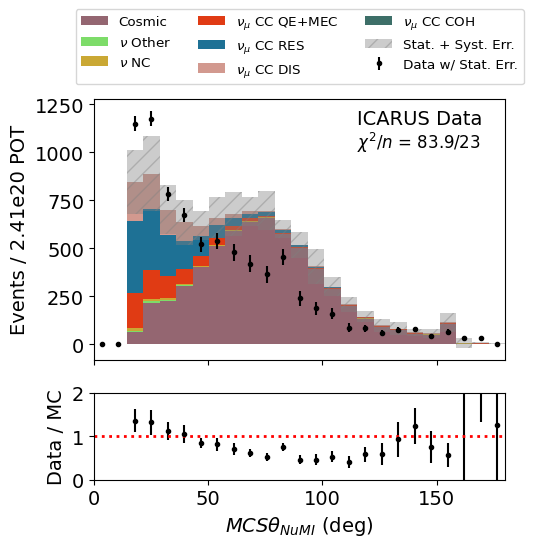

In [13]:
# 24/05/01 - includes central value weights. (May 1st.)

makeplot(evtdf, evtdf.Snumi_angle_mcs*180./math.pi,
         syst_evtdfs, [sdf.Snumi_angle_mcs*180./math.pi for sdf in syst_evtdfs],
         (0,180.), xlabel = "$MCS \\theta_{NuMI}$ (deg)", detailed_mc="int_type",
         ratio_bounds=[0.,2.], plotname='theta_NuMI_full_sb') # vline=NuMI_angle_thresh, # vline=[92.4]



In [27]:
inWeirdBin_mask = (79.19999695<evtdf.Snumi_angle_mcs*180./math.pi) & (evtdf.Snumi_angle_mcs*180./math.pi<86.40000153)
bin_neighbor_low = (72.<evtdf.Snumi_angle_mcs*180./math.pi) & (evtdf.Snumi_angle_mcs*180./math.pi<79.19999695)
bin_neighbor_high = (86.40000153<evtdf.Snumi_angle_mcs*180./math.pi) & (evtdf.Snumi_angle_mcs*180./math.pi<93.59999847)

In [25]:
print(BEAMDIR)
print(np.linalg.norm(BEAMDIR))
for c in evtdf.columns: print(c)

[0.39431672 0.04210058 0.91800973]
1.0
('slc', 'is_clear_cosmic', '', '', '', '')
('slc', 'vertex', 'x', '', '', '')
('slc', 'vertex', 'y', '', '', '')
('slc', 'vertex', 'z', '', '', '')
('slc', 'self', '', '', '', '')
('slc', 'tmatch', 'eff', '', '', '')
('slc', 'tmatch', 'pur', '', '', '')
('slc', 'tmatch', 'idx', '', '', '')
('slc', 'producer', '', '', '', '')
('slc', 'nuid', 'crlongtrkdiry', '', '', '')
('slc', 'truth', 'E', '', '', '')
('slc', 'truth', 'bjorkenX', '', '', '')
('slc', 'truth', 'inelasticityY', '', '', '')
('slc', 'truth', 'Q2', '', '', '')
('slc', 'truth', 'w', '', '', '')
('slc', 'truth', 'momentum', 'x', '', '')
('slc', 'truth', 'momentum', 'y', '', '')
('slc', 'truth', 'momentum', 'z', '', '')
('slc', 'truth', 'position', 'x', '', '')
('slc', 'truth', 'position', 'y', '', '')
('slc', 'truth', 'position', 'z', '', '')
('slc', 'truth', 'pdg', '', '', '')
('slc', 'truth', 'iscc', '', '', '')
('slc', 'truth', 'genie_mode', '', '', '')
('slc', 'truth', 'parent_pdg', 

Notable values of theta_NuMI:
Boundaries of weird bin: [79.19999695, 86.40000153]
BEAMDIR with vertical coming down:  92.41289879352504
BEAMDIR with vertical going up:  87.58710120647494
BEAMDIR with ABSORBDIR:  45.19008206080911
BEAMDIR with unit vector hybrids: 91.35038515154604
DATA EVENTS IN PLOT (w/ Normalization):  1143.9544575767254
MC EVENTS IN PLOT (w/ Normalization):  2055.621606503711
DATA/MC IN PLOT (w/ Normalization):  0.5565005027955569
bin boundaries:
[75. 76. 77. 78. 79. 80. 81. 82. 83. 84. 85. 86. 87. 88. 89. 90. 91. 92.
 93. 94. 95. 96. 97. 98. 99.]
chi2 over n = 1.5788514097442032


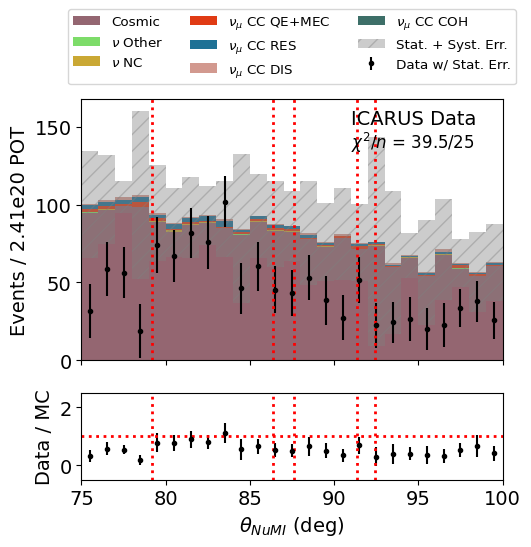

DATA EVENTS IN PLOT (w/ Normalization):  527.4638665914847
MC EVENTS IN PLOT (w/ Normalization):  648.754447757151
DATA/MC IN PLOT (w/ Normalization):  0.8130408483749323
bin boundaries:
[79.19999695 79.48799896 79.77600098 80.06399536 80.35199738 80.63999939
 80.9280014  81.21599579 81.5039978  81.79199982 82.08000183 82.36799622
 82.65599823 82.94400024 83.23200226 83.51999664 83.80799866 84.09600067
 84.38400269 84.67199707 84.95999908 85.2480011  85.53600311 85.8239975
 86.11199951]
chi2 over n = 0.4356170532823047


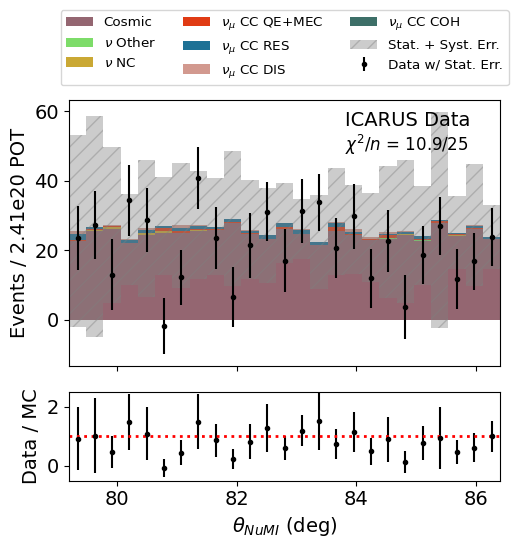

In [26]:
# Investigate: What is causing the bump in data??

print('Notable values of theta_NuMI:')

print('Boundaries of weird bin: [79.19999695, 86.40000153]', )

# Does it match the angle made from straight vertical downward tracks? (cosmics?)
vert_NuMI_angle = angle_between_vecs(np.array([0,-1,0]), BEAMDIR, deg=True)
print('BEAMDIR with vertical coming down: ', vert_NuMI_angle)

print('BEAMDIR with vertical going up: ', angle_between_vecs(np.array([0,1,0]), BEAMDIR, deg=True))

print('BEAMDIR with ABSORBDIR: ', angle_between_vecs(ABSORBDIR, BEAMDIR, deg=True))

# What reconstructed Scalar Direction would you get from two tracks where one is a vertical cosmic 
#    and the other is actually coming from NuMI physics?
# Call this 'hybrid'
# ~
# Assume same magnitude of reconstructed momentum for the two tracks:
hybrid_parent_dir = BEAMDIR+np.array([0.,-1.,0.])
print('BEAMDIR with unit vector hybrids:', angle_between_vecs(ABSORBDIR, hybrid_parent_dir, deg=True))

# Statistical fluke?
makeplot(evtdf, evtdf.Snumi_angle_mcs*180./math.pi,
         syst_evtdfs, [sdf.Snumi_angle_mcs*180./math.pi for sdf in syst_evtdfs],
         (75,100.), xlabel = "$\\theta_{NuMI}$ (deg)", detailed_mc="int_type",
         ratio_bounds=[-0.5,2.5], vline=[79.19999695, 86.40000153, 87.59, vert_NuMI_angle, 91.35]) # xs=[80,1000],

makeplot(evtdf, evtdf.Snumi_angle_mcs*180./math.pi,
         syst_evtdfs, [sdf.Snumi_angle_mcs*180./math.pi for sdf in syst_evtdfs],
         (79.19999695, 86.40000153), xlabel = "$\\theta_{NuMI}$ (deg)", detailed_mc="int_type",
         ratio_bounds=[-0.5,2.5])


In [ ]:
# Plot energy spectra



In [26]:
for c in evtdf.columns:
    print(c)

('slc', 'is_clear_cosmic', '', '', '', '')
('slc', 'vertex', 'x', '', '', '')
('slc', 'vertex', 'y', '', '', '')
('slc', 'vertex', 'z', '', '', '')
('slc', 'self', '', '', '', '')
('slc', 'tmatch', 'eff', '', '', '')
('slc', 'tmatch', 'pur', '', '', '')
('slc', 'tmatch', 'idx', '', '', '')
('slc', 'producer', '', '', '', '')
('slc', 'nuid', 'crlongtrkdiry', '', '', '')
('slc', 'truth', 'E', '', '', '')
('slc', 'truth', 'bjorkenX', '', '', '')
('slc', 'truth', 'inelasticityY', '', '', '')
('slc', 'truth', 'Q2', '', '', '')
('slc', 'truth', 'w', '', '', '')
('slc', 'truth', 'momentum', 'x', '', '')
('slc', 'truth', 'momentum', 'y', '', '')
('slc', 'truth', 'momentum', 'z', '', '')
('slc', 'truth', 'position', 'x', '', '')
('slc', 'truth', 'position', 'y', '', '')
('slc', 'truth', 'position', 'z', '', '')
('slc', 'truth', 'pdg', '', '', '')
('slc', 'truth', 'iscc', '', '', '')
('slc', 'truth', 'genie_mode', '', '', '')
('slc', 'truth', 'parent_pdg', '', '', '')
('slc', 'truth', 'parent_dc

DATA EVENTS IN PLOT (w/ Normalization):  7717.669013933048
MC EVENTS IN PLOT (w/ Normalization):  9039.568761847473
DATA/MC IN PLOT (w/ Normalization):  0.8537651758905078
bin boundaries:
[  0.           7.19999981  14.39999962  21.60000038  28.79999924
  36.          43.20000076  50.40000153  57.59999847  64.80000305
  72.          79.19999695  86.40000153  93.59999847 100.80000305
 108.         115.19999695 122.40000153 129.6000061  136.80000305
 144.         151.19999695 158.3999939  165.6000061  172.80000305]
chi2 over n = 1.9446285415212323


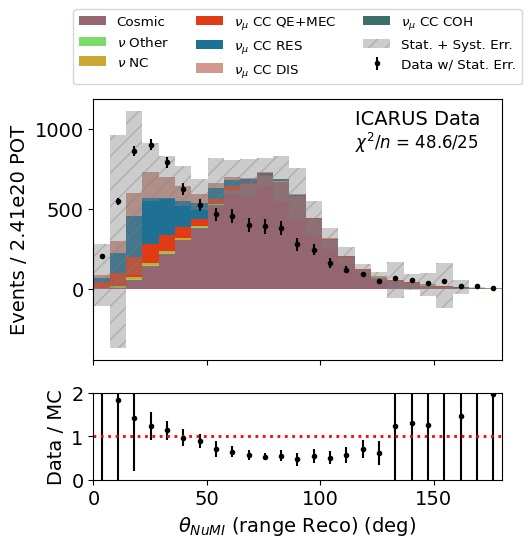

DATA EVENTS IN PLOT (w/ Normalization):  7717.669013933046
MC EVENTS IN PLOT (w/ Normalization):  9039.568761847488
DATA/MC IN PLOT (w/ Normalization):  0.8537651758905063
bin boundaries:
[  0.           7.19999981  14.39999962  21.60000038  28.79999924
  36.          43.20000076  50.40000153  57.59999847  64.80000305
  72.          79.19999695  86.40000153  93.59999847 100.80000305
 108.         115.19999695 122.40000153 129.6000061  136.80000305
 144.         151.19999695 158.3999939  165.6000061  172.80000305]
chi2 over n = 1.3855853951426929


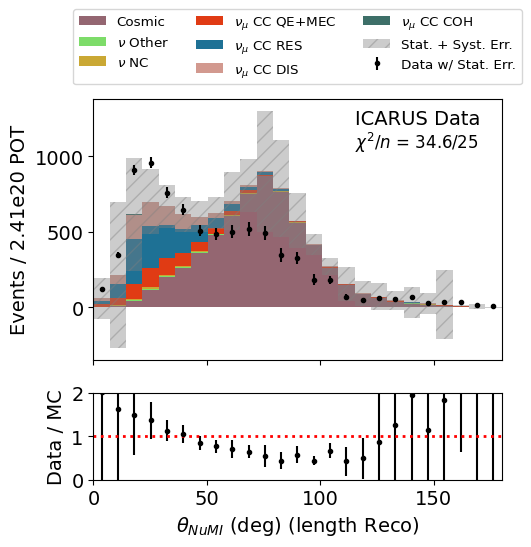

DATA EVENTS IN PLOT (w/ Normalization):  7717.669013933057
MC EVENTS IN PLOT (w/ Normalization):  9039.568761847459
DATA/MC IN PLOT (w/ Normalization):  0.8537651758905102
bin boundaries:
[  0.           7.19999981  14.39999962  21.60000038  28.79999924
  36.          43.20000076  50.40000153  57.59999847  64.80000305
  72.          79.19999695  86.40000153  93.59999847 100.80000305
 108.         115.19999695 122.40000153 129.6000061  136.80000305
 144.         151.19999695 158.3999939  165.6000061  172.80000305]
chi2 over n = 0.323524252039808


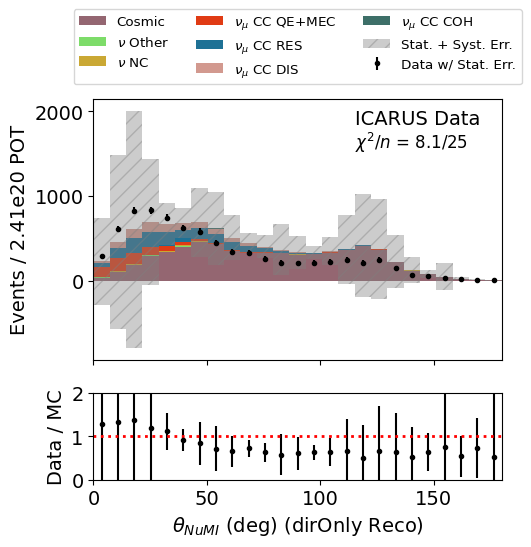

In [26]:
# Bump still there with funky versions of theta_NuMI?
makeplot(evtdf, evtdf.Snumi_angle_range*180./math.pi,
         syst_evtdfs, [sdf.Snumi_angle_mcs*180./math.pi for sdf in syst_evtdfs],
         (0,180.), xlabel = "$\\theta_{NuMI}$ (range Reco) (deg)", detailed_mc="int_type",
         ratio_bounds=[0.,2.], plotname='theta_NuMI_range_full_sb') # vline=NuMI_angle_thresh, # vline=[92.4]

makeplot(evtdf, evtdf.Snumi_angle_len*180./math.pi,
         syst_evtdfs, [sdf.Snumi_angle_mcs*180./math.pi for sdf in syst_evtdfs],
         (0,180.), xlabel = "$\\theta_{NuMI}$ (deg) (length Reco)", detailed_mc="int_type",
         ratio_bounds=[0.,2.], plotname='theta_NuMI_len_full_sb') # vline=NuMI_angle_thresh, # vline=[92.4]

makeplot(evtdf, evtdf.Snumi_angle_dirOnly*180./math.pi,
         syst_evtdfs, [sdf.Snumi_angle_mcs*180./math.pi for sdf in syst_evtdfs],
         (0,180.), xlabel = "$\\theta_{NuMI}$ (deg) (dirOnly Reco)", detailed_mc="int_type",
         ratio_bounds=[0.,2.], plotname='theta_NuMI_dirOnly_full_sb') # vline=NuMI_angle_thresh, # vline=[92.4]



-0.8833512663841248, 0.9703555703163147
-0.8850143551826477, 0.9308348894119263


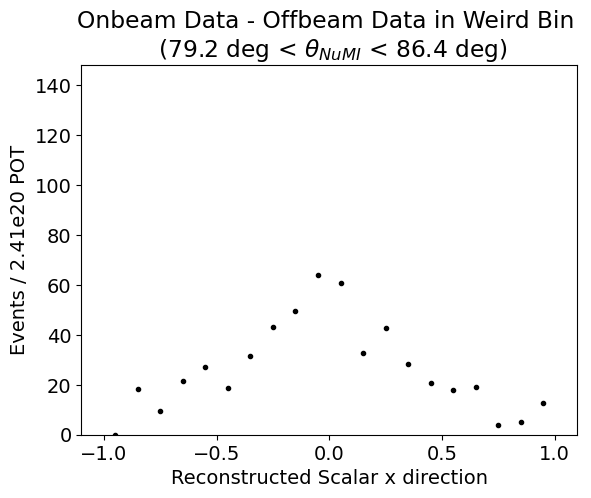

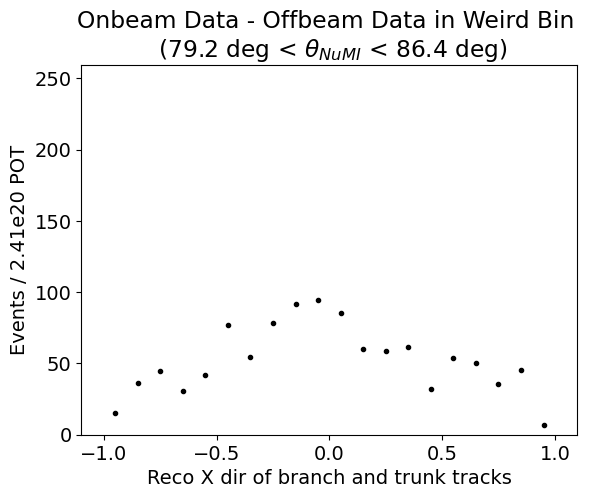

-0.9938739538192749, 0.9997175931930542
-0.9929150938987732, 0.9996799230575562


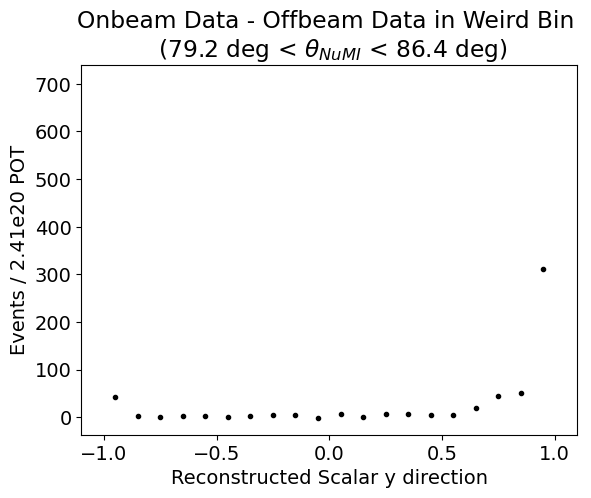

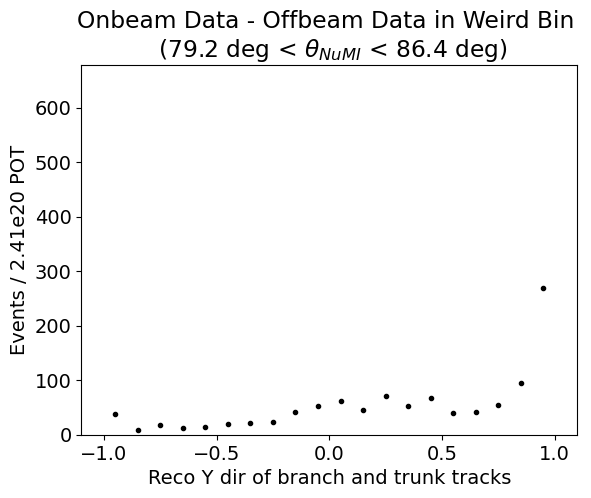

-0.31941676139831543, 0.5486921072006226
-0.3173828721046448, 0.5231768488883972


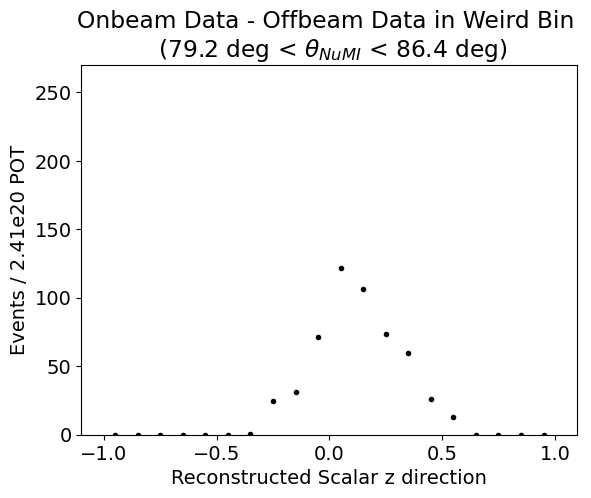

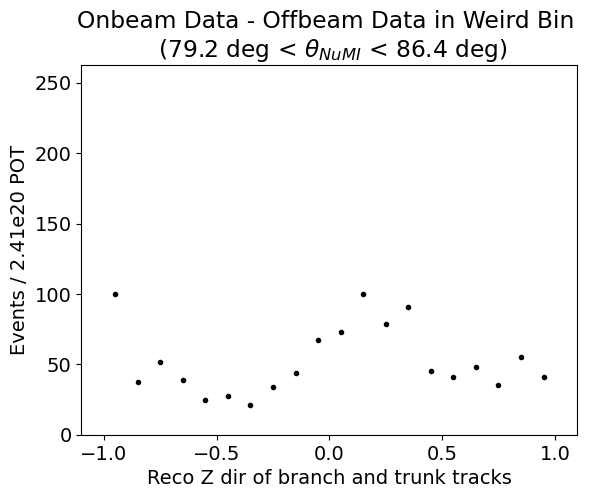

In [25]:
# What are the x,y,z directions of events in that bin?

df = evtdf[inWeirdBin_mask]
scale = df.scale.copy()
categories = make_categories(df, detailed_mc='int_type')
bins = 20
myrange = (-1,1)

# onbeam
on_trunk_mom = df[categories[-2]].trunk.trk.mcsP.fwdP_muon
on_trunk_dir = df[categories[-2]].trunk.trk.dir
on_branch_mom = df[categories[-2]].branch.trk.mcsP.fwdP_muon
on_branch_dir = df[categories[-2]].branch.trk.dir
on_scalar_mom = on_trunk_dir.multiply(on_trunk_mom, axis=0) + on_branch_dir.multiply(on_branch_mom, axis=0)    
on_scalar_dir = on_scalar_mom.divide(magdf(on_scalar_mom), axis=0)
# offbeam
off_trunk_mom = df[categories[-1]].trunk.trk.mcsP.fwdP_muon
off_trunk_dir = df[categories[-1]].trunk.trk.dir
off_branch_mom = df[categories[-1]].branch.trk.mcsP.fwdP_muon
off_branch_dir = df[categories[-1]].branch.trk.dir
off_scalar_mom = off_trunk_dir.multiply(off_trunk_mom, axis=0) + off_branch_dir.multiply(off_branch_mom, axis=0)    
off_scalar_dir = off_scalar_mom.divide(magdf(off_scalar_mom), axis=0)
    
for direction in range(3):
    if direction == 0:
        on_var = on_scalar_dir.x
        off_var = off_scalar_dir.x
    elif direction == 1:
        on_var = on_scalar_dir.y
        off_var = off_scalar_dir.y
    elif direction ==2: 
        on_var = on_scalar_dir.z
        off_var = off_scalar_dir.z
    print(min(on_var), max(on_var), sep=', ')
    on_data = plt.hist(on_var, weights = scale[categories[-2]], bins=bins, alpha=0, range=myrange)
    bin_centers = 0.5*(on_data[1][1:] + on_data[1][:-1])
    print(min(off_var), max(off_var), sep=', ')
    off_data = plt.hist(off_var, weights = scale[categories[-1]], bins=bins, alpha=0, range=myrange)
    # Combine on- and off-beam distributions:
    data = np.array(on_data[0]-off_data[0])
    plt.errorbar(bin_centers, data, marker = '.', 
                 yerr = [0]*data.shape[0], 
                 color='black', ls='none') 
    if direction == 0:
        plt.xlabel("Reconstructed Scalar x direction")
    elif direction == 1:
        plt.xlabel("Reconstructed Scalar y direction")
    elif direction ==2: 
        plt.xlabel("Reconstructed Scalar z direction")
    plt.ylabel("Events / %s" % POTSTR)
    plt.title('Onbeam Data - Offbeam Data in Weird Bin \n (79.2 deg < $\\theta_{NuMI}$ < 86.4 deg)')
    plt.show()
    
    # Check directions of individual tracks:
    if direction == 0:
        on_var = pd.concat([on_trunk_dir.x, on_branch_dir.x])
        off_var = pd.concat([off_trunk_dir.x, off_branch_dir.x])
    elif direction == 1:
        on_var = pd.concat([on_trunk_dir.y, on_branch_dir.y])
        off_var = pd.concat([off_trunk_dir.y, off_branch_dir.y])
    elif direction ==2: 
        on_var = pd.concat([on_trunk_dir.z, on_branch_dir.z])
        off_var = pd.concat([off_trunk_dir.z, off_branch_dir.z])
    weights = pd.concat([scale[categories[-2]], scale[categories[-2]]])
    on_data = plt.hist(on_var, weights = weights, bins=bins, alpha=0, range=myrange)
    weights = pd.concat([scale[categories[-1]], scale[categories[-1]]])
    off_data = plt.hist(off_var, weights = weights, bins=bins, alpha=0, range=myrange)
    data = np.array(on_data[0]-off_data[0])
    bin_centers = 0.5*(on_data[1][1:] + on_data[1][:-1])
    plt.errorbar(bin_centers, data, marker = '.', 
                 yerr = [0]*data.shape[0], 
                 color='black', ls='none') 
    if direction == 0:
        plt.xlabel("Reco X dir of branch and trunk tracks")
    elif direction == 1:
        plt.xlabel("Reco Y dir of branch and trunk tracks")
    elif direction ==2: 
        plt.xlabel("Reco Z dir of branch and trunk tracks")
    plt.ylabel("Events / %s" % POTSTR)
    plt.title('Onbeam Data - Offbeam Data in Weird Bin \n (79.2 deg < $\\theta_{NuMI}$ < 86.4 deg)')
    plt.show()

In [101]:
evtdf.evt_from_hdr

sample  __ntuple  entry  rec.slc..index
0       1         50     8                            21.0
Name: (1, 50), dtype: float64
                  73     3                            15.0
Name: (1, 73), dtype: float64
        5         1      2                              2.0
Name: (5, 1), dtype: float64
                  16     11                           17.0
Name: (5, 16), dtype: float64
                  82     0                            23.0
Name: (5, 82), dtype: float64
                                                               ...                      
3       2350      165    16                    12503.0
Name: (2350, 165), dtype: float64
        2351      2      24                      10237.0
Name: (2351, 2), dtype: float64
                  10     16                     10741.0
Name: (2351, 10), dtype: float64
                  15     0                      11341.0
Name: (2351, 15), dtype: float64
                  151    16                    59751.0
Name: (2351, 15

In [99]:
for c in hdrs[-2].columns:
    print(c)
print(np.unique(np.array(hdrs[-2].fno)))
print(np.unique(np.array(hdrs[-2].ngenevt)))
hdrs[-2].evt

('pot', '')
('first_in_subrun', '')
('ismc', '')
('run', '')
('subrun', '')
('ngenevt', '')
('evt', '')
('proc', '')
('cluster', '')
('fno', '')
('triggerinfo', 'trigger_id')
('triggerinfo', 'gate_id')
('triggerinfo', 'trigger_count')
('triggerinfo', 'gate_count')
('triggerinfo', 'gate_delta')
('triggerinfo', 'global_trigger_time')
('triggerinfo', 'prev_global_trigger_time')
[0 1 2 3 4]
[0]


__ntuple  entry
16        0         68219
          1         68267
          2         68339
          3         68375
          4         68387
                    ...  
3756      235      123987
          236      124071
          237      124095
          238      124107
          239      124119
Name: evt, Length: 1059268, dtype: uint32

In [27]:
for c in evtdf.columns:
    print(c)

('slc', 'is_clear_cosmic', '', '', '', '')
('slc', 'vertex', 'x', '', '', '')
('slc', 'vertex', 'y', '', '', '')
('slc', 'vertex', 'z', '', '', '')
('slc', 'self', '', '', '', '')
('slc', 'tmatch', 'eff', '', '', '')
('slc', 'tmatch', 'pur', '', '', '')
('slc', 'tmatch', 'idx', '', '', '')
('slc', 'producer', '', '', '', '')
('slc', 'nuid', 'crlongtrkdiry', '', '', '')
('slc', 'truth', 'E', '', '', '')
('slc', 'truth', 'bjorkenX', '', '', '')
('slc', 'truth', 'inelasticityY', '', '', '')
('slc', 'truth', 'Q2', '', '', '')
('slc', 'truth', 'w', '', '', '')
('slc', 'truth', 'momentum', 'x', '', '')
('slc', 'truth', 'momentum', 'y', '', '')
('slc', 'truth', 'momentum', 'z', '', '')
('slc', 'truth', 'position', 'x', '', '')
('slc', 'truth', 'position', 'y', '', '')
('slc', 'truth', 'position', 'z', '', '')
('slc', 'truth', 'pdg', '', '', '')
('slc', 'truth', 'iscc', '', '', '')
('slc', 'truth', 'genie_mode', '', '', '')
('slc', 'truth', 'parent_pdg', '', '', '')
('slc', 'truth', 'parent_dc

In [29]:
# Extract info needed for event display:

df = evtdf[inWeirdBin_mask]
scale = df.scale.copy()
categories = make_categories(df, detailed_mc='int_type')
mydf = df[categories[-2]]
print(categories[-2].name, ', [daqrun, cluster, process, evt_from_hdr, evt]:')
for idx in mydf.index:
    address = [int(mydf.loc[idx]['daqrun']), int(mydf.loc[idx]['cluster']), int(mydf.loc[idx]['proc']), 
               int(mydf.loc[idx]['evt_from_hdr']), idx[2]]
    if int(mydf.loc[idx]['Run1']) == 1:
        run = 'Run 1'
    else: run = 'Run 2'
    print(idx, ': ', address, ' ', run)
    print('slc vtx:')
    print(mydf.loc[idx].slc.vertex)
    print('trunk dir:')
    print(mydf.loc[idx].trunk.trk.dir)
    print('branch dir:')
    print(mydf.loc[idx].branch.trk.dir)
# (2, 9, 89, 3) : [8469, 66029758, 4, 77586, 89] Run 1 


Onbeam Data , [daqrun, cluster, process, evt_from_hdr, evt]:
(2, 7, 159, 8) :  [8530, 66029758, 15, 23047, 159]   Run 1
slc vtx:
x            168.1633
y           -5.035187
z          271.841034
Name: (2, 7, 159, 8), dtype: object
trunk dir:
x       -0.521944
y        0.758247
z        0.390687
Name: (2, 7, 159, 8), dtype: object
branch dir:
x        0.780414
y        0.454845
z       -0.429033
Name: (2, 7, 159, 8), dtype: object
(2, 9, 46, 15) :  [8507, 66029758, 4, 49058, 46]   Run 1
slc vtx:
x          333.441803
y          -80.234558
z          666.852417
Name: (2, 9, 46, 15), dtype: object
trunk dir:
x       -0.390104
y        0.890955
z        -0.23242
Name: (2, 9, 46, 15), dtype: object
branch dir:
x         0.02481
y         0.60221
z        0.797952
Name: (2, 9, 46, 15), dtype: object
(2, 9, 89, 3) :  [8469, 66029758, 4, 77586, 89]   Run 1
slc vtx:
x         -333.151001
y           42.420715
z         -422.012085
Name: (2, 9, 89, 3), dtype: object
trunk dir:
x        0.206785


x         -204.261719
y          -29.798218
z         -684.941528
Name: (2, 121, 31, 0), dtype: object
trunk dir:
x        0.129577
y       -0.990568
z        0.044556
Name: (2, 121, 31, 0), dtype: object
branch dir:
x       -0.100265
y        0.409198
z         0.90692
Name: (2, 121, 31, 0), dtype: object
(2, 129, 65, 1) :  [8530, 66029758, 131, 88325, 65]   Run 1
slc vtx:
x         -279.619049
y           119.74585
z          738.967834
Name: (2, 129, 65, 1), dtype: object
trunk dir:
x         0.08493
y       -0.989905
z        0.113464
Name: (2, 129, 65, 1), dtype: object
branch dir:
x        -0.05301
y        0.310452
z        -0.94911
Name: (2, 129, 65, 1), dtype: object
(2, 129, 184, 1) :  [8528, 66029758, 131, 17767, 184]   Run 1
slc vtx:
x         -129.952621
y          -51.209976
z          144.411087
Name: (2, 129, 184, 1), dtype: object
trunk dir:
x       -0.576021
y        0.790087
z        0.209672
Name: (2, 129, 184, 1), dtype: object
branch dir:
x        0.138873
y      

(2, 231, 39, 2) :  [8553, 66029758, 236, 20316, 39]   Run 1
slc vtx:
x         -192.984238
y          -95.245209
z          -595.03717
Name: (2, 231, 39, 2), dtype: object
trunk dir:
x       -0.804735
y        0.545198
z        0.234864
Name: (2, 231, 39, 2), dtype: object
branch dir:
x        0.415306
y        0.090184
z        0.905201
Name: (2, 231, 39, 2), dtype: object
(2, 229, 65, 0) :  [8530, 66029758, 234, 51911, 65]   Run 1
slc vtx:
x         -229.411896
y           12.797638
z         -344.307312
Name: (2, 229, 65, 0), dtype: object
trunk dir:
x       -0.576499
y        0.816958
z        0.015106
Name: (2, 229, 65, 0), dtype: object
branch dir:
x        0.603864
y        0.140581
z        0.784593
Name: (2, 229, 65, 0), dtype: object
(2, 240, 146, 13) :  [8553, 66029758, 245, 29929, 146]   Run 1
slc vtx:
x          312.794739
y           85.164093
z          389.887756
Name: (2, 240, 146, 13), dtype: object
trunk dir:
x       -0.254154
y       -0.933728
z        0.252109
Name

x        0.193785
y        -0.07027
z       -0.978524
Name: (2, 327, 147, 1), dtype: object
(2, 335, 77, 10) :  [8505, 66029758, 340, 13647, 77]   Run 1
slc vtx:
x          240.897552
y           -91.13324
z          748.796631
Name: (2, 335, 77, 10), dtype: object
trunk dir:
x       -0.050932
y       -0.091794
z       -0.994475
Name: (2, 335, 77, 10), dtype: object
branch dir:
x        0.083788
y        0.947276
z        0.309271
Name: (2, 335, 77, 10), dtype: object
(2, 334, 14, 19) :  [8515, 66029758, 339, 83469, 14]   Run 1
slc vtx:
x          201.386505
y         -140.425598
z         -832.918579
Name: (2, 334, 14, 19), dtype: object
trunk dir:
x       -0.122193
y        0.987581
z        0.098755
Name: (2, 334, 14, 19), dtype: object
branch dir:
x         0.24103
y       -0.391728
z        0.887949
Name: (2, 334, 14, 19), dtype: object
(2, 330, 139, 24) :  [8515, 66029758, 335, 107642, 139]   Run 1
slc vtx:
x          104.701645
y          -63.503628
z          -75.841301
Name: (

x       -0.296868
y        0.873094
z         0.38675
Name: (2, 429, 202, 3), dtype: object
branch dir:
x        0.107939
y        0.084874
z       -0.990528
Name: (2, 429, 202, 3), dtype: object
(2, 430, 239, 20) :  [8552, 66029758, 438, 50119, 239]   Run 1
slc vtx:
x          201.315872
y          -18.498077
z          318.651459
Name: (2, 430, 239, 20), dtype: object
trunk dir:
x       -0.665444
y        0.634135
z        0.393773
Name: (2, 430, 239, 20), dtype: object
branch dir:
x       -0.287976
y       -0.356556
z       -0.888784
Name: (2, 430, 239, 20), dtype: object
(2, 442, 217, 15) :  [8505, 66029758, 450, 7758, 217]   Run 1
slc vtx:
x          299.442291
y            0.957458
z         -355.341888
Name: (2, 442, 217, 15), dtype: object
trunk dir:
x        0.429114
y        0.895963
z       -0.114504
Name: (2, 442, 217, 15), dtype: object
branch dir:
x       -0.791272
y        0.565543
z        0.232487
Name: (2, 442, 217, 15), dtype: object
(2, 460, 75, 0) :  [8505, 6602975

(2, 547, 122, 21) :  [8469, 66029758, 557, 41749, 122]   Run 1
slc vtx:
x          327.961884
y          104.438736
z           49.674175
Name: (2, 547, 122, 21), dtype: object
trunk dir:
x       -0.132049
y       -0.970792
z        0.200317
Name: (2, 547, 122, 21), dtype: object
branch dir:
x       -0.859841
y       -0.311664
z         -0.4044
Name: (2, 547, 122, 21), dtype: object
(2, 550, 174, 1) :  [8552, 66029758, 560, 56306, 174]   Run 1
slc vtx:
x         -131.869019
y            1.106079
z         -668.277222
Name: (2, 550, 174, 1), dtype: object
trunk dir:
x        0.447224
y        0.490145
z       -0.748164
Name: (2, 550, 174, 1), dtype: object
branch dir:
x       -0.343977
y        0.833888
z        0.431638
Name: (2, 550, 174, 1), dtype: object
(2, 555, 182, 3) :  [8505, 66029758, 565, 143563, 182]   Run 1
slc vtx:
x         -308.167542
y           83.123901
z         -456.095581
Name: (2, 555, 182, 3), dtype: object
trunk dir:
x        0.751263
y         0.64092
z        

x        -0.65117
y       -0.369179
z        0.663087
Name: (2, 680, 231, 9), dtype: object
(2, 690, 66, 0) :  [8515, 66029758, 701, 46334, 66]   Run 1
slc vtx:
x         -149.606277
y          -14.897278
z          -762.76593
Name: (2, 690, 66, 0), dtype: object
trunk dir:
x       -0.671046
y        0.622988
z        0.401975
Name: (2, 690, 66, 0), dtype: object
branch dir:
x       -0.555133
y        -0.69049
z        0.463735
Name: (2, 690, 66, 0), dtype: object
(2, 690, 136, 33) :  [8529, 66029758, 701, 19646, 136]   Run 1
slc vtx:
x          265.311584
y           46.562344
z           25.696388
Name: (2, 690, 136, 33), dtype: object
trunk dir:
x        0.603184
y        0.735154
z        0.309382
Name: (2, 690, 136, 33), dtype: object
branch dir:
x       -0.161743
y        0.715761
z       -0.679357
Name: (2, 690, 136, 33), dtype: object
(2, 700, 61, 19) :  [8471, 66029758, 711, 1547, 61]   Run 1
slc vtx:
x          275.312805
y           79.106422
z          115.386955
Name: (2, 

x          267.493317
y           83.705261
z          647.423584
Name: (2, 19, 155, 15), dtype: object
trunk dir:
x        0.767924
y        -0.12193
z        0.628829
Name: (2, 19, 155, 15), dtype: object
branch dir:
x        0.018372
y       -0.608426
z       -0.793398
Name: (2, 19, 155, 15), dtype: object
(2, 8, 3, 2) :  [9984, 66385304, 2, 12766, 3]   Run 2
slc vtx:
x         -339.750488
y           56.824036
z         -807.659302
Name: (2, 8, 3, 2), dtype: object
trunk dir:
x        0.624645
y         -0.2918
z        0.724342
Name: (2, 8, 3, 2), dtype: object
branch dir:
x        0.570892
y        0.666855
z       -0.478943
Name: (2, 8, 3, 2), dtype: object
(2, 7, 134, 19) :  [9731, 66385304, 6, 70861, 134]   Run 2
slc vtx:
x           246.23735
y         -144.667725
z          778.836853
Name: (2, 7, 134, 19), dtype: object
trunk dir:
x        0.251821
y        0.838885
z        0.482554
Name: (2, 7, 134, 19), dtype: object
branch dir:
x        -0.90003
y        0.082119
z     

x       -0.359068
y        0.922451
z        0.141967
Name: (2, 139, 225, 0), dtype: object
branch dir:
x       -0.117374
y        0.049554
z        0.991851
Name: (2, 139, 225, 0), dtype: object
(2, 143, 4, 17) :  [9796, 66385304, 144, 93165, 4]   Run 2
slc vtx:
x          101.882515
y          -50.062012
z          692.204834
Name: (2, 143, 4, 17), dtype: object
trunk dir:
x       -0.207954
y         0.95488
z        0.212036
Name: (2, 143, 4, 17), dtype: object
branch dir:
x       -0.847417
y       -0.470927
z         0.24518
Name: (2, 143, 4, 17), dtype: object
(2, 151, 73, 19) :  [9960, 66385304, 152, 45274, 73]   Run 2
slc vtx:
x          152.930954
y          -91.732605
z         -641.173889
Name: (2, 151, 73, 19), dtype: object
trunk dir:
x       -0.482226
y        0.812275
z        0.328127
Name: (2, 151, 73, 19), dtype: object
branch dir:
x        0.389313
y        0.718896
z       -0.575868
Name: (2, 151, 73, 19), dtype: object
(2, 154, 99, 0) :  [9965, 66385304, 155, 4932, 

(2, 284, 112, 2) :  [9597, 66385304, 286, 3418, 112]   Run 2
slc vtx:
x         -254.973389
y              38.237
z           634.85083
Name: (2, 284, 112, 2), dtype: object
trunk dir:
x       -0.626662
y        0.338405
z       -0.701981
Name: (2, 284, 112, 2), dtype: object
branch dir:
x        0.568709
y        0.809489
z        0.145935
Name: (2, 284, 112, 2), dtype: object
(2, 284, 235, 1) :  [9700, 66385304, 286, 27139, 235]   Run 2
slc vtx:
x         -307.160309
y           119.64991
z         -184.127045
Name: (2, 284, 235, 1), dtype: object
trunk dir:
x        0.036194
y        -0.97782
z        0.206298
Name: (2, 284, 235, 1), dtype: object
branch dir:
x        0.004852
y        0.001938
z       -0.999986
Name: (2, 284, 235, 1), dtype: object
(2, 291, 138, 0) :  [9870, 66385304, 293, 4661, 138]   Run 2
slc vtx:
x         -156.894531
y            1.884949
z         -525.708374
Name: (2, 291, 138, 0), dtype: object
trunk dir:
x        0.791178
y        0.604686
z        0.09161

x         -86.915634
y           0.532609
z          12.109039
Name: (2, 418, 45, 0), dtype: object
trunk dir:
x        0.077576
y       -0.974264
z        0.211641
Name: (2, 418, 45, 0), dtype: object
branch dir:
x       -0.124268
y       -0.070888
z       -0.989713
Name: (2, 418, 45, 0), dtype: object
(2, 411, 202, 0) :  [9796, 66385304, 413, 108234, 202]   Run 2
slc vtx:
x          -98.925575
y          -26.702057
z         -264.086487
Name: (2, 411, 202, 0), dtype: object
trunk dir:
x        0.352952
y         0.90607
z        0.233369
Name: (2, 411, 202, 0), dtype: object
branch dir:
x       -0.775535
y        0.086382
z       -0.625366
Name: (2, 411, 202, 0), dtype: object
(2, 421, 75, 1) :  [9744, 66385304, 423, 40054, 75]   Run 2
slc vtx:
x         -254.661255
y          -54.246765
z         -835.747375
Name: (2, 421, 75, 1), dtype: object
trunk dir:
x       -0.359085
y        0.923604
z        0.134216
Name: (2, 421, 75, 1), dtype: object
branch dir:
x       -0.141355
y       

(2, 512, 153, 0) :  [9894, 66385304, 514, 34717, 153]   Run 2
slc vtx:
x         -300.048492
y         -115.345276
z         -572.237488
Name: (2, 512, 153, 0), dtype: object
trunk dir:
x        0.240112
y        0.970739
z       -0.003601
Name: (2, 512, 153, 0), dtype: object
branch dir:
x        0.600433
y       -0.540435
z       -0.589416
Name: (2, 512, 153, 0), dtype: object
(2, 511, 210, 1) :  [9840, 66385304, 513, 16832, 210]   Run 2
slc vtx:
x         -158.438873
y            3.200928
z         -623.849792
Name: (2, 511, 210, 1), dtype: object
trunk dir:
x       -0.201431
y        0.979119
z        0.027405
Name: (2, 511, 210, 1), dtype: object
branch dir:
x        0.068724
y       -0.387822
z        0.919169
Name: (2, 511, 210, 1), dtype: object
(2, 518, 195, 19) :  [9595, 66385304, 520, 19277, 195]   Run 2
slc vtx:
x          166.275116
y          -14.547012
z          194.908142
Name: (2, 518, 195, 19), dtype: object
trunk dir:
x        0.376787
y        0.876701
z        0.2

x       -0.404464
y        0.829053
z        0.386108
Name: (2, 609, 93, 0), dtype: object
(2, 608, 34, 2) :  [9744, 66385304, 611, 12166, 34]   Run 2
slc vtx:
x         -321.824066
y            9.934601
z          325.631683
Name: (2, 608, 34, 2), dtype: object
trunk dir:
x         0.63604
y        0.767926
z        0.075774
Name: (2, 608, 34, 2), dtype: object
branch dir:
x         0.52145
y       -0.030248
z       -0.852746
Name: (2, 608, 34, 2), dtype: object
(2, 622, 188, 21) :  [9752, 66385304, 626, 5491, 188]   Run 2
slc vtx:
x          105.844627
y          -28.036682
z         -870.130493
Name: (2, 622, 188, 21), dtype: object
trunk dir:
x       -0.712232
y        0.457536
z        0.532341
Name: (2, 622, 188, 21), dtype: object
branch dir:
x        0.155777
y        0.949962
z       -0.270752
Name: (2, 622, 188, 21), dtype: object
(2, 623, 88, 25) :  [9593, 66385304, 627, 23055, 88]   Run 2
slc vtx:
x          202.689667
y          -17.271332
z          297.228424
Name: (2, 6

x          265.654266
y         -142.999939
z         -647.931946
Name: (2, 747, 220, 13), dtype: object
trunk dir:
x        0.756777
y        0.627397
z        0.183472
Name: (2, 747, 220, 13), dtype: object
branch dir:
x        -0.18828
y        0.284937
z       -0.939873
Name: (2, 747, 220, 13), dtype: object
(2, 749, 82, 1) :  [9807, 66385304, 753, 10943, 82]   Run 2
slc vtx:
x            -82.6744
y           -3.495056
z         -861.124084
Name: (2, 749, 82, 1), dtype: object
trunk dir:
x       -0.257834
y        0.868473
z        0.423411
Name: (2, 749, 82, 1), dtype: object
branch dir:
x       -0.460567
y        0.522499
z       -0.717546
Name: (2, 749, 82, 1), dtype: object
(2, 755, 28, 1) :  [9599, 66385304, 759, 53471, 28]   Run 2
slc vtx:
x         -239.270508
y          -45.117889
z          356.762268
Name: (2, 755, 28, 1), dtype: object
trunk dir:
x        0.092087
y        -0.99573
z        0.006531
Name: (2, 755, 28, 1), dtype: object
branch dir:
x       -0.481957
y    

(2, 868, 217, 1) :  [9704, 66385304, 872, 51127, 217]   Run 2
slc vtx:
x         -277.702423
y         -167.341064
z          309.215179
Name: (2, 868, 217, 1), dtype: object
trunk dir:
x       -0.837295
y        0.064284
z       -0.542959
Name: (2, 868, 217, 1), dtype: object
branch dir:
x        0.137635
y        0.973151
z         0.18448
Name: (2, 868, 217, 1), dtype: object
(2, 872, 60, 18) :  [9944, 66385304, 876, 8482, 60]   Run 2
slc vtx:
x           208.67305
y           -44.89241
z         -302.142792
Name: (2, 872, 60, 18), dtype: object
trunk dir:
x       -0.258858
y       -0.586146
z         0.76774
Name: (2, 872, 60, 18), dtype: object
branch dir:
x       -0.381518
y        0.896932
z        0.223512
Name: (2, 872, 60, 18), dtype: object
(2, 875, 58, 28) :  [9837, 66385304, 879, 125783, 58]   Run 2
slc vtx:
x          271.986511
y          -98.784195
z           -42.77113
Name: (2, 875, 58, 28), dtype: object
trunk dir:
x        0.392857
y       -0.266329
z       -0.88018

x       -0.430107
y        0.896225
z         0.10858
Name: (2, 989, 131, 15), dtype: object
(2, 991, 111, 12) :  [9725, 66385304, 995, 56846, 111]   Run 2
slc vtx:
x          281.392487
y          -12.497437
z          787.752869
Name: (2, 991, 111, 12), dtype: object
trunk dir:
x        0.339478
y        0.889585
z        0.305604
Name: (2, 991, 111, 12), dtype: object
branch dir:
x       -0.138304
y        0.143276
z       -0.979971
Name: (2, 991, 111, 12), dtype: object
(2, 996, 23, 2) :  [9960, 66385304, 1000, 46293, 23]   Run 2
slc vtx:
x         -214.936539
y         -104.750854
z          378.119934
Name: (2, 996, 23, 2), dtype: object
trunk dir:
x       -0.464142
y          0.8107
z        0.356842
Name: (2, 996, 23, 2), dtype: object
branch dir:
x       -0.272062
y       -0.119788
z       -0.954795
Name: (2, 996, 23, 2), dtype: object
(2, 1000, 127, 24) :  [9894, 66385304, 1004, 44718, 127]   Run 2
slc vtx:
x          138.931854
y          -76.081787
z          460.250488
Nam

x       -0.073929
y       -0.002544
z         0.99726
Name: (2, 1089, 30, 0), dtype: object
(2, 1092, 189, 1) :  [9974, 66385304, 1097, 28988, 189]   Run 2
slc vtx:
x         -314.092255
y          122.078827
z          540.563782
Name: (2, 1092, 189, 1), dtype: object
trunk dir:
x       -0.018768
y       -0.000389
z       -0.999824
Name: (2, 1092, 189, 1), dtype: object
branch dir:
x        0.043396
y       -0.985878
z        0.161743
Name: (2, 1092, 189, 1), dtype: object
(2, 1103, 123, 3) :  [9646, 66385304, 1108, 758, 123]   Run 2
slc vtx:
x          -256.28418
y          -13.916284
z         -845.420593
Name: (2, 1103, 123, 3), dtype: object
trunk dir:
x        0.009186
y         0.17214
z         0.98503
Name: (2, 1103, 123, 3), dtype: object
branch dir:
x        0.024979
y        0.966197
z       -0.256593
Name: (2, 1103, 123, 3), dtype: object
(2, 1105, 51, 1) :  [9729, 66385304, 1110, 42792, 51]   Run 2
slc vtx:
x         -225.107269
y          -47.078979
z          465.134369

x        0.016144
y        0.941681
z        0.336121
Name: (2, 1203, 23, 0), dtype: object
branch dir:
x       -0.022249
y        0.202634
z       -0.979002
Name: (2, 1203, 23, 0), dtype: object
(2, 1212, 225, 18) :  [9894, 66385304, 1218, 26636, 225]   Run 2
slc vtx:
x           89.563828
y           14.166748
z          523.017639
Name: (2, 1212, 225, 18), dtype: object
trunk dir:
x        0.714165
y       -0.157457
z       -0.682038
Name: (2, 1212, 225, 18), dtype: object
branch dir:
x        0.198693
y        0.964677
z        0.172974
Name: (2, 1212, 225, 18), dtype: object
(2, 1215, 238, 12) :  [9854, 66385304, 1221, 27437, 238]   Run 2
slc vtx:
x          130.716522
y           -97.96582
z          308.694366
Name: (2, 1215, 238, 12), dtype: object
trunk dir:
x        -0.70232
y       -0.051087
z        0.710026
Name: (2, 1215, 238, 12), dtype: object
branch dir:
x        0.218858
y        0.975301
z       -0.029816
Name: (2, 1215, 238, 12), dtype: object
(2, 1217, 35, 14) :  [

x         -182.908096
y          -155.22084
z           21.737558
Name: (2, 1312, 245, 0), dtype: object
trunk dir:
x        0.276671
y        0.933375
z        0.228615
Name: (2, 1312, 245, 0), dtype: object
branch dir:
x       -0.099701
y        0.000946
z       -0.995017
Name: (2, 1312, 245, 0), dtype: object
(2, 1313, 68, 1) :  [9745, 66385304, 1320, 40538, 68]   Run 2
slc vtx:
x         -280.070129
y            -37.3573
z          794.083496
Name: (2, 1313, 68, 1), dtype: object
trunk dir:
x       -0.283537
y        0.870757
z        0.401731
Name: (2, 1313, 68, 1), dtype: object
branch dir:
x       -0.768435
y        0.346272
z       -0.538148
Name: (2, 1313, 68, 1), dtype: object
(2, 1313, 94, 20) :  [9745, 66385304, 1320, 42086, 94]   Run 2
slc vtx:
x          168.803467
y         -135.724335
z          567.328613
Name: (2, 1313, 94, 20), dtype: object
trunk dir:
x       -0.141284
y        0.951876
z        0.271978
Name: (2, 1313, 94, 20), dtype: object
branch dir:
x        0.

x         -288.151886
y           22.682495
z          473.748199
Name: (2, 1391, 13, 0), dtype: object
trunk dir:
x        0.276277
y       -0.949655
z        0.147736
Name: (2, 1391, 13, 0), dtype: object
branch dir:
x        0.044739
y       -0.001244
z       -0.998998
Name: (2, 1391, 13, 0), dtype: object
(2, 1390, 152, 17) :  [9847, 66385304, 1398, 23419, 152]   Run 2
slc vtx:
x          309.413818
y          -54.658318
z          -64.339851
Name: (2, 1390, 152, 17), dtype: object
trunk dir:
x        0.330782
y         0.94246
z       -0.048516
Name: (2, 1390, 152, 17), dtype: object
branch dir:
x       -0.910756
y        0.209581
z        0.355808
Name: (2, 1390, 152, 17), dtype: object
(2, 1390, 209, 17) :  [9860, 66385304, 1398, 3656, 209]   Run 2
slc vtx:
x          208.963913
y           -3.113708
z         -617.299744
Name: (2, 1390, 209, 17), dtype: object
trunk dir:
x       -0.571127
y         0.74034
z        0.354557
Name: (2, 1390, 209, 17), dtype: object
branch dir:
x 

x       -0.762519
y        -0.52312
z        0.380672
Name: (2, 1472, 131, 18), dtype: object
branch dir:
x       -0.159568
y        0.526802
z        0.834876
Name: (2, 1472, 131, 18), dtype: object
(2, 1480, 80, 0) :  [9807, 66385304, 1488, 109285, 80]   Run 2
slc vtx:
x         -339.807007
y          113.824951
z          610.915283
Name: (2, 1480, 80, 0), dtype: object
trunk dir:
x        0.059113
y       -0.989507
z        0.131837
Name: (2, 1480, 80, 0), dtype: object
branch dir:
x       -0.029663
y            -0.0
z        -0.99956
Name: (2, 1480, 80, 0), dtype: object
(2, 1481, 177, 14) :  [9844, 66385304, 1489, 17461, 177]   Run 2
slc vtx:
x          145.625931
y           26.254555
z          -98.828735
Name: (2, 1481, 177, 14), dtype: object
trunk dir:
x        0.448334
y         0.86379
z         0.22992
Name: (2, 1481, 177, 14), dtype: object
branch dir:
x       -0.151566
y        0.641091
z        -0.75235
Name: (2, 1481, 177, 14), dtype: object
(2, 1485, 177, 1) :  [9746

x          190.823318
y           40.526855
z           528.95636
Name: (2, 1592, 142, 21), dtype: object
trunk dir:
x       -0.810099
y        0.529074
z        0.252627
Name: (2, 1592, 142, 21), dtype: object
branch dir:
x        -0.46082
y       -0.468781
z        0.753584
Name: (2, 1592, 142, 21), dtype: object
(2, 1596, 36, 21) :  [9960, 66385304, 1604, 11433, 36]   Run 2
slc vtx:
x          143.096558
y          -15.564331
z         -521.395264
Name: (2, 1596, 36, 21), dtype: object
trunk dir:
x        0.335559
y        0.390951
z        0.857063
Name: (2, 1596, 36, 21), dtype: object
branch dir:
x       -0.115456
y        0.983602
z       -0.138551
Name: (2, 1596, 36, 21), dtype: object
(2, 1601, 170, 2) :  [9695, 66385304, 1610, 23297, 170]   Run 2
slc vtx:
x         -297.176971
y           -13.87915
z         -833.691528
Name: (2, 1601, 170, 2), dtype: object
trunk dir:
x        0.213379
y        0.943563
z        0.253296
Name: (2, 1601, 170, 2), dtype: object
branch dir:
x  

x         0.33392
y        0.862395
z        0.380489
Name: (2, 1725, 152, 10), dtype: object
branch dir:
x        0.134865
y        0.574097
z       -0.807604
Name: (2, 1725, 152, 10), dtype: object
(2, 1724, 38, 1) :  [9649, 66385304, 1734, 9263, 38]   Run 2
slc vtx:
x           -72.11129
y            5.397842
z         -153.566772
Name: (2, 1724, 38, 1), dtype: object
trunk dir:
x       -0.406523
y        0.872407
z        0.271377
Name: (2, 1724, 38, 1), dtype: object
branch dir:
x        -0.85809
y       -0.416516
z        0.300325
Name: (2, 1724, 38, 1), dtype: object
(2, 1732, 176, 1) :  [9834, 66385304, 1742, 1841, 176]   Run 2
slc vtx:
x         -227.496338
y         -115.516632
z         -153.981552
Name: (2, 1732, 176, 1), dtype: object
trunk dir:
x       -0.190201
y          0.9817
z       -0.009415
Name: (2, 1732, 176, 1), dtype: object
branch dir:
x         0.94283
y       -0.148507
z        0.298357
Name: (2, 1732, 176, 1), dtype: object
(2, 1736, 90, 2) :  [9763, 663853

x       -0.343355
y        0.170976
z       -0.923512
Name: (2, 1821, 137, 4), dtype: object
(2, 1823, 7, 0) :  [9735, 66385304, 1834, 28353, 7]   Run 2
slc vtx:
x         -298.557281
y          111.953125
z           670.72644
Name: (2, 1823, 7, 0), dtype: object
trunk dir:
x        0.104918
y       -0.974621
z        0.197752
Name: (2, 1823, 7, 0), dtype: object
branch dir:
x       -0.029786
y            -0.0
z       -0.999556
Name: (2, 1823, 7, 0), dtype: object
(2, 1824, 181, 26) :  [9960, 66385304, 1835, 51846, 181]   Run 2
slc vtx:
x          277.507477
y          -20.040222
z          753.989136
Name: (2, 1824, 181, 26), dtype: object
trunk dir:
x        0.058899
y        0.976792
z       -0.205933
Name: (2, 1824, 181, 26), dtype: object
branch dir:
x       -0.271767
y        0.451844
z        0.849694
Name: (2, 1824, 181, 26), dtype: object
(2, 1837, 95, 11) :  [9731, 66385304, 1848, 62702, 95]   Run 2
slc vtx:
x          142.246994
y           15.079208
z         -218.799881
N

x         -145.293396
y          -65.855286
z          -40.125008
Name: (2, 1897, 44, 1), dtype: object
trunk dir:
x        -0.22641
y        0.973238
z        0.039322
Name: (2, 1897, 44, 1), dtype: object
branch dir:
x        0.766678
y        0.279564
z        0.577969
Name: (2, 1897, 44, 1), dtype: object
(2, 1902, 92, 1) :  [9945, 66385304, 1914, 44650, 92]   Run 2
slc vtx:
x         -295.014954
y           35.474014
z         -213.724319
Name: (2, 1902, 92, 1), dtype: object
trunk dir:
x       -0.774942
y        0.030861
z       -0.631279
Name: (2, 1902, 92, 1), dtype: object
branch dir:
x       -0.501675
y        0.580356
z         0.64149
Name: (2, 1902, 92, 1), dtype: object
(2, 1910, 187, 0) :  [9594, 66385304, 1922, 95357, 187]   Run 2
slc vtx:
x         -147.684738
y          -96.484589
z          546.134216
Name: (2, 1910, 187, 0), dtype: object
trunk dir:
x        0.014343
y        0.993235
z        0.115235
Name: (2, 1910, 187, 0), dtype: object
branch dir:
x        0.86

x       -0.078514
y        0.993632
z         0.08081
Name: (2, 1955, 178, 0), dtype: object
branch dir:
x        0.931638
y       -0.142196
z        0.334411
Name: (2, 1955, 178, 0), dtype: object
(2, 1968, 165, 20) :  [9715, 66385304, 1981, 47633, 165]   Run 2
slc vtx:
x          178.070175
y          -51.774643
z         -130.824036
Name: (2, 1968, 165, 20), dtype: object
trunk dir:
x        0.396652
y        0.298702
z        0.868012
Name: (2, 1968, 165, 20), dtype: object
branch dir:
x       -0.013428
y        0.997757
z       -0.065583
Name: (2, 1968, 165, 20), dtype: object
(2, 1969, 117, 1) :  [9700, 66385304, 1982, 96355, 117]   Run 2
slc vtx:
x         -231.494049
y          -65.460632
z          287.202209
Name: (2, 1969, 117, 1), dtype: object
trunk dir:
x        0.791055
y       -0.115706
z       -0.600703
Name: (2, 1969, 117, 1), dtype: object
branch dir:
x       -0.141082
y        0.980787
z        0.134735
Name: (2, 1969, 117, 1), dtype: object
(2, 1971, 135, 11) :  [9

x        0.401705
y        0.535905
z       -0.742589
Name: (2, 2036, 101, 0), dtype: object
(2, 2035, 48, 24) :  [9849, 66385304, 2049, 18585, 48]   Run 2
slc vtx:
x           98.566017
y           20.102692
z         -486.594635
Name: (2, 2035, 48, 24), dtype: object
trunk dir:
x       -0.069435
y       -0.003065
z       -0.997582
Name: (2, 2035, 48, 24), dtype: object
branch dir:
x        0.484683
y        0.814564
z        0.318697
Name: (2, 2035, 48, 24), dtype: object
(2, 2041, 113, 15) :  [9704, 66385304, 2055, 61563, 113]   Run 2
slc vtx:
x          298.260254
y           58.104477
z         -214.850586
Name: (2, 2041, 113, 15), dtype: object
trunk dir:
x       -0.063446
y        0.785021
z       -0.616212
Name: (2, 2041, 113, 15), dtype: object
branch dir:
x       -0.833042
y        0.193658
z        0.518206
Name: (2, 2041, 113, 15), dtype: object
(2, 2045, 149, 20) :  [9690, 66385304, 2059, 45100, 149]   Run 2
slc vtx:
x          283.738861
y         -121.305267
z         -4

x         -306.252625
y          -32.958038
z          526.825073
Name: (2, 2114, 69, 1), dtype: object
trunk dir:
x       -0.858598
y         0.46801
z       -0.209225
Name: (2, 2114, 69, 1), dtype: object
branch dir:
x        0.142457
y        0.968683
z         0.20337
Name: (2, 2114, 69, 1), dtype: object
(2, 2116, 58, 17) :  [9847, 66385304, 2130, 10346, 58]   Run 2
slc vtx:
x          198.341003
y            2.212952
z         -405.010498
Name: (2, 2116, 58, 17), dtype: object
trunk dir:
x       -0.677598
y        0.319196
z       -0.662552
Name: (2, 2116, 58, 17), dtype: object
branch dir:
x       -0.072631
y        0.916979
z        0.392269
Name: (2, 2116, 58, 17), dtype: object
(2, 2120, 65, 1) :  [9796, 66385304, 2134, 25924, 65]   Run 2
slc vtx:
x         -339.356476
y           27.634338
z         -737.405518
Name: (2, 2120, 65, 1), dtype: object
trunk dir:
x       -0.075958
y        0.996733
z        0.027466
Name: (2, 2120, 65, 1), dtype: object
branch dir:
x       -0.80

x          88.053497
y         -22.440796
z         -703.33606
Name: (2, 2208, 246, 17), dtype: object
trunk dir:
x        0.269754
y        0.927893
z       -0.257387
Name: (2, 2208, 246, 17), dtype: object
branch dir:
x        0.584534
y        0.115045
z        0.803172
Name: (2, 2208, 246, 17), dtype: object
(2, 2218, 117, 1) :  [9699, 66385304, 2234, 67634, 117]   Run 2
slc vtx:
x         -217.618576
y           -8.524841
z          357.606232
Name: (2, 2218, 117, 1), dtype: object
trunk dir:
x       -0.286943
y        0.912156
z        0.292634
Name: (2, 2218, 117, 1), dtype: object
branch dir:
x       -0.023667
y       -0.087066
z       -0.995921
Name: (2, 2218, 117, 1), dtype: object
(2, 2224, 3, 13) :  [9807, 66385304, 2244, 76798, 3]   Run 2
slc vtx:
x          193.956573
y          -37.740253
z           31.173157
Name: (2, 2224, 3, 13), dtype: object
trunk dir:
x       -0.050751
y        0.998322
z        0.027882
Name: (2, 2224, 3, 13), dtype: object
branch dir:
x       -0

x        0.824602
y        0.499757
z       -0.265092
Name: (2, 2294, 124, 1), dtype: object
(2, 2294, 154, 15) :  [9854, 66385304, 2318, 25731, 154]   Run 2
slc vtx:
x           83.988571
y            33.74295
z         -352.676819
Name: (2, 2294, 154, 15), dtype: object
trunk dir:
x        0.005585
y        0.993826
z       -0.110808
Name: (2, 2294, 154, 15), dtype: object
branch dir:
x        0.746599
y        0.058654
z        0.662684
Name: (2, 2294, 154, 15), dtype: object
(2, 2301, 51, 1) :  [9594, 66385304, 2325, 92411, 51]   Run 2
slc vtx:
x         -107.289925
y          -12.965027
z         -705.989868
Name: (2, 2301, 51, 1), dtype: object
trunk dir:
x       -0.642901
y        0.747113
z        0.168824
Name: (2, 2301, 51, 1), dtype: object
branch dir:
x         0.37575
y        0.194332
z        0.906116
Name: (2, 2301, 51, 1), dtype: object
(2, 2309, 133, 20) :  [9854, 66385304, 2333, 14117, 133]   Run 2
slc vtx:
x          270.339813
y           10.388824
z           320.

x         -166.340866
y           -2.364502
z         -281.386078
Name: (2, 2390, 104, 2), dtype: object
trunk dir:
x         -0.1371
y        0.005645
z       -0.990541
Name: (2, 2390, 104, 2), dtype: object
branch dir:
x        0.227235
y        0.926334
z        0.300447
Name: (2, 2390, 104, 2), dtype: object
(2, 2393, 76, 18) :  [9837, 66385304, 2420, 98594, 76]   Run 2
slc vtx:
x          208.733994
y          -15.002625
z         -683.275391
Name: (2, 2393, 76, 18), dtype: object
trunk dir:
x       -0.254474
y        0.933961
z        0.250919
Name: (2, 2393, 76, 18), dtype: object
branch dir:
x       -0.840934
y       -0.086476
z        0.534184
Name: (2, 2393, 76, 18), dtype: object
(2, 2395, 226, 1) :  [9840, 66385304, 2422, 15428, 226]   Run 2
slc vtx:
x          -88.532906
y           -50.78791
z         -110.360283
Name: (2, 2395, 226, 1), dtype: object
trunk dir:
x       -0.460268
y        0.815009
z        0.352014
Name: (2, 2395, 226, 1), dtype: object
branch dir:
x     

x          -97.091522
y          119.444336
z          463.109558
Name: (2, 2515, 122, 0), dtype: object
trunk dir:
x        0.078727
y       -0.993603
z        0.080963
Name: (2, 2515, 122, 0), dtype: object
branch dir:
x        0.029015
y        0.299404
z        0.953685
Name: (2, 2515, 122, 0), dtype: object
(2, 2521, 125, 0) :  [9960, 66385304, 2549, 39636, 125]   Run 2
slc vtx:
x         -294.203735
y         -148.307495
z          574.111755
Name: (2, 2521, 125, 0), dtype: object
trunk dir:
x       -0.167936
y        0.952993
z        0.252195
Name: (2, 2521, 125, 0), dtype: object
branch dir:
x        0.528697
y        -0.01892
z         -0.8486
Name: (2, 2521, 125, 0), dtype: object
(2, 2528, 13, 0) :  [9763, 66385304, 2556, 134949, 13]   Run 2
slc vtx:
x         -104.244759
y           19.824524
z         -861.239685
Name: (2, 2528, 13, 0), dtype: object
trunk dir:
x       -0.431499
y        0.849932
z        0.302365
Name: (2, 2528, 13, 0), dtype: object
branch dir:
x       

x        0.162079
y        0.984451
z       -0.067719
Name: (2, 2604, 87, 16), dtype: object
branch dir:
x       -0.547871
y       -0.032166
z        0.835944
Name: (2, 2604, 87, 16), dtype: object
(2, 2618, 84, 1) :  [9731, 66385304, 2651, 6974, 84]   Run 2
slc vtx:
x          -248.13121
y           23.527771
z         -766.754578
Name: (2, 2618, 84, 1), dtype: object
trunk dir:
x        0.500929
y        0.856967
z        0.121154
Name: (2, 2618, 84, 1), dtype: object
branch dir:
x       -0.572272
y        0.395311
z       -0.718494
Name: (2, 2618, 84, 1), dtype: object
(2, 2618, 145, 20) :  [9696, 66385304, 2651, 36606, 145]   Run 2
slc vtx:
x          230.867279
y           25.133133
z           197.49173
Name: (2, 2618, 145, 20), dtype: object
trunk dir:
x        0.252073
y        0.966482
z       -0.048706
Name: (2, 2618, 145, 20), dtype: object
branch dir:
x       -0.792299
y        0.310357
z          0.5253
Name: (2, 2618, 145, 20), dtype: object
(2, 2619, 97, 23) :  [9733, 66

x       -0.066056
y       -0.128011
z        0.989571
Name: (2, 2707, 219, 2), dtype: object
branch dir:
x       -0.596128
y        0.801659
z       -0.044433
Name: (2, 2707, 219, 2), dtype: object
(2, 2708, 130, 18) :  [9844, 66385304, 2743, 77090, 130]   Run 2
slc vtx:
x          328.820587
y           32.517731
z          173.796509
Name: (2, 2708, 130, 18), dtype: object
trunk dir:
x        -0.33078
y        0.664749
z        0.669846
Name: (2, 2708, 130, 18), dtype: object
branch dir:
x       -0.749608
y       -0.080353
z       -0.656987
Name: (2, 2708, 130, 18), dtype: object
(2, 2708, 220, 15) :  [9688, 66385304, 2743, 18800, 220]   Run 2
slc vtx:
x          253.930038
y           22.632385
z            -205.209
Name: (2, 2708, 220, 15), dtype: object
trunk dir:
x        0.470855
y        0.859114
z        0.200546
Name: (2, 2708, 220, 15), dtype: object
branch dir:
x        0.142913
y       -0.339215
z        -0.92979
Name: (2, 2708, 220, 15), dtype: object
(2, 2715, 32, 0) :  

x          346.026154
y          -94.283203
z          -70.137764
Name: (2, 2781, 170, 19), dtype: object
trunk dir:
x       -0.247892
y        0.284978
z       -0.925925
Name: (2, 2781, 170, 19), dtype: object
branch dir:
x       -0.064178
y        0.874612
z        0.480557
Name: (2, 2781, 170, 19), dtype: object
(2, 2780, 59, 13) :  [9729, 66385304, 2816, 97236, 59]   Run 2
slc vtx:
x           76.888916
y           37.862488
z         -779.273804
Name: (2, 2780, 59, 13), dtype: object
trunk dir:
x        0.389427
y        0.916808
z       -0.088379
Name: (2, 2780, 59, 13), dtype: object
branch dir:
x        0.610511
y       -0.670604
z        0.421386
Name: (2, 2780, 59, 13), dtype: object
(2, 2787, 17, 0) :  [9838, 66385304, 2824, 5577, 17]   Run 2
slc vtx:
x         -145.692474
y           40.913445
z         -136.675644
Name: (2, 2787, 17, 0), dtype: object
trunk dir:
x        0.086166
y        0.963475
z        0.253556
Name: (2, 2787, 17, 0), dtype: object
branch dir:
x       

x         -143.174377
y          -86.039062
z         -122.829277
Name: (2, 2854, 55, 0), dtype: object
trunk dir:
x       -0.451996
y        0.888351
z        0.080818
Name: (2, 2854, 55, 0), dtype: object
branch dir:
x        0.617707
y         0.05497
z        0.784485
Name: (2, 2854, 55, 0), dtype: object
(2, 2855, 162, 1) :  [9704, 66385304, 2892, 52360, 162]   Run 2
slc vtx:
x         -319.733551
y           12.941284
z          723.894775
Name: (2, 2855, 162, 1), dtype: object
trunk dir:
x       -0.201565
y        0.857418
z        0.473503
Name: (2, 2855, 162, 1), dtype: object
branch dir:
x       -0.163729
y        0.334358
z       -0.928115
Name: (2, 2855, 162, 1), dtype: object
(2, 2863, 76, 0) :  [9837, 66385304, 2900, 121453, 76]   Run 2
slc vtx:
x         -231.947601
y             8.93631
z          350.117828
Name: (2, 2863, 76, 0), dtype: object
trunk dir:
x       -0.054992
y        0.997707
z        0.039459
Name: (2, 2863, 76, 0), dtype: object
branch dir:
x        -0

x       -0.525667
y       -0.193164
z         0.82847
Name: (2, 2916, 214, 13), dtype: object
(2, 2918, 120, 15) :  [9594, 66385304, 2956, 47115, 120]   Run 2
slc vtx:
x          314.612061
y           12.632854
z           63.068325
Name: (2, 2918, 120, 15), dtype: object
trunk dir:
x         0.36004
y        0.925094
z       -0.120714
Name: (2, 2918, 120, 15), dtype: object
branch dir:
x        0.694738
y       -0.709042
z       -0.120824
Name: (2, 2918, 120, 15), dtype: object
(2, 2919, 31, 0) :  [9646, 66385304, 2957, 21478, 31]   Run 2
slc vtx:
x         -139.383545
y          -93.117096
z         -394.458832
Name: (2, 2919, 31, 0), dtype: object
trunk dir:
x        0.289902
y        0.951067
z        0.106903
Name: (2, 2919, 31, 0), dtype: object
branch dir:
x       -0.569339
y        0.072342
z       -0.818914
Name: (2, 2919, 31, 0), dtype: object
(2, 2925, 219, 18) :  [9981, 66385304, 2963, 5990, 219]   Run 2
slc vtx:
x          117.105453
y           36.869125
z          271.4

x          255.827072
y          -29.498138
z          385.562714
Name: (2, 3023, 235, 16), dtype: object
trunk dir:
x        0.388756
y        0.800644
z       -0.455893
Name: (2, 3023, 235, 16), dtype: object
branch dir:
x        0.516861
y        0.336405
z        0.787201
Name: (2, 3023, 235, 16), dtype: object
(2, 3027, 230, 0) :  [9854, 66385304, 3065, 28111, 230]   Run 2
slc vtx:
x         -183.766052
y          -24.035248
z         -500.427673
Name: (2, 3027, 230, 0), dtype: object
trunk dir:
x       -0.068055
y        0.945421
z        0.318666
Name: (2, 3027, 230, 0), dtype: object
branch dir:
x        0.523121
y        0.562849
z       -0.639958
Name: (2, 3027, 230, 0), dtype: object
(2, 3033, 50, 0) :  [9599, 66385304, 3071, 42626, 50]   Run 2
slc vtx:
x         -246.629364
y          -77.116699
z          488.676178
Name: (2, 3033, 50, 0), dtype: object
trunk dir:
x        0.440757
y       -0.491539
z         0.75108
Name: (2, 3033, 50, 0), dtype: object
branch dir:
x     

x       -0.948695
y        0.035057
z       -0.314243
Name: (2, 3108, 28, 0), dtype: object
(2, 3108, 31, 0) :  [9593, 66385304, 3147, 21263, 31]   Run 2
slc vtx:
x         -177.687347
y         -146.805359
z          493.992157
Name: (2, 3108, 31, 0), dtype: object
trunk dir:
x        0.124297
y        0.989543
z        0.073181
Name: (2, 3108, 31, 0), dtype: object
branch dir:
x         0.56738
y        0.110076
z       -0.816066
Name: (2, 3108, 31, 0), dtype: object
(2, 3114, 249, 2) :  [9807, 66385304, 3153, 40613, 249]   Run 2
slc vtx:
x          -129.02597
y            47.78196
z          129.823257
Name: (2, 3114, 249, 2), dtype: object
trunk dir:
x       -0.645889
y        0.741016
z        0.183639
Name: (2, 3114, 249, 2), dtype: object
branch dir:
x        0.598511
y        0.004326
z        0.801103
Name: (2, 3114, 249, 2), dtype: object
(2, 3119, 140, 0) :  [9851, 66385304, 3158, 24238, 140]   Run 2
slc vtx:
x         -204.598785
y          -50.427307
z         -768.623718


x       -0.499239
y        0.741805
z        0.447756
Name: (2, 3158, 51, 12), dtype: object
branch dir:
x        0.143184
y        0.851621
z       -0.504221
Name: (2, 3158, 51, 12), dtype: object
(2, 3161, 25, 29) :  [9807, 66385304, 3200, 73238, 25]   Run 2
slc vtx:
x          250.560333
y           82.235695
z           71.033325
Name: (2, 3161, 25, 29), dtype: object
trunk dir:
x        0.487016
y       -0.868632
z        0.091065
Name: (2, 3161, 25, 29), dtype: object
branch dir:
x        0.798037
y        0.442468
z       -0.409095
Name: (2, 3161, 25, 29), dtype: object
(2, 3166, 210, 16) :  [9746, 66385304, 3205, 174558, 210]   Run 2
slc vtx:
x          231.027222
y           81.608093
z          661.158752
Name: (2, 3166, 210, 16), dtype: object
trunk dir:
x        0.032502
y        0.490532
z       -0.870817
Name: (2, 3166, 210, 16), dtype: object
branch dir:
x        0.819041
y        0.152531
z        0.553087
Name: (2, 3166, 210, 16), dtype: object
(2, 3167, 51, 20) :  [95

x       -0.580014
y        0.735828
z        0.349486
Name: (2, 3245, 56, 17), dtype: object
branch dir:
x         -0.6673
y       -0.466259
z        0.580787
Name: (2, 3245, 56, 17), dtype: object
(2, 3247, 86, 14) :  [9851, 66385304, 3287, 31226, 86]   Run 2
slc vtx:
x          163.757553
y            81.34845
z         -725.810913
Name: (2, 3247, 86, 14), dtype: object
trunk dir:
x       -0.006378
y       -0.495903
z       -0.868354
Name: (2, 3247, 86, 14), dtype: object
branch dir:
x       -0.002319
y       -0.912149
z        0.409852
Name: (2, 3247, 86, 14), dtype: object
(2, 3255, 30, 1) :  [9649, 66385304, 3295, 24305, 30]   Run 2
slc vtx:
x         -278.903381
y            3.201279
z         -164.013016
Name: (2, 3255, 30, 1), dtype: object
trunk dir:
x       -0.077972
y        0.991013
z       -0.108688
Name: (2, 3255, 30, 1), dtype: object
branch dir:
x        0.694249
y        0.238205
z        0.679173
Name: (2, 3255, 30, 1), dtype: object
(2, 3253, 227, 27) :  [9763, 66385

x          190.242889
y           -5.020691
z         -639.612183
Name: (2, 3301, 185, 18), dtype: object
trunk dir:
x       -0.280443
y        0.958571
z        0.049927
Name: (2, 3301, 185, 18), dtype: object
branch dir:
x       -0.151535
y       -0.397574
z        0.904971
Name: (2, 3301, 185, 18), dtype: object
(2, 3305, 51, 1) :  [9704, 66385304, 3349, 18514, 51]   Run 2
slc vtx:
x         -172.248444
y           17.890076
z         -759.427246
Name: (2, 3305, 51, 1), dtype: object
trunk dir:
x         0.09079
y        0.872031
z        0.480956
Name: (2, 3305, 51, 1), dtype: object
branch dir:
x       -0.607556
y        0.455517
z       -0.650676
Name: (2, 3305, 51, 1), dtype: object
(2, 3309, 187, 21) :  [9894, 66385304, 3353, 43207, 187]   Run 2
slc vtx:
x          299.740143
y           23.329132
z         -586.309753
Name: (2, 3309, 187, 21), dtype: object
trunk dir:
x       -0.208189
y        0.260576
z         0.94274
Name: (2, 3309, 187, 21), dtype: object
branch dir:
x   

x        0.713572
y         0.64149
z       -0.281614
Name: (2, 3364, 85, 2), dtype: object
(2, 3367, 44, 1) :  [9731, 66385304, 3411, 62277, 44]   Run 2
slc vtx:
x         -273.101776
y           59.801788
z         -601.977234
Name: (2, 3367, 44, 1), dtype: object
trunk dir:
x       -0.372139
y         -0.2043
z       -0.905414
Name: (2, 3367, 44, 1), dtype: object
branch dir:
x        0.061735
y       -0.817711
z        0.572308
Name: (2, 3367, 44, 1), dtype: object
(2, 3367, 44, 12) :  [9731, 66385304, 3411, 62277, 44]   Run 2
slc vtx:
x          230.046509
y          -29.817108
z          220.448166
Name: (2, 3367, 44, 12), dtype: object
trunk dir:
x        0.663273
y        0.745481
z       -0.065781
Name: (2, 3367, 44, 12), dtype: object
branch dir:
x        0.746091
y       -0.401705
z       -0.531019
Name: (2, 3367, 44, 12), dtype: object
(2, 3373, 113, 1) :  [9594, 66385304, 3417, 54906, 113]   Run 2
slc vtx:
x         -305.114014
y           16.283264
z          639.422607
N

x          282.908936
y         -158.534912
z          132.981674
Name: (2, 3423, 200, 14), dtype: object
trunk dir:
x       -0.192045
y        0.904792
z        0.380093
Name: (2, 3423, 200, 14), dtype: object
branch dir:
x        0.062592
y        0.008499
z       -0.998003
Name: (2, 3423, 200, 14), dtype: object
(2, 3436, 213, 2) :  [9730, 66385304, 3481, 16928, 213]   Run 2
slc vtx:
x         -188.084671
y         -146.567139
z         -705.636658
Name: (2, 3436, 213, 2), dtype: object
trunk dir:
x       -0.458617
y        0.883558
z        0.094848
Name: (2, 3436, 213, 2), dtype: object
branch dir:
x        0.953474
y        0.087441
z       -0.288515
Name: (2, 3436, 213, 2), dtype: object
(2, 3443, 129, 0) :  [9594, 66385304, 3488, 89116, 129]   Run 2
slc vtx:
x         -290.074463
y          -53.684692
z         -833.789246
Name: (2, 3443, 129, 0), dtype: object
trunk dir:
x       -0.212349
y        0.098636
z        0.972203
Name: (2, 3443, 129, 0), dtype: object
branch dir:
x 

x         -274.256714
y           27.247406
z         -468.153625
Name: (2, 3503, 156, 1), dtype: object
trunk dir:
x       -0.421565
y       -0.879592
z        0.220456
Name: (2, 3503, 156, 1), dtype: object
branch dir:
x       -0.746893
y        0.457073
z        0.482944
Name: (2, 3503, 156, 1), dtype: object
(2, 3509, 209, 14) :  [9945, 66385304, 3555, 43280, 209]   Run 2
slc vtx:
x          333.736908
y          -89.878601
z         -521.814148
Name: (2, 3509, 209, 14), dtype: object
trunk dir:
x       -0.176953
y        0.381749
z       -0.907169
Name: (2, 3509, 209, 14), dtype: object
branch dir:
x        0.142486
y         0.97392
z        0.176574
Name: (2, 3509, 209, 14), dtype: object
(2, 3518, 127, 0) :  [9735, 66385304, 3565, 24170, 127]   Run 2
slc vtx:
x          -83.154984
y           -4.968521
z         -165.858124
Name: (2, 3518, 127, 0), dtype: object
trunk dir:
x       -0.116318
y          0.9906
z       -0.071991
Name: (2, 3518, 127, 0), dtype: object
branch dir:
x

x          143.328796
y            6.278259
z         -363.686523
Name: (2, 3579, 20, 16), dtype: object
trunk dir:
x        0.267158
y        0.311555
z       -0.911899
Name: (2, 3579, 20, 16), dtype: object
branch dir:
x       -0.298753
y        0.811279
z        0.502566
Name: (2, 3579, 20, 16), dtype: object
(2, 3580, 129, 0) :  [9837, 66385304, 3628, 29810, 129]   Run 2
slc vtx:
x         -273.357361
y          -54.210083
z         -812.297852
Name: (2, 3580, 129, 0), dtype: object
trunk dir:
x       -0.040283
y        0.959307
z        0.279477
Name: (2, 3580, 129, 0), dtype: object
branch dir:
x       -0.017303
y        0.589321
z       -0.807713
Name: (2, 3580, 129, 0), dtype: object
(2, 3582, 51, 15) :  [9735, 66385304, 3630, 8352, 51]   Run 2
slc vtx:
x          161.976089
y           17.762909
z         -347.818695
Name: (2, 3582, 51, 15), dtype: object
trunk dir:
x        -0.00415
y        0.969984
z        0.243134
Name: (2, 3582, 51, 15), dtype: object
branch dir:
x      

x       -0.68742
y       -0.67405
z        0.27039
Name: (2, 3649, 163, 13), dtype: object
(2, 3658, 75, 20) :  [9851, 66385304, 3707, 56546, 75]   Run 2
slc vtx:
x          192.197662
y          -70.602448
z         -477.609558
Name: (2, 3658, 75, 20), dtype: object
trunk dir:
x       -0.231415
y        0.903083
z        0.361786
Name: (2, 3658, 75, 20), dtype: object
branch dir:
x       -0.223606
y         0.05272
z       -0.973253
Name: (2, 3658, 75, 20), dtype: object
(2, 3661, 108, 2) :  [9695, 66385304, 3710, 4225, 108]   Run 2
slc vtx:
x         -229.205276
y          -53.765625
z         -600.216858
Name: (2, 3661, 108, 2), dtype: object
trunk dir:
x       -0.365386
y        0.881773
z        0.298278
Name: (2, 3661, 108, 2), dtype: object
branch dir:
x        0.803975
y        0.473785
z       -0.359377
Name: (2, 3661, 108, 2), dtype: object
(2, 3661, 158, 24) :  [9746, 66385304, 3710, 76585, 158]   Run 2
slc vtx:
x          335.795685
y           -1.368317
z          349.0776

x          0.2677
y        0.921269
z        0.282135
Name: (2, 3714, 198, 2), dtype: object
branch dir:
x       -0.418967
y        0.118511
z       -0.900235
Name: (2, 3714, 198, 2), dtype: object
(2, 3722, 75, 19) :  [9599, 66385304, 3771, 64738, 75]   Run 2
slc vtx:
x          185.398788
y            7.221924
z          170.108505
Name: (2, 3722, 75, 19), dtype: object
trunk dir:
x        0.064347
y        0.891967
z        0.447499
Name: (2, 3722, 75, 19), dtype: object
branch dir:
x       -0.426943
y         0.57468
z       -0.698185
Name: (2, 3722, 75, 19), dtype: object
(2, 3732, 18, 10) :  [9796, 66385304, 3781, 63399, 18]   Run 2
slc vtx:
x          167.805588
y           15.867065
z           613.08728
Name: (2, 3732, 18, 10), dtype: object
trunk dir:
x       -0.153931
y        0.939653
z        0.305543
Name: (2, 3732, 18, 10), dtype: object
branch dir:
x        0.050139
y       -0.061148
z       -0.996869
Name: (2, 3732, 18, 10), dtype: object
(2, 3731, 28, 2) :  [9834, 663

In [28]:
for c in df.columns: print(c)
df

('slc', 'is_clear_cosmic', '', '', '', '')
('slc', 'vertex', 'x', '', '', '')
('slc', 'vertex', 'y', '', '', '')
('slc', 'vertex', 'z', '', '', '')
('slc', 'self', '', '', '', '')
('slc', 'tmatch', 'eff', '', '', '')
('slc', 'tmatch', 'pur', '', '', '')
('slc', 'tmatch', 'idx', '', '', '')
('slc', 'producer', '', '', '', '')
('slc', 'nuid', 'crlongtrkdiry', '', '', '')
('slc', 'truth', 'E', '', '', '')
('slc', 'truth', 'bjorkenX', '', '', '')
('slc', 'truth', 'inelasticityY', '', '', '')
('slc', 'truth', 'Q2', '', '', '')
('slc', 'truth', 'w', '', '', '')
('slc', 'truth', 'momentum', 'x', '', '')
('slc', 'truth', 'momentum', 'y', '', '')
('slc', 'truth', 'momentum', 'z', '', '')
('slc', 'truth', 'position', 'x', '', '')
('slc', 'truth', 'position', 'y', '', '')
('slc', 'truth', 'position', 'z', '', '')
('slc', 'truth', 'pdg', '', '', '')
('slc', 'truth', 'iscc', '', '', '')
('slc', 'truth', 'genie_mode', '', '', '')
('slc', 'truth', 'parent_pdg', '', '', '')
('slc', 'truth', 'parent_dc

slc                          \
                                     is_clear_cosmic      vertex               
                                                               x           y   
                                                                               
                                                                               
                                                                               
sample __ntuple entry rec.slc..index                                           
0      8        102   1                            0 -224.362549   23.940910   
                137   16                           0  137.717514 -135.732544   
       21       136   2                            0 -136.852936   35.539825   
       34       211   3                            0  -99.192711  -20.066345   
       31       141   14                           0  168.715561  -79.247345   
..                                               ...         ...         ...   
3      2336     215   21                           0  309.535553  -23.571976   
       2337     35    0                            0 -106.107651 -129.240433   
       2344     112   2                            0 -128.467117   36.790344   
       2345     40    0                            0 -322.991241 -116.972443   
       2346     207   13                           0  168.052628 -144.992310   

                                                                               \
                                                 self    tmatch                 
                                               z            eff      pur  idx   
                                                                                
                                                                                
                                                                                
sample __ntuple entry rec.slc..index                                            
0      8        102   1               126.706100  214       NaN      NaN -999   
                137   16               91.598145  173       NaN      NaN -999   
       21       136   2              -592.070435  147       NaN      NaN -999   
       34       211   3              -793.011047  125  0.756283  0.99892    0   
       31       141   14             -439.192993  156       NaN      NaN -999   
..                                           ...  ...       ...      ...  ...   
3      2336     215   21              -61.664288  165       NaN      NaN -999   
       2337     35    0              -170.794601  319       NaN      NaN -999   
       2344     112   2              -790.520203  447       NaN      NaN -999   
       2345     40    0              -505.885040  310       NaN      NaN -999   
       2346     207   13             -270.357819  209       NaN      NaN -999   

                                                             ...  \
                                     producer          nuid  ...   
                                              crlongtrkdiry  ...   
                                                             ...   
                                                             ...   
                                                             ...   
sample __ntuple entry rec.slc..index                         ...   
0      8        102   1                     0     -0.872605  ...   
                137   16                    1     -0.810343  ...   
       21       136   2                     0     -0.908710  ...   
       34       211   3                     0     -0.890639  ...   
       31       141   14                    1     -0.747830  ...   
..                                        ...           ...  ...   
3      2336     215   21                    1     -0.636552  ...   
       2337     35    0                     0     -0.757266  ...   
       2344     112   2                     0     -0.975420  ...   
       2345     40    0                     0     -0.880097  

In [29]:
# What are the PID's of tracks for events in that bin?

#for c in evtdf.columns: print(c)
#evtdf.proc
print(min(evtdf[inWeirdBin_mask].phi_NuMI_mcs*180./math.pi))
print(max(evtdf[inWeirdBin_mask].phi_NuMI_mcs*180./math.pi))

-179.71032067529697
179.5920715620467



ALL EVENTS: 

DATA EVENTS IN PLOT (w/ Normalization):  7717.669013933045
MC EVENTS IN PLOT (w/ Normalization):  9039.568761847477
DATA/MC IN PLOT (w/ Normalization):  0.8537651758905072
bin boundaries:
[-180.  -165.6 -151.2 -136.8 -122.4 -108.   -93.6  -79.2  -64.8  -50.4
  -36.   -21.6   -7.2    7.2   21.6   36.    50.4   64.8   79.2   93.6
  108.   122.4  136.8  151.2  165.6]
chi2 over n = 3.0832126558538366


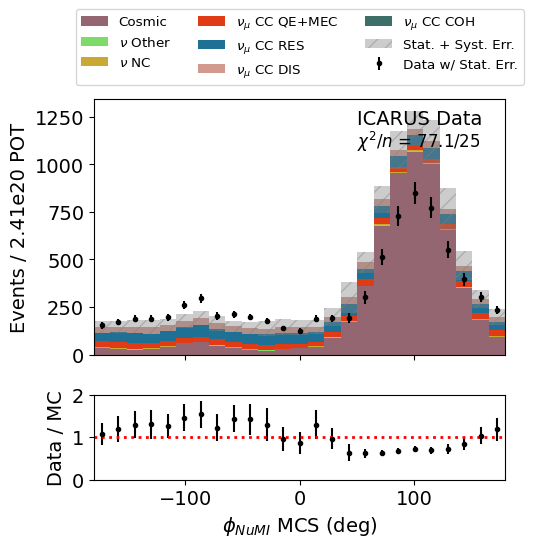


JUST WEIRD BIN: 

DATA EVENTS IN PLOT (w/ Normalization):  456.2640213996546
MC EVENTS IN PLOT (w/ Normalization):  601.3859404425602
DATA/MC IN PLOT (w/ Normalization):  0.7586875427514811
bin boundaries:
[-180.  -165.6 -151.2 -136.8 -122.4 -108.   -93.6  -79.2  -64.8  -50.4
  -36.   -21.6   -7.2    7.2   21.6   36.    50.4   64.8   79.2   93.6
  108.   122.4  136.8  151.2  165.6]
chi2 over n = 0.7344930849937815


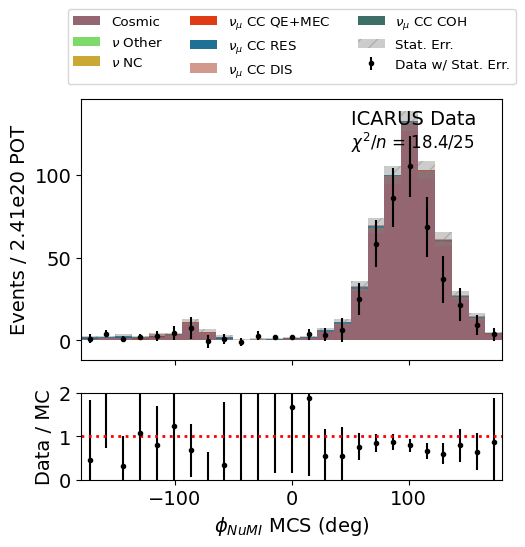

In [30]:
# what are the phi_NuMI for events in that bin?
# TODO: add variable to the syst_evtdfs.

# all
print('\nALL EVENTS: \n')
makeplot(evtdf, evtdf.phi_NuMI_mcs*180./math.pi,
         syst_evtdfs, [sdf.phi_NuMI_mcs*180./math.pi for sdf in syst_evtdfs],
         (-180, 180), xlabel="$\phi_{NuMI}$ MCS (deg)", ratio_bounds=[0,2])#, title="All Events") # detailed_mc='final_state'

# Just weird bin
print('\nJUST WEIRD BIN: \n')
makeplot(evtdf[inWeirdBin_mask], evtdf[inWeirdBin_mask].phi_NuMI_mcs*180./math.pi,
         syst_evtdfs, [sdf.phi_NuMI_mcs*180./math.pi for sdf in syst_evtdfs],
         (-180, 180), xlabel="$\phi_{NuMI}$ MCS (deg)", do_systs=False, ratio_bounds=[0,2])#, title="Just Events in Weird Bin", do_systs=False) # detailed_mc='final_state'
    # Note: if I do do systs, I need to apply inWeirdBin_mask to each sdf

# Avoid Cosmics:

#makeplot(evtdf_avoid_cosmics, 
#         evtdf_avoid_cosmics.phi_NuMI_mcs*180./math.pi,
#         syst_evtdfs_avoiding_cosmics, 
#         [sdf.phi_NuMI_mcs*180./math.pi*180./math.pi for sdf in syst_evtdfs_avoiding_cosmics],
#         (10,55.), xlabel = "$\phi_{NuMI}$ MCS (deg)", detailed_mc="int_type",
#         ratio_bounds=[0.25, 2.25], plotname='phi_NuMI_fewercosmics') # 
#makeplot(evtdf_avoid_cosmics, 
#         evtdf_avoid_cosmics.phi_NuMI_mcs*180./math.pi,
#         syst_evtdfs_avoiding_cosmics, 
#         [sdf.phi_NuMI_mcs*180./math.pi*180./math.pi for sdf in syst_evtdfs_avoiding_cosmics],
#         (10,55.), xlabel = "$\phi_{NuMI}$ MCS (deg)", detailed_mc="int_type",
#         ratio_bounds=[0.25, 2.25], plotname='phi_NuMI_fewercosmics') # 

In [30]:
# What phi_NuMI do cosmics with p-hat = [0,-1,0] make?

scalar_mom = np.array( [ 0,-1,0 ])
N = np.cross(BEAMDIR, NUMIDIR)
pp = scalar_mom - scalar_mom.dot(BEAMDIR)*BEAMDIR
phiNuMI_cos = ( angle_between_vecs(pp, N) )
print(phiNuMI_cos*180/math.pi)

# discussion: doesn't match peak in plot, but again, not too surprising since the "cosmics" in my sample are weird "cosmics".

86.78664374435411


### ~ end theta_NuMI Mystery Bump tangent ~

/tmp/ipykernel_3365396/1154702738.py:139: RuntimeWarning: invalid value encountered in divide
  frac_cohlike_bybin = np.array(cohlike_hist[0]/mc)


frac_cohlike_bybin:  [       nan        nan 0.17895098 0.150264   0.13141964 0.10496095
 0.08005219 0.05848333 0.04747863 0.04268487 0.04030793 0.03958418
 0.03642433 0.03911189 0.03508902 0.03236091 0.03654856 0.03660464
 0.04202106 0.03597554 0.03685933 0.03606496 0.03461375 0.05620727
 0.05324568]


/tmp/ipykernel_3365396/1154702738.py:254: RuntimeWarning: invalid value encountered in divide
  rathole = data/mc # (ratio)
/tmp/ipykernel_3365396/1154702738.py:255: RuntimeWarning: invalid value encountered in divide
  rathole_err = np.sqrt((data_err/mc)**2 + (data*mc_err/mc**2)**2)


chi2 over n = 3.649437435145465


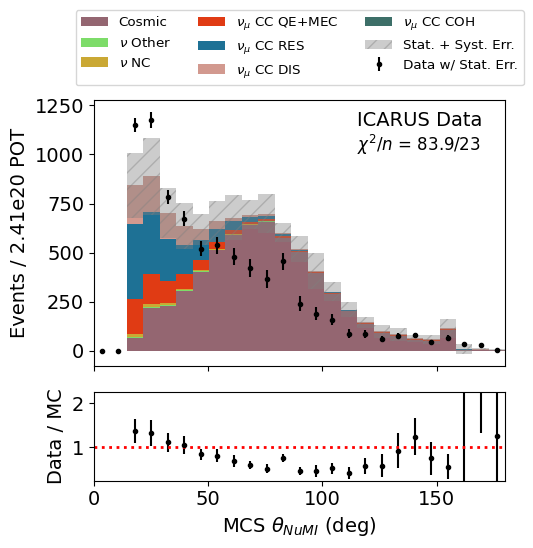

frac_cohlike_bybin:  [0.1546289  0.17574409 0.18447181 0.16244136 0.13029555 0.10494145
 0.08017589 0.05461144 0.04654445 0.04014759 0.03712792 0.03777887
 0.03583247 0.03617191 0.03544155 0.03065393 0.04105893 0.04809291
 0.02924126 0.03581105 0.03864835 0.04348922 0.02516561 0.04828467
 0.10052122]
chi2 over n = 4.48080670325967


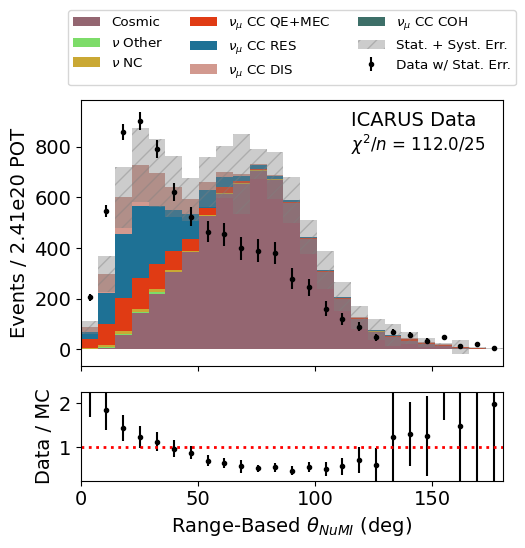

frac_cohlike_bybin:  [0.22618145 0.22433212 0.19221192 0.15864784 0.12593607 0.10331547
 0.07820225 0.05692292 0.04778628 0.04260548 0.03835249 0.03799898
 0.03677137 0.0373435  0.03354786 0.03062269 0.04592259 0.04030449
 0.03453121 0.04035146 0.03061307 0.04233318 0.03662827 0.0395226
 0.03078149]
chi2 over n = 3.486712110764301


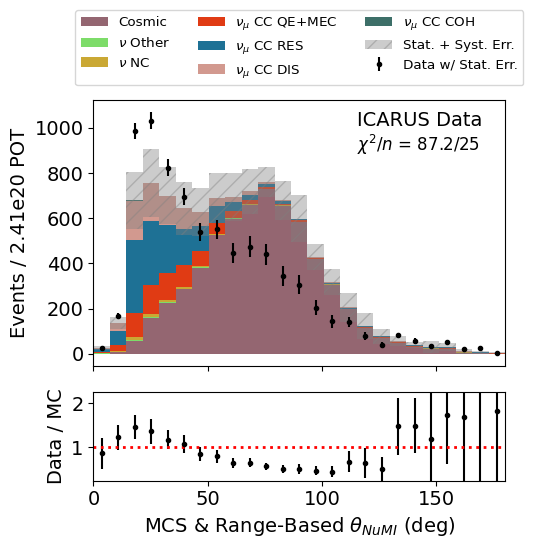

frac_cohlike_bybin:  [0.08969275 0.1015999  0.11268659 0.11374276 0.12491308 0.10113277
 0.06438775 0.07899067 0.07043611 0.06382905 0.0569497  0.0485756
 0.05191098 0.04706311 0.04259448 0.03710459 0.03648981 0.03716157
 0.03833683 0.03575388 0.04026132 0.03713257 0.03032829 0.04255172
 0.06974486]
chi2 over n = 2.072091312621981


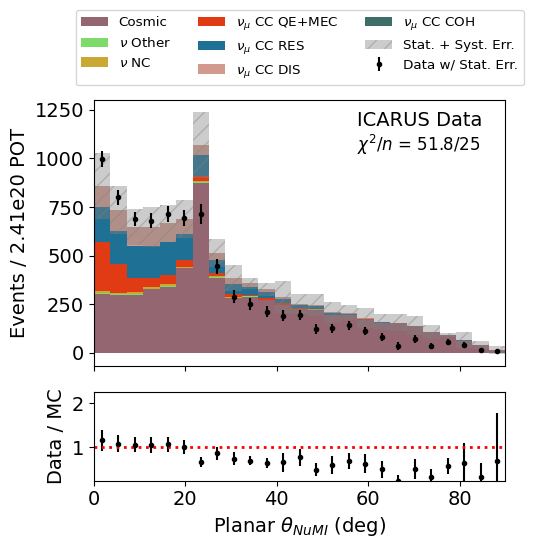

frac_cohlike_bybin:  [0.2033901  0.21040226 0.19607863 0.16390443 0.13120878 0.10451933
 0.07892085 0.06041682 0.04302376 0.03978886 0.03727735 0.03647332
 0.03765269 0.03657781 0.03652644 0.03319387 0.04175382 0.03431032
 0.04178342 0.02940102 0.03924587 0.03026584 0.05683177 0.03369914
 0.04463368]
chi2 over n = 3.589729323811065


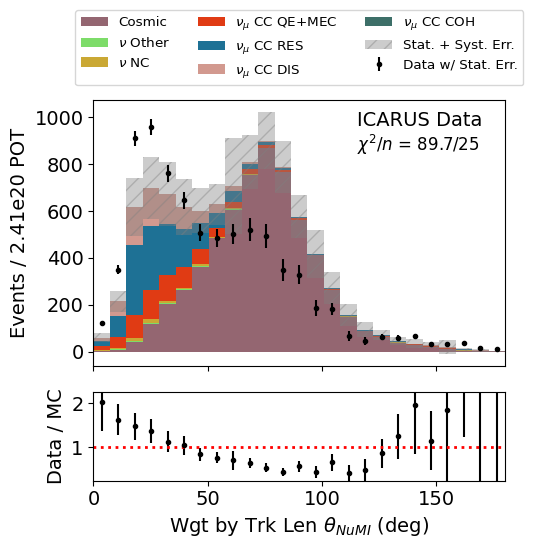

AttributeError: 'DataFrame' object has no attribute 'Snumi_angle_trkDirOnlyn'

In [23]:
# Compare theta_NuMI Methods, full far sb:
myrange = (0, 180.)

makeplot(evtdf, 
         evtdf.Snumi_angle_mcs*180./math.pi,
         syst_evtdfs, 
         [sdf.Snumi_angle_mcs*180./math.pi for sdf in syst_evtdfs],
         myrange, xlabel = "MCS $\\theta_{NuMI}$ (deg)", detailed_mc="int_type",
         ratio_bounds=[0.25, 2.25], plotname='theta_NuMI_fewercosmics') # 

makeplot(evtdf, 
         evtdf.Snumi_angle_rangeBased*180./math.pi,
         syst_evtdfs, 
         [sdf.Snumi_angle_rangeBased*180./math.pi for sdf in syst_evtdfs],
         myrange, xlabel = "Range-Based $\\theta_{NuMI}$ (deg)", detailed_mc="int_type",
         ratio_bounds=[0.25, 2.25], plotname='theta_NuMI_fewercosmics')

makeplot(evtdf, 
         evtdf.Snumi_angle_hybrid_rangeMCS*180./math.pi,
         syst_evtdfs, 
         [sdf.Snumi_angle_hybrid_rangeMCS*180./math.pi for sdf in syst_evtdfs],
         myrange, xlabel = "MCS & Range-Based $\\theta_{NuMI}$ (deg)", detailed_mc="int_type",
         ratio_bounds=[0.25, 2.25], plotname='theta_NuMI_fewercosmics')

makeplot(evtdf, 
         evtdf.Snumi_angle_planar*180./math.pi,
         syst_evtdfs, 
         [sdf.Snumi_angle_planar*180./math.pi for sdf in syst_evtdfs],
         (0,90.), xlabel = "Planar $\\theta_{NuMI}$ (deg)", detailed_mc="int_type",
         ratio_bounds=[0.25, 2.25], plotname='theta_NuMI_fewercosmics')

makeplot(evtdf, 
         evtdf.Snumi_angle_wgtByLen*180./math.pi,
         syst_evtdfs, 
         [sdf.Snumi_angle_wgtByLen*180./math.pi for sdf in syst_evtdfs],
         myrange, xlabel = "Wgt by Trk Len $\\theta_{NuMI}$ (deg)", detailed_mc="int_type",
         ratio_bounds=[0.25, 2.25], plotname='theta_NuMI_fewercosmics')

makeplot(evtdf, 
         evtdf.Snumi_angle_trkDirOnly*180./math.pi,
         syst_evtdfs, 
         [sdf.Snumi_angle_trkDirOnly*180./math.pi for sdf in syst_evtdfs],
         myrange, xlabel = "Trk Dir Only $\\theta_{NuMI}$ (deg)", detailed_mc="int_type",
         ratio_bounds=[0.25, 2.25], plotname='theta_NuMI_fewercosmics')


frac_cohlike_bybin:  [0.08030058 0.10007492 0.12352784 0.12417441 0.11918598 0.10605393
 0.09816573 0.09162869 0.08543115 0.0736248  0.05953948 0.04734528
 0.04503894 0.040695   0.03806585 0.03602426 0.03687834 0.03293349
 0.03514546 0.04161644 0.03675048 0.03081959 0.02909101 0.03633552
 0.03063579]
chi2 over n = 2.417525482608741


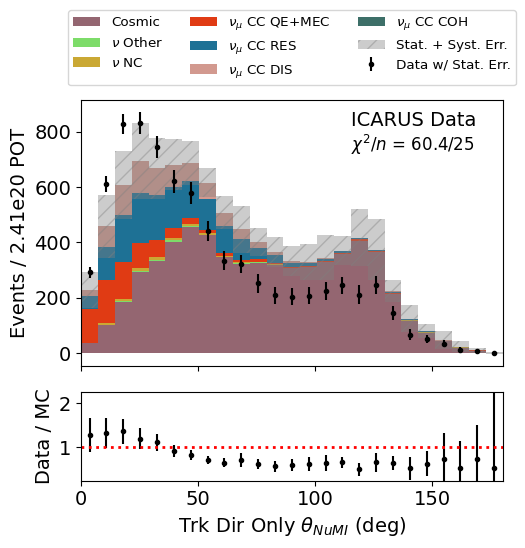

In [24]:
makeplot(evtdf, 
         evtdf.Snumi_angle_trkDirOnly*180./math.pi,
         syst_evtdfs, 
         [sdf.Snumi_angle_trkDirOnly*180./math.pi for sdf in syst_evtdfs],
         myrange, xlabel = "Trk Dir Only $\\theta_{NuMI}$ (deg)", detailed_mc="int_type",
         ratio_bounds=[0.25, 2.25], plotname='theta_NuMI_fewercosmics')


/tmp/ipykernel_3365396/1154702738.py:139: RuntimeWarning: invalid value encountered in divide
  frac_cohlike_bybin = np.array(cohlike_hist[0]/mc)


frac_cohlike_bybin:  [       nan        nan 0.1801476  0.1811951  0.17997654 0.17183595
 0.1503176  0.14463392 0.1548034  0.14976013 0.13419612 0.12161952
 0.12478283 0.11684007 0.10142323 0.10193782 0.09255489 0.08653232
 0.07806852 0.07136744        nan        nan        nan        nan
        nan]


/tmp/ipykernel_3365396/1154702738.py:254: RuntimeWarning: invalid value encountered in divide
  rathole = data/mc # (ratio)
/tmp/ipykernel_3365396/1154702738.py:255: RuntimeWarning: invalid value encountered in divide
  rathole_err = np.sqrt((data_err/mc)**2 + (data*mc_err/mc**2)**2)


chi2 over n = 1.1860008514981766


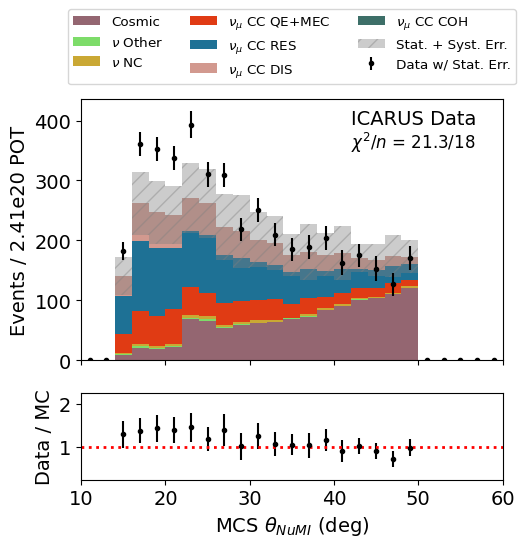

frac_cohlike_bybin:  [0.18409319 0.16936558 0.17412449 0.18721114 0.18799844 0.17641787
 0.17419838 0.15405186 0.16154074 0.14317388 0.14580847 0.12800498
 0.11568848 0.11374303 0.10884003 0.09770765 0.10593025 0.07860163
 0.08112733 0.07051909 0.07390235 0.07976021 0.07433359 0.06803057
 0.07660095]
chi2 over n = 1.1642772337476388


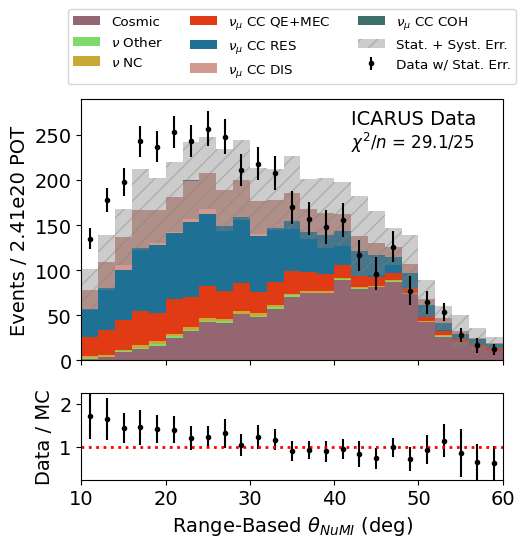

frac_cohlike_bybin:  [0.24847473 0.20584115 0.20861211 0.20105587 0.18859378 0.17787111
 0.17022581 0.14923587 0.16218308 0.14193306 0.13462979 0.12201475
 0.11231129 0.11550813 0.09855388 0.09205231 0.09825321 0.08667842
 0.07425627 0.07081603 0.07105101 0.06701527 0.07204722 0.09120279
 0.06030794]
chi2 over n = 1.2473490165694683


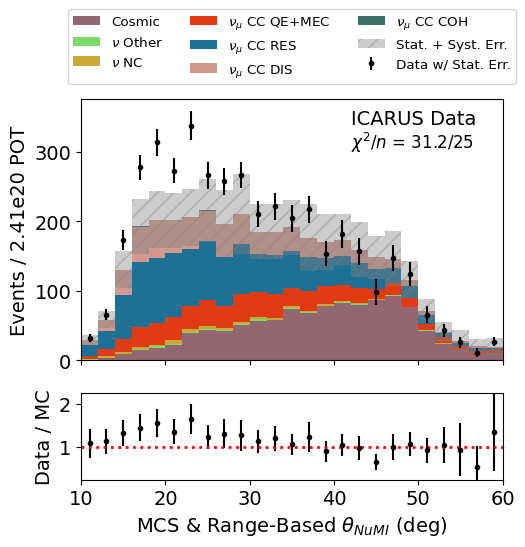

frac_cohlike_bybin:  [0.15698318 0.16703737 0.17614003 0.17553289 0.15990436 0.15150333
 0.10217468 0.11436018 0.13512073 0.12709691 0.11599271 0.11040777
 0.09201436 0.10426352 0.08811259 0.06596745 0.08142397 0.07431871
 0.08388141 0.04533141        nan        nan        nan        nan
        nan]
chi2 over n = 0.5923782990215319


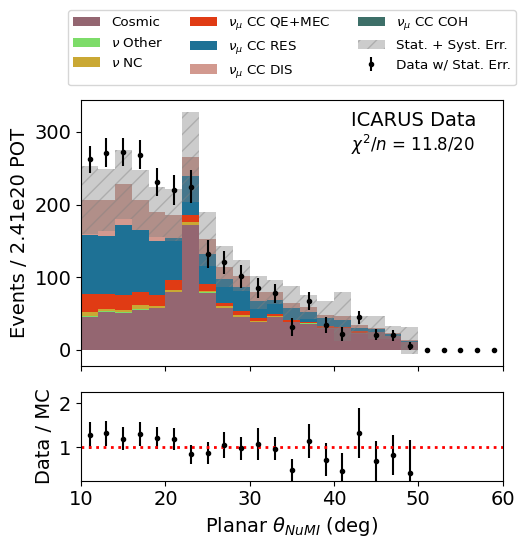

frac_cohlike_bybin:  [0.21322962 0.20791658 0.22050182 0.20227424 0.18294034 0.18632297
 0.17252783 0.16759021 0.15887528 0.14779457 0.14893889 0.12297226
 0.11169554 0.12101279 0.10251207 0.10091143 0.08508218 0.08877436
 0.08172505 0.07780095 0.08235975 0.04690049 0.06981947 0.06315747
 0.05490447]
chi2 over n = 1.4715546034634426


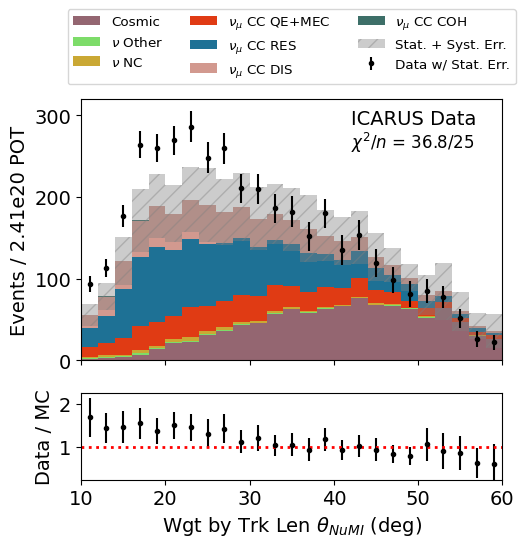

frac_cohlike_bybin:  [0.10614641 0.10600172 0.12649629 0.12695505 0.13216808 0.14236605
 0.15119007 0.12804924 0.14671291 0.1519221  0.15183148 0.1581916
 0.16339002 0.14808205 0.15805094 0.15994951 0.14523677 0.15991965
 0.1535427  0.12820972 0.14929465 0.13939948 0.16895648 0.15018317
 0.1505976 ]
chi2 over n = 1.0837838979489267


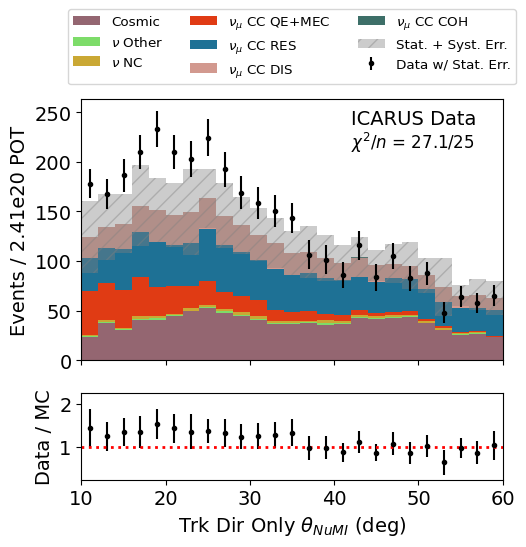

In [28]:
# Compare theta_NuMI Methods, avoid cosmics:

makeplot(evtdf_avoid_cosmics, 
         evtdf_avoid_cosmics.Snumi_angle_mcs*180./math.pi,
         syst_evtdfs_avoiding_cosmics, 
         [sdf.Snumi_angle_mcs*180./math.pi for sdf in syst_evtdfs_avoiding_cosmics],
         (10,60.), xlabel = "MCS $\\theta_{NuMI}$ (deg)", detailed_mc="int_type",
         ratio_bounds=[0.25, 2.25], plotname='theta_NuMI_fewercosmics') # 

makeplot(evtdf_avoid_cosmics, 
         evtdf_avoid_cosmics.Snumi_angle_rangeBased*180./math.pi,
         syst_evtdfs_avoiding_cosmics, 
         [sdf.Snumi_angle_rangeBased*180./math.pi for sdf in syst_evtdfs_avoiding_cosmics],
         (10,60.), xlabel = "Range-Based $\\theta_{NuMI}$ (deg)", detailed_mc="int_type",
         ratio_bounds=[0.25, 2.25], plotname='theta_NuMI_fewercosmics')

makeplot(evtdf_avoid_cosmics, 
         evtdf_avoid_cosmics.Snumi_angle_hybrid_rangeMCS*180./math.pi,
         syst_evtdfs_avoiding_cosmics, 
         [sdf.Snumi_angle_hybrid_rangeMCS*180./math.pi for sdf in syst_evtdfs_avoiding_cosmics],
         (10,60.), xlabel = "MCS & Range-Based $\\theta_{NuMI}$ (deg)", detailed_mc="int_type",
         ratio_bounds=[0.25, 2.25], plotname='theta_NuMI_fewercosmics')

makeplot(evtdf_avoid_cosmics, 
         evtdf_avoid_cosmics.Snumi_angle_planar*180./math.pi,
         syst_evtdfs_avoiding_cosmics, 
         [sdf.Snumi_angle_planar*180./math.pi for sdf in syst_evtdfs_avoiding_cosmics],
         (10,60.), xlabel = "Planar $\\theta_{NuMI}$ (deg)", detailed_mc="int_type",
         ratio_bounds=[0.25, 2.25], plotname='theta_NuMI_fewercosmics')

makeplot(evtdf_avoid_cosmics, 
         evtdf_avoid_cosmics.Snumi_angle_wgtByLen*180./math.pi,
         syst_evtdfs_avoiding_cosmics, 
         [sdf.Snumi_angle_wgtByLen*180./math.pi for sdf in syst_evtdfs_avoiding_cosmics],
         (10,60.), xlabel = "Wgt by Trk Len $\\theta_{NuMI}$ (deg)", detailed_mc="int_type",
         ratio_bounds=[0.25, 2.25], plotname='theta_NuMI_fewercosmics')

makeplot(evtdf_avoid_cosmics, 
         evtdf_avoid_cosmics.Snumi_angle_trkDirOnly*180./math.pi,
         syst_evtdfs_avoiding_cosmics, 
         [sdf.Snumi_angle_trkDirOnly*180./math.pi for sdf in syst_evtdfs_avoiding_cosmics],
         (10,60.), xlabel = "Trk Dir Only $\\theta_{NuMI}$ (deg)", detailed_mc="int_type",
         ratio_bounds=[0.25, 2.25], plotname='theta_NuMI_fewercosmics')


2.864788975654116


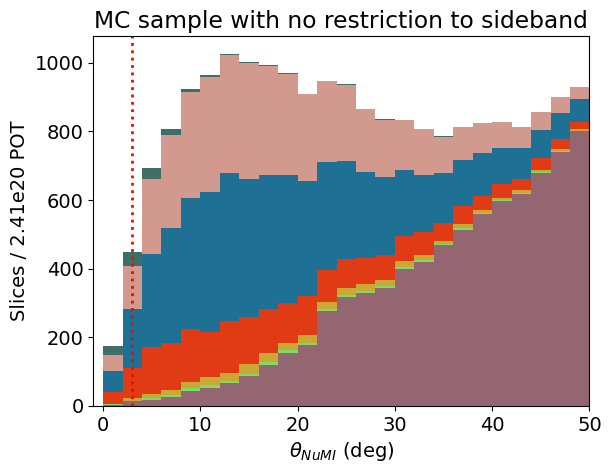

In [44]:
# MAY 7: 
print(0.05*180./math.pi)
categories = make_categories(evtdf, detailed_mc = 'int_type')
_ = plt.hist([evtdf[cat].Snumi_angle_mcs*180./math.pi for cat in categories[:-2]], 
            weights = [evtdf[cat].scale*evtdf[cat].wgt.cv for cat in categories[:-2]], 
            color=[cat.color for cat in categories[:-2]],
            label=[cat.name for cat in categories[:-2]],
            bins=25, density=False, histtype='bar', stacked=True, range=[0,50])
plt.axvline([3.], linestyle=":", color="r", linewidth=2) # NuMI_angle_thresh
plt.xlabel("$\\theta_{NuMI}$ (deg)")
plt.ylabel("Slices / %s" % POTSTR)
plt.xlim([-1,50])
plt.title('MC sample with no restriction to sideband')
#plt.legend()
plt.show()



/tmp/ipykernel_1493/760985860.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  var[np.isnan(var) | (var < 0)] = -10


DATA EVENTS IN PLOT (w/ Normalization):  4496.821416950118


/tmp/ipykernel_1493/760985860.py:127: RuntimeWarning: invalid value encountered in true_divide
  frac_cohlike_bybin = np.array(cohlike_hist[0]/mc)


MC EVENTS IN PLOT (w/ Normalization):  3895.450584074414
DATA/MC IN PLOT (w/ Normalization):  1.1543777336912602
bin boundaries:
[  0.           9.19999981  18.39999962  27.60000038  36.79999924
  46.          55.20000076  64.40000153  73.59999847  82.80000305
  92.         101.19999695 110.40000153 119.59999847 128.80000305
 138.         147.19999695 156.3999939  165.6000061  174.80000305
 184.         193.19999695 202.3999939  211.6000061  220.80000305]
chi2 over n = 1.446313014707935


/tmp/ipykernel_1493/760985860.py:236: RuntimeWarning: invalid value encountered in true_divide
  rathole = data/mc # (ratio)
/tmp/ipykernel_1493/760985860.py:237: RuntimeWarning: invalid value encountered in true_divide
  rathole_err = np.sqrt((data_err/mc)**2 + (data*mc_err/mc**2)**2)


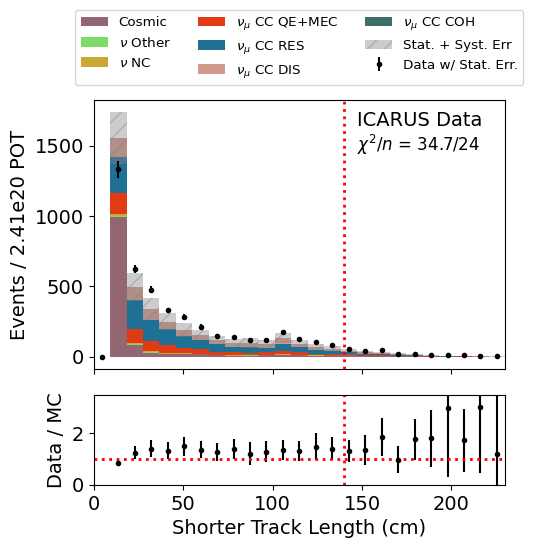

In [60]:
# Track Length

#makeplot(evtdf, evtdf.shorter_track_length,
#         syst_evtdfs, [sdf.shorter_track_length for sdf in syst_evtdfs],
#         (0, 300), xlabel="Shorter Track Length (cm)") # detailed_mc='final_state'

makeplot(evtdf_avoid_cosmics,
         evtdf_avoid_cosmics.shorter_track_length,
         syst_evtdfs_avoiding_cosmics, 
         [sdf.shorter_track_length for sdf in syst_evtdfs_avoiding_cosmics],
         (0,230), xlabel = "Shorter Track Length (cm)", detailed_mc="int_type",
         ratio_bounds=[0.,3.5], plotname='trackLen_fewercosmics', 
         vline=[140])


frac_cohlike_bybin:  [0.17285426 0.1206873  0.0804125  0.06596779 0.08197682 0.08704834
 0.08255086 0.07379287 0.06836025 0.06940976 0.06711887 0.07028903
 0.07453329 0.07000901 0.06945406 0.06742612 0.06415792 0.04603194
 0.06824448 0.05462114 0.0552594  0.08111682 0.05239882 0.06112253
 0.05824848]
chi2 over n = 1.0537315472799123


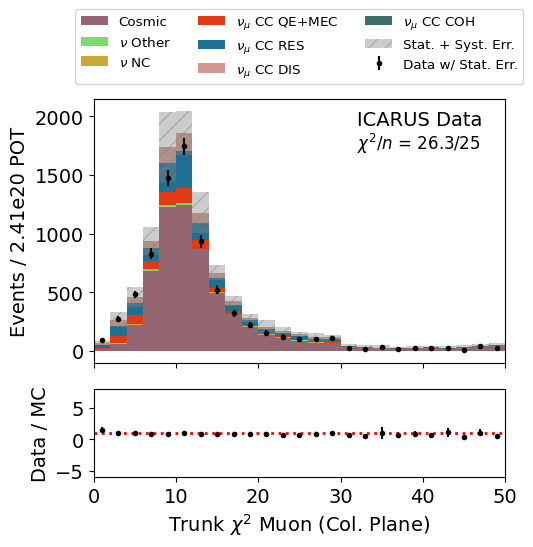

frac_cohlike_bybin:  [0.19091688 0.1528534  0.11446735 0.08718471 0.08869359 0.07889287
 0.06704427 0.06904988 0.06302663 0.07023104 0.07201924 0.07211323
 0.07670975 0.07422641 0.07037909 0.10648522 0.08524063 0.11326738
 0.06561857 0.12456527 0.12053992 0.06615221 0.08665662 0.06739292
 0.07103768]
chi2 over n = 1.2649735274440983


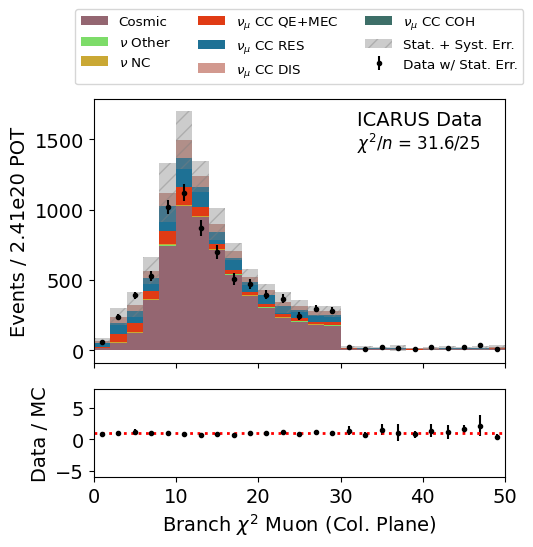

In [17]:
# CHI2 MUONS

# Sideband

## trunks
makeplot(evtdf, evtdf.trunk.trk.chi2pid.I2.chi2_muon,
         syst_evtdfs, [sdf.trunk.trk.chi2pid.I2.chi2_muon for sdf in syst_evtdfs],
         (0, 50), xlabel="Trunk $\\chi^2$ Muon (Col. Plane)")

## branches
makeplot(evtdf, evtdf.branch.trk.chi2pid.I2.chi2_muon,
         syst_evtdfs, [sdf.branch.trk.chi2pid.I2.chi2_muon for sdf in syst_evtdfs],
         (0, 50), xlabel="Branch $\\chi^2$ Muon (Col. Plane)")

# messed up
## both trunks and branches
#makeplot(evtdf,
#         pd.concat([evtdf.branch.trk.chi2pid.I2.chi2_muon, evtdf.trunk.trk.chi2pid.I2.chi2_muon]),
#         syst_evtdfs,
#         [pd.concat([sdf.branch.trk.chi2pid.I2.chi2_muon, sdf.trunk.trk.chi2pid.I2.chi2_muon])for sdf in syst_evtdfs],
#         (0, 100), 
#         xlabel="Track $\\chi^2$ Muon (Col. Plane)"
#        )

frac_cohlike_bybin:  [0.18935692 0.17691169 0.12182053 0.11392486 0.10906519 0.12940053
 0.15102459 0.15590326 0.14554304 0.14660804 0.12508809 0.10732843
 0.13286138 0.12135161 0.09923519 0.10756592 0.10251552 0.10473555
 0.10862924 0.09593355 0.09844131 0.12325328 0.12370167 0.05876767
 0.0922176 ]
chi2 over n = 0.7790897999551747


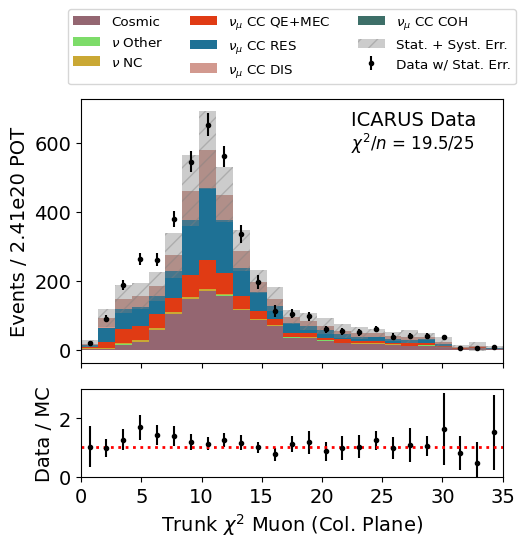

frac_cohlike_bybin:  [0.24901383 0.22531306 0.16001124 0.14390473 0.14411327 0.14476565
 0.15191975 0.14345197 0.12928953 0.11806588 0.12381565 0.12441397
 0.11195807 0.12242742 0.11993594 0.12282813 0.12442848 0.1242635
 0.10793438 0.11282433 0.10229407 0.12047253 0.11378197 0.12086368
 0.16498864]
chi2 over n = 0.976894559927733


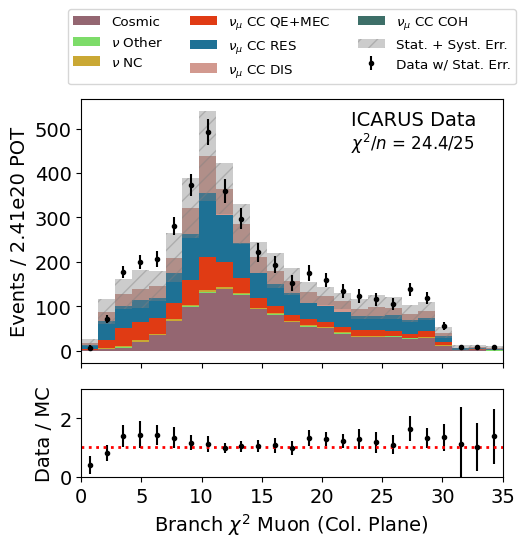

In [18]:
# Sideband and avoid cosmics:

vline = 18

makeplot(evtdf_avoid_cosmics,
         evtdf_avoid_cosmics.trunk.trk.chi2pid.I2.chi2_muon,
         syst_evtdfs_avoiding_cosmics, 
         [sdf.trunk.trk.chi2pid.I2.chi2_muon for sdf in syst_evtdfs_avoiding_cosmics],
         (0,35), xlabel = "Trunk $\\chi^2$ Muon (Col. Plane)", detailed_mc="int_type",
         ratio_bounds=[0,3.], plotname='muPID_trunk_fewercosmics')#,
     #    vline=[vline])

makeplot(evtdf_avoid_cosmics, 
         evtdf_avoid_cosmics.branch.trk.chi2pid.I2.chi2_muon,
         syst_evtdfs_avoiding_cosmics,
         [sdf.branch.trk.chi2pid.I2.chi2_muon for sdf in syst_evtdfs_avoiding_cosmics],
         (0,35), xlabel = "Branch $\\chi^2$ Muon (Col. Plane)", detailed_mc="int_type",
         ratio_bounds=[0, 3.], plotname='muPID_branch_fewercosmics')#,
         #vline=[vline])

frac_cohlike_bybin:  [0.03657012 0.06415437 0.04057092 0.08300308 0.0572127  0.07577083
 0.10566294 0.13481615 0.12529107 0.13516301 0.11384113 0.12549511
 0.1364458  0.14012177 0.16433898 0.15040757 0.13405664 0.12772097
 0.13346722 0.1088452  0.11543572 0.08448953 0.08878748 0.09916242
 0.12084135]
chi2 over n = 1.3047032937356362


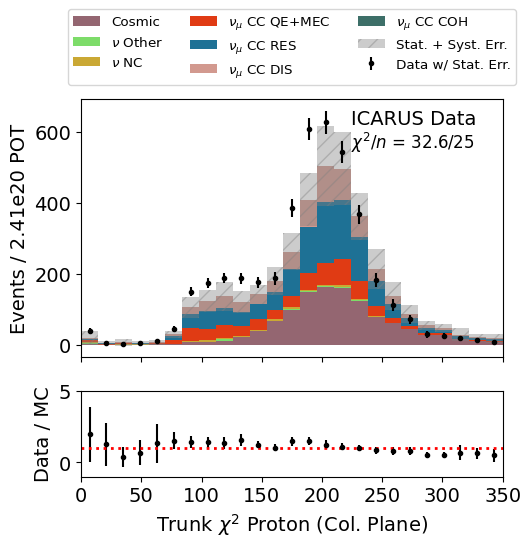

frac_cohlike_bybin:  [0.0709057  0.03248662 0.0931341  0.08815476 0.09326544 0.12894683
 0.14421692 0.16705766 0.16137608 0.14836401 0.13823887 0.13014788
 0.12756578 0.13338668 0.13736849 0.13726609 0.12855791 0.12290365
 0.11353427 0.10641163 0.12284921 0.12959572 0.12884454 0.12984092
 0.15962946]
chi2 over n = 1.2046181410233088


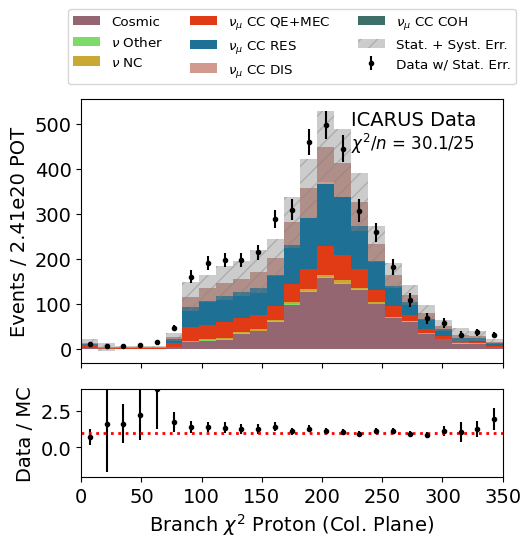

In [20]:
# CHI2 PROTONS

vline=90

# Sideband

## trunks
#makeplot(evtdf, evtdf.trunk.trk.chi2pid.I2.chi2_proton,
#         syst_evtdfs, [sdf.trunk.trk.chi2pid.I2.chi2_proton for sdf in syst_evtdfs],
#         (0, 100), xlabel="Trunk $\\chi^2$ Proton (Col. Plane)")

## branches
#makeplot(evtdf, evtdf.branch.trk.chi2pid.I2.chi2_proton,
#         syst_evtdfs, [sdf.branch.trk.chi2pid.I2.chi2_proton for sdf in syst_evtdfs],
#         (0, 100), xlabel="Branch $\\chi^2$ Proton (Col. Plane)")

# Sideband and avoid cosmics:

makeplot(evtdf_avoid_cosmics, 
         evtdf_avoid_cosmics.trunk.trk.chi2pid.I2.chi2_proton,
         syst_evtdfs_avoiding_cosmics, 
         [sdf.trunk.trk.chi2pid.I2.chi2_proton for sdf in syst_evtdfs_avoiding_cosmics],
         (0,350), xlabel = "Trunk $\\chi^2$ Proton (Col. Plane)", detailed_mc="int_type",
         ratio_bounds=[-1,5.], plotname='pPID_trunk_fewercosmics')#,
#         vline=[vline]) # 

makeplot(evtdf_avoid_cosmics, 
         evtdf_avoid_cosmics.branch.trk.chi2pid.I2.chi2_proton,
         syst_evtdfs_avoiding_cosmics, 
         [sdf.branch.trk.chi2pid.I2.chi2_proton for sdf in syst_evtdfs_avoiding_cosmics],
         (0,350), xlabel = "Branch $\\chi^2$ Proton (Col. Plane)", detailed_mc="int_type",
         ratio_bounds=[-2,4.], plotname='pPID_branch_fewercosmics')#,
#         vline=[vline]) # ratio_bounds=[0.25, 1.75], 

In [61]:
print(np.min(evtdf_avoid_cosmics.max_shw_len))
print(np.max(evtdf_avoid_cosmics.max_shw_len))
# NOTE: data/mc ratio equals expected value of 1.155 if you don't cut any of high-length tail out of plot. That's good. 

0.0
273.32956


/tmp/ipykernel_1493/3843515742.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  var[np.isnan(var) | (var < 0)] = -10


DATA EVENTS IN PLOT (w/ Normalization):  4414.306850456876


/tmp/ipykernel_1493/3843515742.py:127: RuntimeWarning: invalid value encountered in true_divide
  frac_cohlike_bybin = np.array(cohlike_hist[0]/mc)


MC EVENTS IN PLOT (w/ Normalization):  3826.6034235139086
DATA/MC IN PLOT (w/ Normalization):  1.1535835731844115
bin boundaries:
[-15.         -11.19999981  -7.4000001   -3.5999999    0.2
   4.           7.80000019  11.60000038  15.39999962  19.20000076
  23.          26.79999924  30.60000038  34.40000153  38.20000076
  42.          45.79999924  49.59999847  53.40000153  57.20000076
  61.          64.80000305  68.59999847  72.40000153  76.19999695]
chi2 over n = 1.1366099042763724


/tmp/ipykernel_1493/3843515742.py:236: RuntimeWarning: invalid value encountered in true_divide
  rathole = data/mc # (ratio)
/tmp/ipykernel_1493/3843515742.py:237: RuntimeWarning: invalid value encountered in true_divide
  rathole_err = np.sqrt((data_err/mc)**2 + (data*mc_err/mc**2)**2)


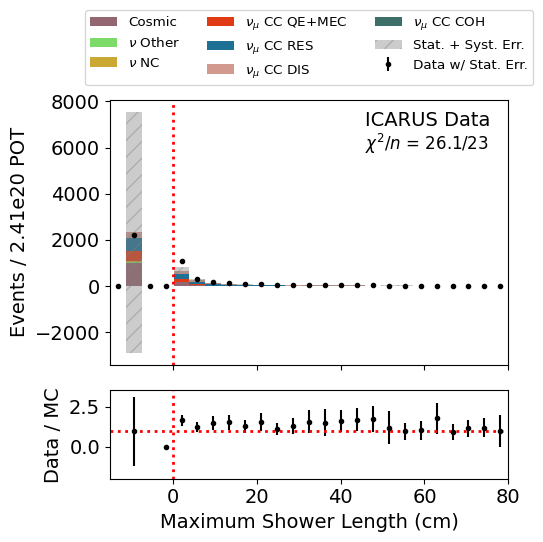

DATA EVENTS IN PLOT (w/ Normalization):  1990.1345277779712
MC EVENTS IN PLOT (w/ Normalization):  1340.9020059473662
DATA/MC IN PLOT (w/ Normalization):  1.484175964351633
bin boundaries:
[ 0.          1.60000002  3.20000005  4.80000019  6.4000001   8.
  9.60000038 11.19999981 12.80000019 14.39999962 16.         17.60000038
 19.20000076 20.79999924 22.39999962 24.         25.60000038 27.20000076
 28.79999924 30.39999962 32.         33.59999847 35.20000076 36.79999924
 38.40000153]
chi2 over n = 1.4590716544576532


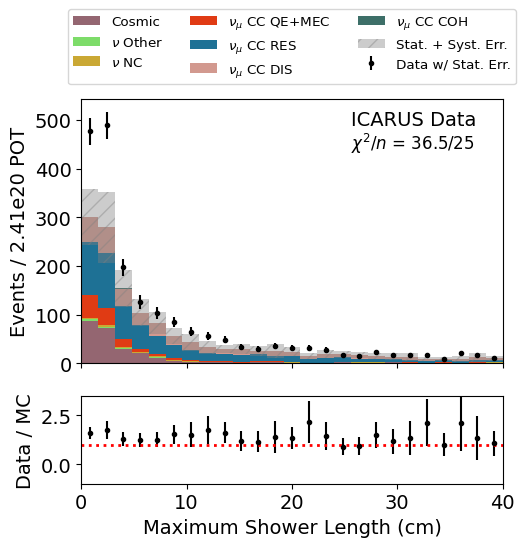

In [69]:
# Shower Length

#makeplot(evtdf, evtdf.max_shw_len,
#         syst_evtdfs, [sdf.max_shw_len for sdf in syst_evtdfs],
#         (-15, 100), xlabel="Maximum Shower Length (cm)") # detailed_mc='final_state'

makeplot(evtdf_avoid_cosmics, 
         evtdf_avoid_cosmics.max_shw_len,
         syst_evtdfs_avoiding_cosmics, 
         [sdf.max_shw_len for sdf in syst_evtdfs_avoiding_cosmics],
         (-15, 80), xlabel = "Maximum Shower Length (cm)", detailed_mc="int_type",
         ratio_bounds=[-2,3.5], plotname='shwLen_fewercosmics',
         vline=[0]) # ratio_bounds=[0.25, 1.75], 
makeplot(evtdf_avoid_cosmics, 
         evtdf_avoid_cosmics.max_shw_len,
         syst_evtdfs_avoiding_cosmics, 
         [sdf.max_shw_len for sdf in syst_evtdfs_avoiding_cosmics],
         (-0,40), xlabel = "Maximum Shower Length (cm)", detailed_mc="int_type",
         ratio_bounds=[-1,3.5], plotname='shwLen_Zoom_fewercosmics')


In [70]:
print(0.35*180./math.pi)

20.05352282957881


DATA EVENTS IN PLOT (w/ Normalization):  4508.821416950124


/tmp/ipykernel_1493/3843515742.py:127: RuntimeWarning: invalid value encountered in true_divide
  frac_cohlike_bybin = np.array(cohlike_hist[0]/mc)


MC EVENTS IN PLOT (w/ Normalization):  3902.897548932047
DATA/MC IN PLOT (w/ Normalization):  1.1552497498131553
bin boundaries:
[ 60.          62.40000153  64.80000305  67.19999695  69.59999847
  72.          74.40000153  76.80000305  79.19999695  81.59999847
  84.          86.40000153  88.80000305  91.19999695  93.59999847
  96.          98.40000153 100.80000305 103.19999695 105.59999847
 108.         110.40000153 112.80000305 115.19999695 117.59999847]
chi2 over n = 0.7393347965364669


/tmp/ipykernel_1493/3843515742.py:236: RuntimeWarning: invalid value encountered in true_divide
  rathole = data/mc # (ratio)
/tmp/ipykernel_1493/3843515742.py:237: RuntimeWarning: invalid value encountered in true_divide
  rathole_err = np.sqrt((data_err/mc)**2 + (data*mc_err/mc**2)**2)


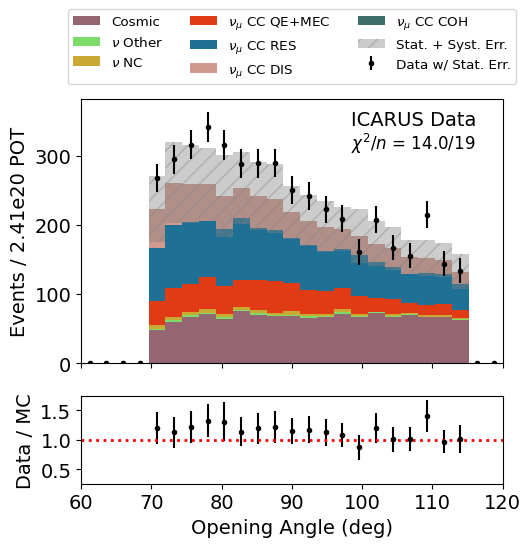

In [71]:
# Opening Angle

#makeplot(evtdf, np.arccos(dotdf(evtdf.trunk.trk.dir, evtdf.branch.trk.dir))*180/np.pi,
#         syst_evtdfs, [np.arccos(dotdf(sdf.trunk.trk.dir, sdf.branch.trk.dir))*180/np.pi for sdf in syst_evtdfs],
#         (0,180), xlabel="Opening Angle (deg)") # detailed_mc='final_state'

makeplot(evtdf_avoid_cosmics, 
         np.arccos(dotdf(evtdf_avoid_cosmics.trunk.trk.dir, evtdf_avoid_cosmics.branch.trk.dir))*180/np.pi,
         syst_evtdfs_avoiding_cosmics, 
         [np.arccos(dotdf(sdf.trunk.trk.dir, sdf.branch.trk.dir))*180/np.pi for sdf in syst_evtdfs_avoiding_cosmics],
         (60,120), xlabel = "Opening Angle (deg)", detailed_mc="int_type",ratio_bounds=[0.25, 1.75],
         vline=[20.], plotname='theta_mumu_fewercosmics')

DATA EVENTS IN PLOT (w/ Normalization):  790.9877230364502
MC EVENTS IN PLOT (w/ Normalization):  655.0049232618152
DATA/MC IN PLOT (w/ Normalization):  1.2076057674459353
bin boundaries:
[  0.  12.  24.  36.  48.  60.  72.  84.  96. 108. 120. 132. 144. 156.
 168. 180. 192. 204. 216. 228. 240. 252. 264. 276. 288.]
chi2 over n = 0.646377334726249


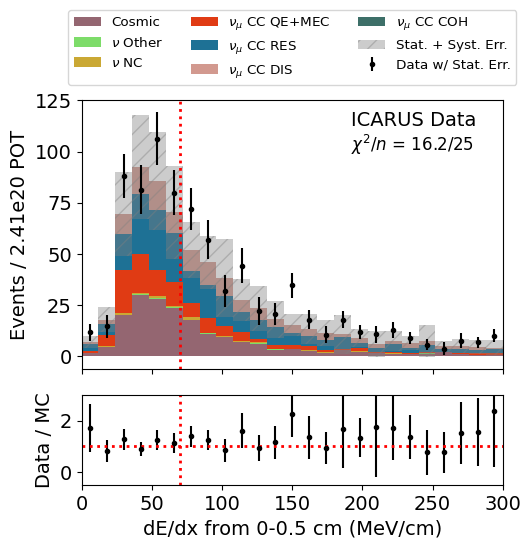

In [78]:
# dedx (Note: I used dqdx in event selection, but that is not available in data)
# Here, just do it for the sample that avoids cosmics.

#plt.hist(evtdf_avoid_cosmics.stub.l0_5cm.dedx)
#plt.show()

makeplot(evtdf_avoid_cosmics, 
         evtdf_avoid_cosmics.stub.l0_5cm.dedx,
         syst_evtdfs_avoiding_cosmics, 
         [sdf.stub.l0_5cm.dedx for sdf in syst_evtdfs_avoiding_cosmics],
         (0,300), xlabel = "dE/dx from 0-0.5 cm (MeV/cm)", detailed_mc="int_type",
        ratio_bounds=[-0.5,3], plotname='dEdx_0_fewercosmics', 
        vline=[70])


DATA EVENTS IN PLOT (w/ Normalization):  740.497429775302


/tmp/ipykernel_1493/3843515742.py:138: RuntimeWarning: divide by zero encountered in true_divide
  detsyst_hists.append(new_detsyst_hist[0]/frac_cohlike_bybin)
/tmp/ipykernel_1493/3843515742.py:141: RuntimeWarning: invalid value encountered in add
  middle_ind_cov = ( np.outer( mc - detsyst_hists[0] , mc - detsyst_hists[0] ) + np.outer( mc - detsyst_hists[1] , mc - detsyst_hists[1] ) )/2.
/tmp/ipykernel_1493/3843515742.py:150: RuntimeWarning: invalid value encountered in add
  front_ind_gain_cov = ( np.outer( mc - detsyst_hists[2] , mc - detsyst_hists[2] ) + np.outer( mc - detsyst_hists[3] , mc - detsyst_hists[3] ) )/2.
/tmp/ipykernel_1493/3843515742.py:237: RuntimeWarning: invalid value encountered in multiply
  rathole_err = np.sqrt((data_err/mc)**2 + (data*mc_err/mc**2)**2)


MC EVENTS IN PLOT (w/ Normalization):  710.1895381317586
DATA/MC IN PLOT (w/ Normalization):  1.0426757788114875
bin boundaries:
[  0.   6.  12.  18.  24.  30.  36.  42.  48.  54.  60.  66.  72.  78.
  84.  90.  96. 102. 108. 114. 120. 126. 132. 138. 144.]
chi2 over n = 0.5405825841260039


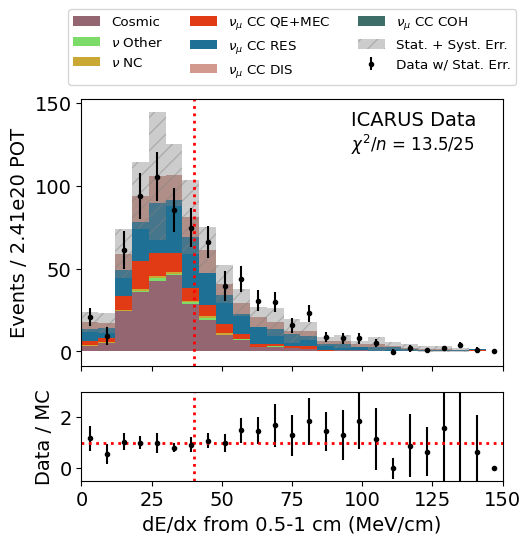

In [79]:
makeplot(evtdf_avoid_cosmics, 
         evtdf_avoid_cosmics.stub.l1cm.dedx,
         syst_evtdfs_avoiding_cosmics, 
         [sdf.stub.l1cm.dedx for sdf in syst_evtdfs_avoiding_cosmics],
         (0,150), xlabel = "dE/dx from 0.5-1 cm (MeV/cm)", detailed_mc="int_type",
        ratio_bounds=[-0.5,3], plotname='dEdx_1_fewercosmics',
        vline=[40])


DATA EVENTS IN PLOT (w/ Normalization):  1059.4119446658196
MC EVENTS IN PLOT (w/ Normalization):  895.5813426991048
DATA/MC IN PLOT (w/ Normalization):  1.182932129283714
bin boundaries:
[ 0.   3.6  7.2 10.8 14.4 18.  21.6 25.2 28.8 32.4 36.  39.6 43.2 46.8
 50.4 54.  57.6 61.2 64.8 68.4 72.  75.6 79.2 82.8 86.4]
chi2 over n = 0.6372240344904969


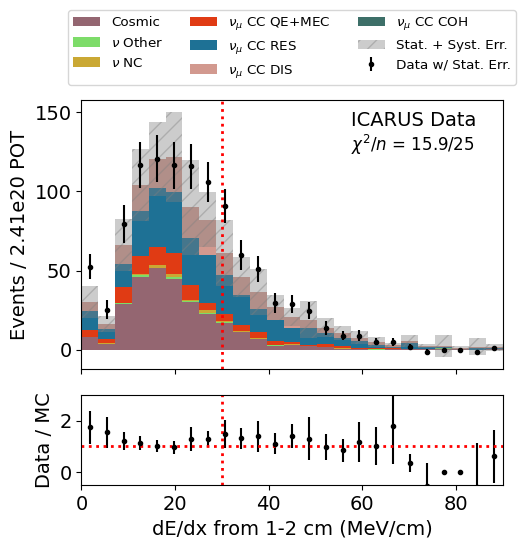

In [81]:
makeplot(evtdf_avoid_cosmics, 
         evtdf_avoid_cosmics.stub.l2cm.dedx,
         syst_evtdfs_avoiding_cosmics, 
         [sdf.stub.l2cm.dedx for sdf in syst_evtdfs_avoiding_cosmics],
         (0,90), xlabel = "dE/dx from 1-2 cm (MeV/cm)", detailed_mc="int_type",
        ratio_bounds=[-0.5, 3], plotname='dEdx_2_fewercosmics',
        vline=[30])


DATA EVENTS IN PLOT (w/ Normalization):  700.7878778446201
MC EVENTS IN PLOT (w/ Normalization):  562.1771248114486
DATA/MC IN PLOT (w/ Normalization):  1.2465606423947984
bin boundaries:
[ 0.   2.2  4.4  6.6  8.8 11.  13.2 15.4 17.6 19.8 22.  24.2 26.4 28.6
 30.8 33.  35.2 37.4 39.6 41.8 44.  46.2 48.4 50.6 52.8]
chi2 over n = 0.6982786098236573


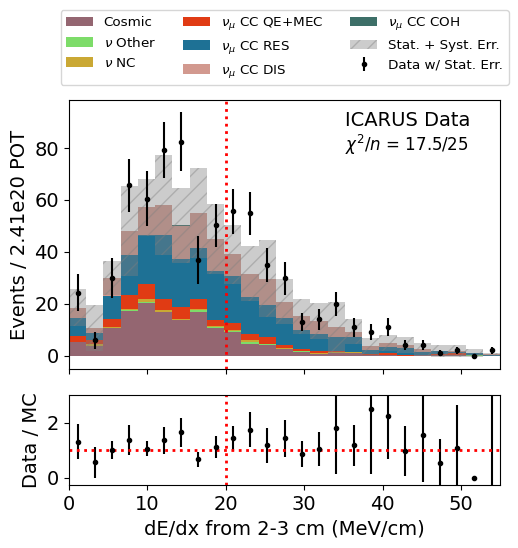

In [82]:
makeplot(evtdf_avoid_cosmics, 
         evtdf_avoid_cosmics.stub.l3cm.dedx,
         syst_evtdfs_avoiding_cosmics, 
         [sdf.stub.l3cm.dedx for sdf in syst_evtdfs_avoiding_cosmics],
         (0,55), xlabel = "dE/dx from 2-3 cm (MeV/cm)", detailed_mc="int_type",
        ratio_bounds=[-0.25, 3.], plotname='dEdx_3_fewercosmics',
        vline=[20])


### Comparison of MCS and Range-based mom. reconstruction for contained tracks in MC and Data.

In [24]:
# MCS momentum reconstruction: (MCS^-1 - true^-1)/true^-1 for contained tracks, & exclude trks with non-physical values of p_MCS.
# 23/07/24: Instead of re-working makeplot function, make new dataframes where the rows are the contained tracks.

var_t = df.trunk.trk.mcsP.fwdP_muon
var_b = df.branch.trk.mcsP.fwdP_muon
mask_minus1 = ((var_t==-1.0) | (var_b==-1.0))
mask_weird = ((var_t==0.01) | (var_b==0.01))
mask_sevenptfive = ((var_t==7.5) | (var_b==7.5))
noflags_df = df[~(mask_minus1 |  mask_weird | mask_sevenptfive)]

def trk_exclude_nonphys_mcsVals(trk):
    mask_minus1 = (trk.mcsP.fwdP_muon==-1.0)
    mask_weird = (trk.mcsP.fwdP_muon==0.01)
    mask_sevenptfive = (trk.mcsP.fwdP_muon==7.5)
    return ( (~mask_minus1) & (~mask_weird) & (~mask_sevenptfive) )

## evtdf

when_trunk_con = TrkInFV(evtdf.trunk.trk.end) & trk_exclude_nonphys_mcsVals(evtdf.trunk.trk)
when_branch_con = TrkInFV(evtdf.branch.trk.end) & trk_exclude_nonphys_mcsVals(evtdf.branch.trk)

trunk_con_mcs_evtdf = evtdf[when_trunk_con]#.trunk.trk.mcsP['fwdP_muon']
trunk_con_mcs_evtdf['containedTrk_mu_MCSp'] = trunk_con_mcs_evtdf.trunk.trk.mcsP.fwdP_muon
trunk_con_mcs_evtdf['containedTrk_mu_rangep'] = trunk_con_mcs_evtdf.trunk.trk.rangeP.p_muon

branch_con_mcs_evtdf = evtdf[when_branch_con]#.branch.trk.mcsP.fwdP_muon
branch_con_mcs_evtdf['containedTrk_mu_MCSp'] = branch_con_mcs_evtdf.branch.trk.mcsP.fwdP_muon
branch_con_mcs_evtdf['containedTrk_mu_rangep'] = branch_con_mcs_evtdf.branch.trk.rangeP.p_muon

con_tracks_df = pd.DataFrame(pd.concat([trunk_con_mcs_evtdf, branch_con_mcs_evtdf], keys=[1,0], names=['trunk']))
con_tracks_df = con_tracks_df.reorder_levels(order=['sample', '__ntuple', 'entry', 'rec.slc..index', 'trunk'])
con_tracks_df['contained_MCS_performance'] = (con_tracks_df['containedTrk_mu_MCSp'] - con_tracks_df['containedTrk_mu_rangep'])/con_tracks_df['containedTrk_mu_rangep']
con_tracks_df['contained_MCS_performance_invs'] = (1./con_tracks_df['containedTrk_mu_MCSp'] - 1./con_tracks_df['containedTrk_mu_rangep'])/(1./con_tracks_df['containedTrk_mu_rangep'])

## syst evtdfs

con_tracks_syst_evtdfs = []
for df in syst_evtdfs:
    when_trunk_con_systs = TrkInFV(df.trunk.trk.end)
    when_branch_con_systs = TrkInFV(df.branch.trk.end)
    
    trunk_con_mcs_syst_evtdf = df[when_trunk_con_systs]#.trunk.trk.mcsP.fwdP_muon
    trunk_con_mcs_syst_evtdf['containedTrk_mu_MCSp'] = trunk_con_mcs_syst_evtdf.trunk.trk.mcsP.fwdP_muon
    trunk_con_mcs_syst_evtdf['containedTrk_mu_rangep'] = trunk_con_mcs_syst_evtdf.trunk.trk.rangeP.p_muon
    
    branch_con_mcs_syst_evtdf = df[when_branch_con_systs]#.branch.trk.mcsP.fwdP_muon
    branch_con_mcs_syst_evtdf['containedTrk_mu_MCSp'] = branch_con_mcs_syst_evtdf.branch.trk.mcsP.fwdP_muon
    branch_con_mcs_syst_evtdf['containedTrk_mu_rangep'] = branch_con_mcs_syst_evtdf.branch.trk.rangeP.p_muon
    
    con_tracks_syst_df = pd.DataFrame(pd.concat([trunk_con_mcs_syst_evtdf, branch_con_mcs_syst_evtdf], keys=[1,0], names=['trunk']))
    con_tracks_syst_df = con_tracks_syst_df.reorder_levels(order=['__ntuple', 'entry', 'rec.slc..index', 'trunk'])
    con_tracks_syst_df['contained_MCS_performance'] = (con_tracks_syst_df['containedTrk_mu_MCSp'] - con_tracks_syst_df['containedTrk_mu_rangep'])/con_tracks_syst_df['containedTrk_mu_rangep']
    con_tracks_syst_df['contained_MCS_performance_invs'] = (1./con_tracks_syst_df['containedTrk_mu_MCSp'] - 1./con_tracks_syst_df['containedTrk_mu_rangep'])/(1./con_tracks_syst_df['containedTrk_mu_rangep'])
    con_tracks_syst_evtdfs.append(con_tracks_syst_df)
    

/tmp/ipykernel_1840813/2824052544.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trunk_con_mcs_evtdf['containedTrk_mu_MCSp'] = trunk_con_mcs_evtdf.trunk.trk.mcsP.fwdP_muon
/tmp/ipykernel_1840813/2824052544.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trunk_con_mcs_evtdf['containedTrk_mu_rangep'] = trunk_con_mcs_evtdf.trunk.trk.rangeP.p_muon
/tmp/ipykernel_1840813/2824052544.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

/tmp/ipykernel_1840813/2824052544.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  branch_con_mcs_syst_evtdf['containedTrk_mu_MCSp'] = branch_con_mcs_syst_evtdf.branch.trk.mcsP.fwdP_muon
/tmp/ipykernel_1840813/2824052544.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  branch_con_mcs_syst_evtdf['containedTrk_mu_rangep'] = branch_con_mcs_syst_evtdf.branch.trk.rangeP.p_muon
/tmp/ipykernel_1840813/2824052544.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

/tmp/ipykernel_1840813/1372509562.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  var[np.isnan(var)] = -10


DATA EVENTS IN PLOT (w/ Normalization):  6231.546266914322


/tmp/ipykernel_1840813/1372509562.py:139: RuntimeWarning: invalid value encountered in divide
  frac_cohlike_bybin = np.array(cohlike_hist[0]/mc)


MC EVENTS IN PLOT (w/ Normalization):  7535.235011807441
DATA/MC IN PLOT (w/ Normalization):  0.8269876463241974
bin boundaries:
[-1.5        -1.36000001 -1.22000003 -1.08000004 -0.94       -0.80000001
 -0.66000003 -0.51999998 -0.38       -0.23999999 -0.1         0.04
  0.18000001  0.31999999  0.46000001  0.60000002  0.74000001  0.88
  1.01999998  1.15999997  1.29999995  1.44000006  1.58000004  1.72000003
  1.86000001]
chi2 over n = 1.3727346542340997


/tmp/ipykernel_1840813/1372509562.py:253: RuntimeWarning: invalid value encountered in divide
  rathole = data/mc # (ratio)
/tmp/ipykernel_1840813/1372509562.py:254: RuntimeWarning: invalid value encountered in divide
  rathole_err = np.sqrt((data_err/mc)**2 + (data*mc_err/mc**2)**2)


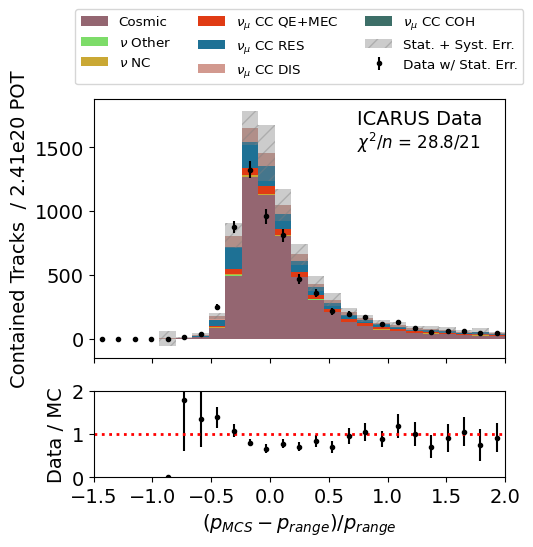

In [25]:
makeplot(con_tracks_df, 
         con_tracks_df.contained_MCS_performance,
         con_tracks_syst_evtdfs, 
         [sdf.contained_MCS_performance for sdf in con_tracks_syst_evtdfs],
         (-1.5,2), xlabel = "$(p_{MCS}-p_{range})/p_{range}$", detailed_mc="int_type",
        ratio_bounds=[0,2], plotname='p_MCS', ylabel='Contained Tracks ')

/tmp/ipykernel_1840813/1372509562.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  var[np.isnan(var)] = -10


DATA EVENTS IN PLOT (w/ Normalization):  6633.140362919403


/tmp/ipykernel_1840813/1372509562.py:139: RuntimeWarning: invalid value encountered in divide
  frac_cohlike_bybin = np.array(cohlike_hist[0]/mc)


MC EVENTS IN PLOT (w/ Normalization):  8181.473460009862
DATA/MC IN PLOT (w/ Normalization):  0.8107513145818366
bin boundaries:
[-1.5        -1.38       -1.25999999 -1.13999999 -1.01999998 -0.89999998
 -0.77999997 -0.66000003 -0.54000002 -0.41999999 -0.30000001 -0.18000001
 -0.06        0.06        0.18000001  0.30000001  0.41999999  0.54000002
  0.66000003  0.77999997  0.89999998  1.01999998  1.13999999  1.25999999
  1.38      ]
chi2 over n = 1.628749277003336


/tmp/ipykernel_1840813/1372509562.py:253: RuntimeWarning: invalid value encountered in divide
  rathole = data/mc # (ratio)
/tmp/ipykernel_1840813/1372509562.py:254: RuntimeWarning: invalid value encountered in divide
  rathole_err = np.sqrt((data_err/mc)**2 + (data*mc_err/mc**2)**2)


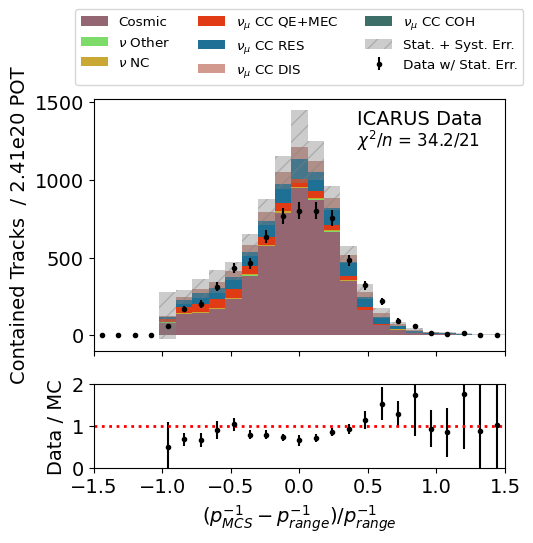

In [27]:
makeplot(con_tracks_df, 
         con_tracks_df.contained_MCS_performance_invs,
         con_tracks_syst_evtdfs, 
         [sdf.contained_MCS_performance_invs for sdf in con_tracks_syst_evtdfs],
         (-1.5,1.5), xlabel = "$(p_{MCS}^{-1}-p_{range}^{-1})/p_{range}^{-1}$", detailed_mc="int_type",
        ratio_bounds=[0,2], plotname='p_MCS', ylabel='Contained Tracks ')

In [36]:
for c in con_tracks_df.columns: print(c)



('slc', 'is_clear_cosmic', '', '', '', '')
('slc', 'vertex', 'x', '', '', '')
('slc', 'vertex', 'y', '', '', '')
('slc', 'vertex', 'z', '', '', '')
('slc', 'self', '', '', '', '')
('slc', 'tmatch', 'eff', '', '', '')
('slc', 'tmatch', 'pur', '', '', '')
('slc', 'tmatch', 'idx', '', '', '')
('slc', 'producer', '', '', '', '')
('slc', 'nuid', 'crlongtrkdiry', '', '', '')
('slc', 'truth', 'E', '', '', '')
('slc', 'truth', 'bjorkenX', '', '', '')
('slc', 'truth', 'inelasticityY', '', '', '')
('slc', 'truth', 'Q2', '', '', '')
('slc', 'truth', 'w', '', '', '')
('slc', 'truth', 'momentum', 'x', '', '')
('slc', 'truth', 'momentum', 'y', '', '')
('slc', 'truth', 'momentum', 'z', '', '')
('slc', 'truth', 'position', 'x', '', '')
('slc', 'truth', 'position', 'y', '', '')
('slc', 'truth', 'position', 'z', '', '')
('slc', 'truth', 'pdg', '', '', '')
('slc', 'truth', 'iscc', '', '', '')
('slc', 'truth', 'genie_mode', '', '', '')
('slc', 'truth', 'parent_pdg', '', '', '')
('slc', 'truth', 'parent_dc

In [35]:
print(con_tracks_df.columns)

Index(['fwdP_muon'], dtype='object')
